In [23]:
import os
import sys
import skimage.io
import numpy as np
import json
import skimage.draw
import matplotlib.pyplot as plt
import ssl
from sklearn.cluster import KMeans
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
import scipy.ndimage as ndimage
import skimage.filters as filters
from mrcnn import visualize
from mrcnn import visualize
# Root directory of the project
ROOT_DIR = os.path.abspath("D:/Mask_RCNN-master/")
sys.path.append(ROOT_DIR)

# Create directory for logs and trained weights if it doesn't exist
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

ssl._create_default_https_context = ssl._create_unverified_context
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))
plt.rcParams['figure.facecolor'] = 'white'


def get_ax(rows=1, cols=1, size=7):
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax


# Import Mask RCNN COCO trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

DATASET_DIR = "D:/Mask_RCNN-master/Br35H-Mask-RCNN/"


class TumorConfig(Config):
    NAME = 'tumor_detector'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # background + tumor
    DETECTION_MIN_CONFIDENCE = 0.85
    STEPS_PER_EPOCH = 5
    LEARNING_RATE = 0.001


config = TumorConfig()


class BrainScanDataset(utils.Dataset):
    def load_brain_scan(self, dataset_dir, subset):
        self.add_class("tumor", 1, "tumor")
        assert subset in ["TRAIN", "VAL", "TEST"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations = json.load(open(os.path.join(DATASET_DIR, subset, 'annotations_' + subset + '.json')))
        annotations = list(annotations.values())
        annotations = [a for a in annotations if a['regions']]
        for a in annotations:
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            image = image.astype(np.float32) / 255.0
            image = ndimage.median_filter(image, size=3)
            image = filters.unsharp_mask(image, radius=1.0, amount=1.5)
            height, width = image.shape[:2]
            self.add_image(
                "tumor",
                image_id=a['filename'],
                path=image_path,
                width=width,
                height=height,
                polygons=polygons
            )

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "tumor":
            return super(self.__class__, self).load_mask(image_id)
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            print("Polygon:", p)
            if 'all_points_y' not in p or 'all_points_x' not in p:
                print("Invalid polygon format:", p)
                continue
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [24]:

dataset_train = BrainScanDataset()
dataset_train.load_brain_scan(DATASET_DIR, 'TRAIN')
dataset_train.prepare()

dataset_val = BrainScanDataset()
dataset_val.load_brain_scan(DATASET_DIR, 'VAL')
dataset_val.prepare()


KeyboardInterrupt: 

In [ ]:
model = modellib.MaskRCNN(
    mode='training',
    config=config,
    model_dir=MODEL_DIR
)

model.load_weights(
    COCO_MODEL_PATH,
    by_name=True,
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)

In [5]:

print("Training network heads")
model.train(
    dataset_train,
    dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=1,
    layers='heads'
)


Training network heads


In [6]:
history = model.train(
    dataset_train,
    dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=1,
    layers='heads',
)


Starting at epoch 0. LR=0.001

Checkpoint Path: D:\Mask_RCNN-master\logs\tumor_detector20240527T0934\mask_rcnn_tumor_detector_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribut

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/1
Polygon: {'name': 'polygon', 'all_points_x': [149, 165, 179, 201, 205, 210, 214, 215, 215, 210, 203, 193, 183, 174, 161, 157, 153, 149, 149, 141, 141], 'all_points_y': [176, 174, 170, 181, 186, 198, 213, 231, 241, 251, 262, 267, 271, 273, 277, 266, 251, 234, 214, 195, 184]}
Polygon: {'name': 'ellipse', 'cx': 181, 'cy': 218, 'rx': 19, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 181, 'cy': 218, 'rx': 19, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:22 - loss: 5.0983 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 3.5115 - mrcnn_class_loss: 1.5205 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00Polygon: {'name': 'polygon', 'all_points_x': [36, 51, 65, 81, 90, 91, 94, 94, 92, 91, 84, 77, 67, 58, 49, 40, 29, 21, 17, 15, 18, 23, 27, 30, 32], 'all_points_y': [131, 129, 130, 137, 144, 151, 163, 175, 185, 193, 205, 212, 219, 222, 222, 221, 219, 217, 217, 199, 185, 173, 161, 148, 142]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:10 - loss: 4.2669 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 2.3144 - mrcnn_class_loss: 1.1639 - mrcnn_bbox_loss: 0.5260 - mrcnn_mask_loss: 0.2249        Polygon: {'name': 'polygon', 'all_points_x': [80, 97, 97, 94, 88, 86, 74, 64, 50, 40, 33, 43, 39, 53, 67], 'all_points_y': [7, 10, 23, 38, 52, 60, 66, 71, 69, 54, 43, 34, 21, 11, 7]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:24 - loss: 3.6655 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 1.6030 - mrcnn_class_loss: 0.8945 - mrcnn_bbox_loss: 0.6777 - mrcnn_mask_loss: 0.4568Polygon: {'name': 'polygon', 'all_points_x': [101, 113, 123, 129, 131, 134, 136, 137, 135, 127, 128, 129, 126, 115, 105, 93, 87, 80, 70, 61, 52, 45, 40, 33, 34, 39, 44, 51, 58, 61, 70, 81], 'all_points_y': [33, 41, 48, 55, 67, 85, 97, 112, 125, 137, 143, 150, 159, 162, 165, 169, 176, 176, 169, 167, 161, 155, 148, 143, 134, 123, 107, 95, 79, 68, 55, 43]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 41s - loss: 3.8759 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 1.6759 - mrcnn_class_loss: 0.6779 - mrcnn_bbox_loss: 0.7675 - mrcnn_mask_loss: 0.7237 Polygon: {'name': 'polygon', 'all_points_x': [33, 37, 50, 65, 78, 89, 102, 112, 113, 113, 103, 99, 97, 87, 78, 65, 59, 50, 45, 38, 32, 27, 31, 31], 'all_points_y': [155, 151, 149, 153, 158, 167, 179, 189, 204, 215, 221, 227, 233, 244, 250, 255, 259, 251, 239, 225, 206, 190, 165, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 113, '

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 703s 141s/step - loss: 3.5865 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 1.3564 - mrcnn_class_loss: 0.5539 - mrcnn_bbox_loss: 0.8102 - mrcnn_mask_loss: 0.8411 - val_loss: 3.8826 - val_rpn_class_loss: 0.0236 - val_rpn_bbox_loss: 2.0502 - val_mrcnn_class_loss: 0.0559 - val_mrcnn_bbox_loss: 0.7081 - val_mrcnn_mask_loss: 1.0447



In [8]:
print(history)

None


In [7]:
a = history.history

list_trainloss = a['loss']
list_rpn_class_loss=a['rpn_class_loss']
list_rpn_bbox_loss=a['rpn_bbox_loss']
list_mrcnn_class_loss=a['mrcnn_class_loss']
list_mrcnn_bbox_loss=a['mrcnn_bbox_loss']
list_mrcnn_mask_loss=a['mrcnn_mask_loss']


AttributeError: 'NoneType' object has no attribute 'history'

Training failed or no history available.


In [17]:
class InferenceConfig(TumorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()


In [18]:
model = modellib.MaskRCNN(
    mode="inference",
    config=inference_config,
    model_dir=MODEL_DIR
)



In [19]:

def predict_and_plot_differences(dataset, img_id):
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    visualize.display_differences(
        original_image,
        gt_box, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        class_names = ['tumor'], title="", ax=get_ax(),
        show_mask=True, show_box=True)

In [20]:
def display_image(dataset, ind):
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image')
    plt.show()

In [153]:
def predict_and_plot_differences(dataset, img_id, fcm_mask_labels, fcm_boundaries):
    original_image, image_meta, gt_class_id, gt_box, gt_mask = \
        modellib.load_image_gt(dataset, config, img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    plt.figure(figsize=(12, 6))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    visualize.display_instances(
        original_image,
        gt_box, gt_mask, gt_class_id,
        dataset.class_names,r['scores'], ax=plt.gca(),
        title="Ground Truth")

    # Overlay FCM boundaries on predicted masks
    plt.subplot(1, 2, 2)
    overlaid_masks = np.zeros_like(r['masks'][:, :, 0])
    for boundary in fcm_boundaries:
        overlaid_masks[boundary[0], boundary[1]] = 1
    
    # Combine masks and boundary masks
    combined_masks = np.logical_or(r['masks'], overlaid_masks[..., None])

    plt.show()


In [154]:
def apply_fuzzy_c_means_mask(image, mask):
    nonzero_indices = np.transpose(np.nonzero(mask))
    patch_size = (3, 3)
    patches = []

    for y, x in nonzero_indices:
        y_start = max(0, y - patch_size[0]//2)
        y_end = min(image.shape[0], y + patch_size[0]//2 + 1)
        x_start = max(0, x - patch_size[1]//2)
        x_end = min(image.shape[1], x + patch_size[1]//2 + 1)

        patch = image[y_start:y_end, x_start:x_end]
        patches.append(patch.flatten())

    patches_flat = np.array(patches)
    fcm = KMeans(n_clusters=2)
    fcm.fit(patches_flat)

    fcm_labels = np.zeros_like(mask, dtype=np.int32)
    for label, (y, x) in zip(fcm.labels_, nonzero_indices):
        fcm_labels[y, x] = label

    return fcm_labels


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}
Original Image Shape: (324, 278, 3)
Normalized Image Shape: (324, 278, 3)
Median Filtered Image Shape: (324, 278, 3)
FCM Mask Labels Shape: (324, 278)


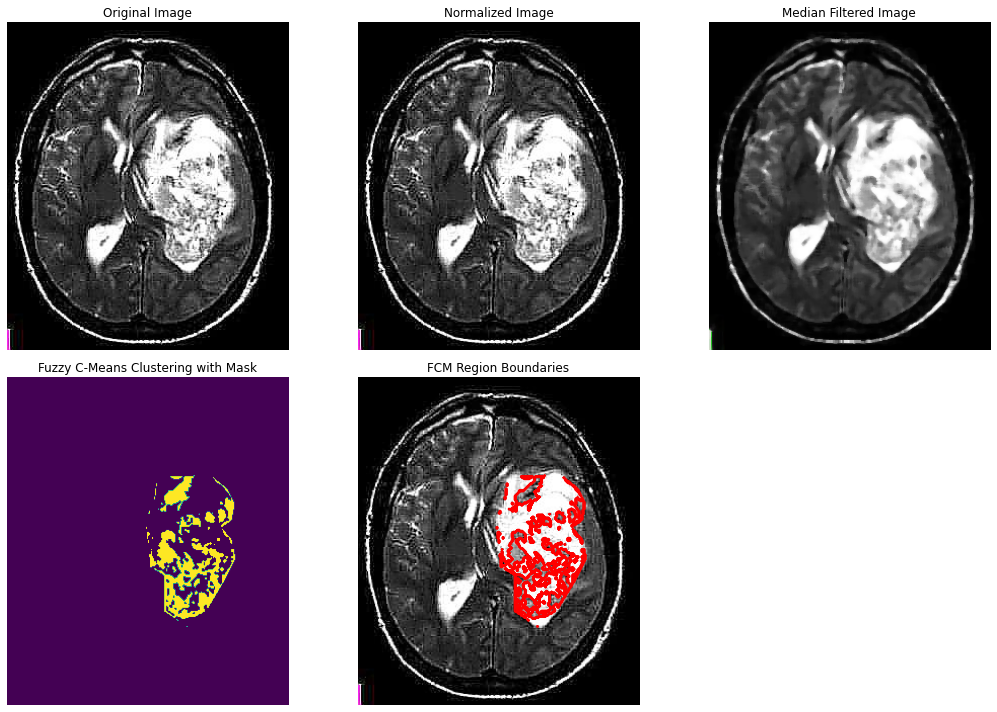

Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


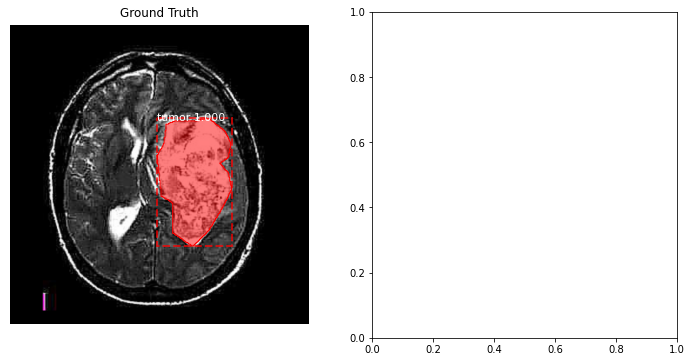

In [155]:

from skimage.segmentation import find_boundaries

def process_and_cluster_image(dataset, ind):
    original_image = dataset.load_image(ind)
    mask, _ = dataset.load_mask(ind)
    mask = mask[:, :, 0]

    normalized_image = original_image.astype(np.float32) / 255.0
    median_filtered_image = ndimage.median_filter(normalized_image, size=5)
    fcm_mask_labels = apply_fuzzy_c_means_mask(normalized_image, mask)

    # Find boundaries of the regions identified by FCM
    fcm_boundaries = find_boundaries(fcm_mask_labels, mode='inner')

    # Debugging information and plotting
    print(f"Original Image Shape: {original_image.shape}")
    print(f"Normalized Image Shape: {normalized_image.shape}")
    print(f"Median Filtered Image Shape: {median_filtered_image.shape}")
    print(f"FCM Mask Labels Shape: {fcm_mask_labels.shape}")

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(normalized_image, cmap='gray')
    plt.title('Normalized Image')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(median_filtered_image, cmap='gray')
    plt.title('Median Filtered Image')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(fcm_mask_labels, cmap='viridis')
    plt.title('Fuzzy C-Means Clustering with Mask')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(original_image)
    plt.contour(fcm_boundaries, colors='red', linewidths=1)
    plt.title('FCM Region Boundaries')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return fcm_mask_labels, fcm_boundaries

# Example usage
ind = 9
fcm_mask_labels, fcm_boundaries = process_and_cluster_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind, fcm_mask_labels, fcm_boundaries)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}
Original Image Shape: (324, 278, 3)
Normalized Image Shape: (324, 278, 3)
Median Filtered Image Shape: (324, 278, 3)
FCM Mask Labels Shape: (324, 278)


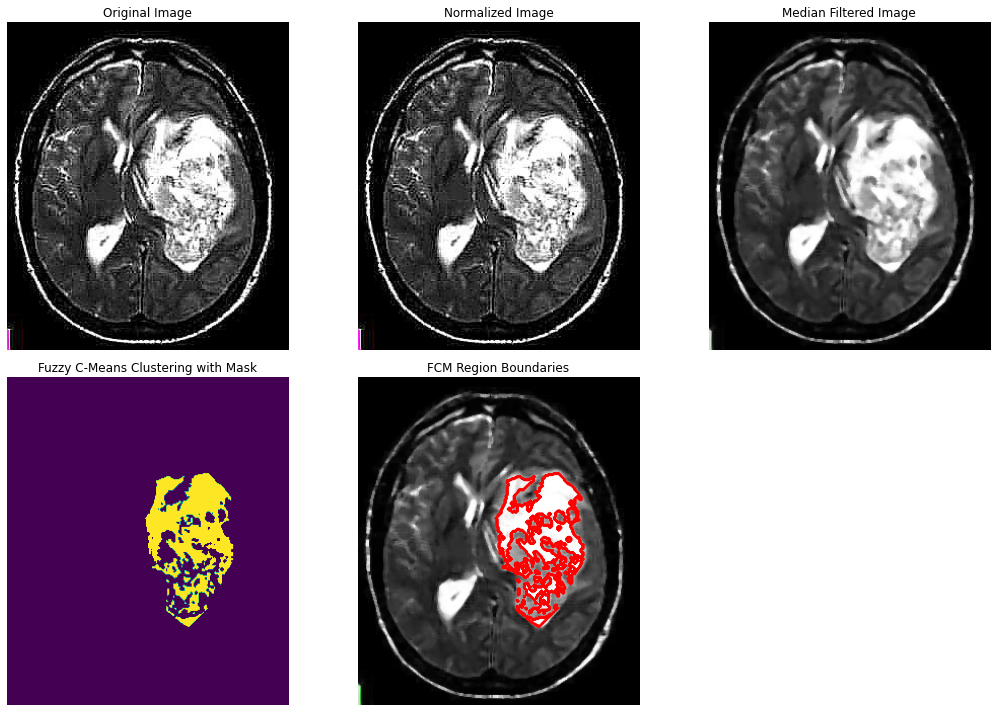

Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


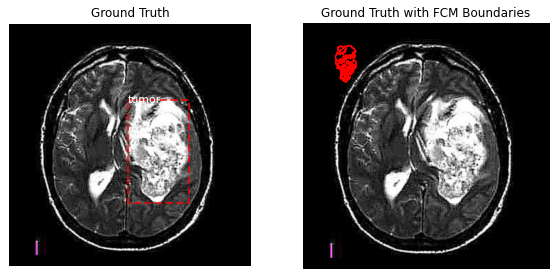

In [156]:
def apply_fuzzy_c_means_mask(image, mask):
    nonzero_indices = np.transpose(np.nonzero(mask))
    patch_size = (3, 3)
    patches = []

    for y, x in nonzero_indices:
        y_start = max(0, y - patch_size[0]//2)
        y_end = min(image.shape[0], y + patch_size[0]//2 + 1)
        x_start = max(0, x - patch_size[1]//2)
        x_end = min(image.shape[1], x + patch_size[1]//2 + 1)

        patch = image[y_start:y_end, x_start:x_end]
        patches.append(patch.flatten())

    patches_flat = np.array(patches)
    fcm = KMeans(n_clusters=2)
    fcm.fit(patches_flat)

    fcm_labels = np.zeros_like(mask, dtype=np.int32)
    for label, (y, x) in zip(fcm.labels_, nonzero_indices):
        fcm_labels[y, x] = label

    return fcm_labels

def process_and_cluster_image(dataset, ind):
    original_image = dataset.load_image(ind)
    mask, _ = dataset.load_mask(ind)
    mask = mask[:, :, 0]

    normalized_image = original_image.astype(np.float32) / 255.0
    median_filtered_image = ndimage.median_filter(normalized_image, size=5)
    fcm_mask_labels = apply_fuzzy_c_means_mask(normalized_image, mask)

    # Find boundaries of the regions identified by FCM
    fcm_boundaries = find_boundaries(fcm_mask_labels, mode='inner')

    # Debugging information and plotting
    print(f"Original Image Shape: {original_image.shape}")
    print(f"Normalized Image Shape: {normalized_image.shape}")
    print(f"Median Filtered Image Shape: {median_filtered_image.shape}")
    print(f"FCM Mask Labels Shape: {fcm_mask_labels.shape}")

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(normalized_image, cmap='gray')
    plt.title('Normalized Image')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(median_filtered_image, cmap='gray')
    plt.title('Median Filtered Image')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(fcm_mask_labels, cmap='viridis')
    plt.title('Fuzzy C-Means Clustering with Mask')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(median_filtered_image)
    plt.contour(fcm_boundaries, colors='red', linewidths=1)
    plt.title('FCM Region Boundaries')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return fcm_mask_labels, fcm_boundaries

def predict_and_plot_differences(dataset, img_id, fcm_mask_labels, fcm_boundaries):
    original_image, image_meta, gt_class_id, gt_box, gt_mask = \
        modellib.load_image_gt(dataset, config, img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    plt.figure(figsize=(15, 10))
    
    # Ground truth
    plt.subplot(2, 3, 1)
    visualize.display_instances(
        original_image,
        gt_box, np.zeros_like(gt_mask), gt_class_id,
        dataset.class_names, ax=plt.gca(),
        title="Ground Truth"
    )
    
    # Ground truth with FCM
    plt.subplot(2, 3, 2)
    plt.imshow(original_image)
    plt.contour(fcm_mask_labels, colors='red', linewidths=1)
    plt.title('Ground Truth with FCM Boundaries')
    plt.axis('off')
    

# Example usage
ind = 9
fcm_mask_labels, fcm_boundaries = process_and_cluster_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind, fcm_mask_labels, fcm_boundaries)

Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


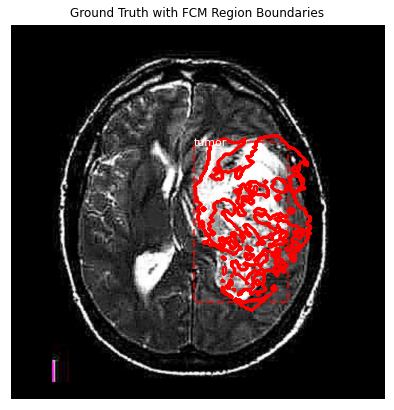

In [157]:
def predict_and_plot_differences(dataset, img_id, fcm_mask_labels, fcm_boundaries):
    original_image, image_meta, gt_class_id, gt_box, gt_mask = \
        modellib.load_image_gt(dataset, config, img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    plt.figure(figsize=(10,7))

    # Visualize ground truth instances
    visualize.display_instances(
        original_image,
        gt_box, np.zeros_like(gt_mask), gt_class_id,
        dataset.class_names,
        ax=plt.gca(),
        title="Ground Truth with FCM Region Boundaries"    
    )

    # Rotate the contour positions
    fcm_boundaries_rotated = np.flipud(fcm_boundaries)

    # Overlay FCM region boundaries
    plt.contour(fcm_boundaries_rotated, colors='red', linewidths=1, extent=(0, original_image.shape[1], original_image.shape[0], 0))
    plt.axis('off')

    plt.show()

ind = 9
predict_and_plot_differences(dataset_val, ind, fcm_mask_labels, fcm_boundaries)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}
Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


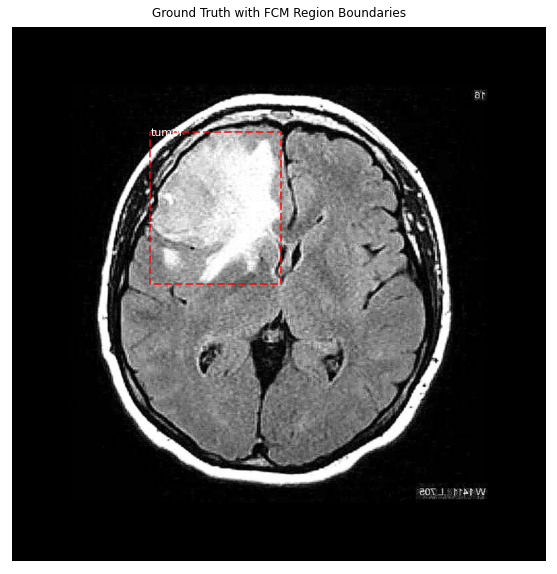

In [127]:
def predict_and_plot_differences(dataset, img_id):
    original_image = dataset.load_image(ind)
    mask, _ = dataset.load_mask(ind)
    mask = mask[:, :, 0]
    normalized_image = original_image.astype(np.float32) / 255.0
    median_filtered_image = ndimage.median_filter(normalized_image, size=5)
    fcm_mask_labels = apply_fuzzy_c_means_mask(normalized_image, mask)

    # Find boundaries of the regions identified by FCM
    fcm_boundaries = find_boundaries(fcm_mask_labels, mode='inner')
    original_image, image_meta, gt_class_id, gt_box, gt_mask = \
        modellib.load_image_gt(dataset, config, img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    plt.figure(figsize=(15, 10))

    # Visualize ground truth instances
    visualize.display_instances(
        original_image,
        gt_box, np.zeros_like(gt_mask), gt_class_id,
        dataset.class_names,
        ax=plt.gca(),
        title="Ground Truth with FCM Region Boundaries"    
    )
    plt.imshow(median_filtered_image)
    plt.contour(fcm_boundaries, colors='red', alpha=0.5)  # Adjust alpha for transparency if needed
    plt.axis('off')
    # Overlay FCM mask on original image

    plt.show()

ind = 9
predict_and_plot_differences(dataset_val, ind)

Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


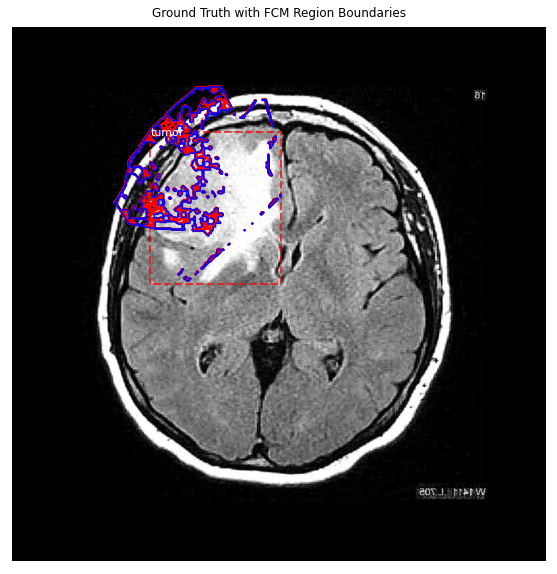

In [99]:
import cv2

def predict_and_plot_differences(dataset, img_id, fcm_mask_labels, fcm_boundaries):
    original_image, image_meta, gt_class_id, gt_box, gt_mask = \
        modellib.load_image_gt(dataset, config, img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    plt.figure(figsize=(15, 10))
    # Rotate the contour positions
    fcm_boundaries_rotated = np.flipud(fcm_boundaries)

    # Overlay FCM region boundaries
    plt.contour(fcm_boundaries_rotated, colors='red', linewidths=1, extent=(0, original_image.shape[1], original_image.shape[0], 0))
    plt.axis('off')

    # Refine the contour using morphological operations
    kernel = np.ones((5,5),np.uint8)
    fcm_boundaries_refined = cv2.morphologyEx(fcm_boundaries_rotated.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    # Overlay refined contour
    plt.contour(fcm_boundaries_refined, alpha=0.4, colors='blue', linewidths=1, extent=(1, original_image.shape[1], original_image.shape[0], 1))

    # Visualize ground truth instances
    visualize.display_instances(
        original_image,
        gt_box, np.zeros_like(gt_mask), gt_class_id,
        dataset.class_names,
        ax=plt.gca(),
        title="Ground Truth with FCM Region Boundaries"    
    )


    plt.show()

# Example usage
ind = 9
predict_and_plot_differences(dataset_val, ind, fcm_mask_labels, fcm_boundaries)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}
Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


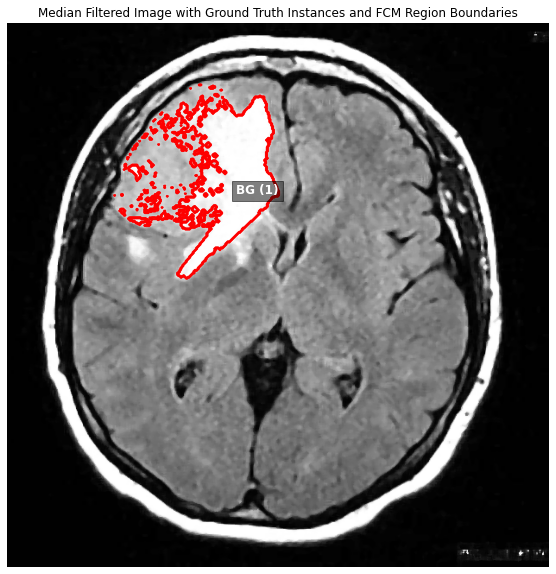

In [70]:
def predict_and_plot_differences(dataset, img_id):
    original_image = dataset.load_image(img_id)
    mask, _ = dataset.load_mask(img_id)
    mask = mask[:, :, 0]
    normalized_image = original_image.astype(np.float32) / 255.0
    median_filtered_image = ndimage.median_filter(normalized_image, size=5)
    fcm_mask_labels = apply_fuzzy_c_means_mask(normalized_image, mask)

    # Find boundaries of the regions identified by FCM
    fcm_boundaries = find_boundaries(fcm_mask_labels, mode='inner')
    original_image, image_meta, gt_class_id, gt_box, gt_mask = \
        modellib.load_image_gt(dataset, config, img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    plt.figure(figsize=(15, 10))

    # Overlay FCM mask on median filtered image
    plt.imshow(median_filtered_image)
    plt.contour(fcm_boundaries, colors='red', alpha=0.5)  # Adjust alpha for transparency if needed

    # Display ground truth instances
    for bbox, class_id, class_name in zip(gt_box, gt_class_id, dataset.class_names):
        y1, x1, y2, x2 = bbox
        plt.text(x1, y1, f'{class_name} ({class_id})', color='white', fontsize=12, fontweight='bold', bbox=dict(facecolor='black', alpha=0.5))

    plt.axis('off')
    plt.title("Median Filtered Image with Ground Truth Instances and FCM Region Boundaries")
    plt.show()

ind = 9
predict_and_plot_differences(dataset_val, ind)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}
Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


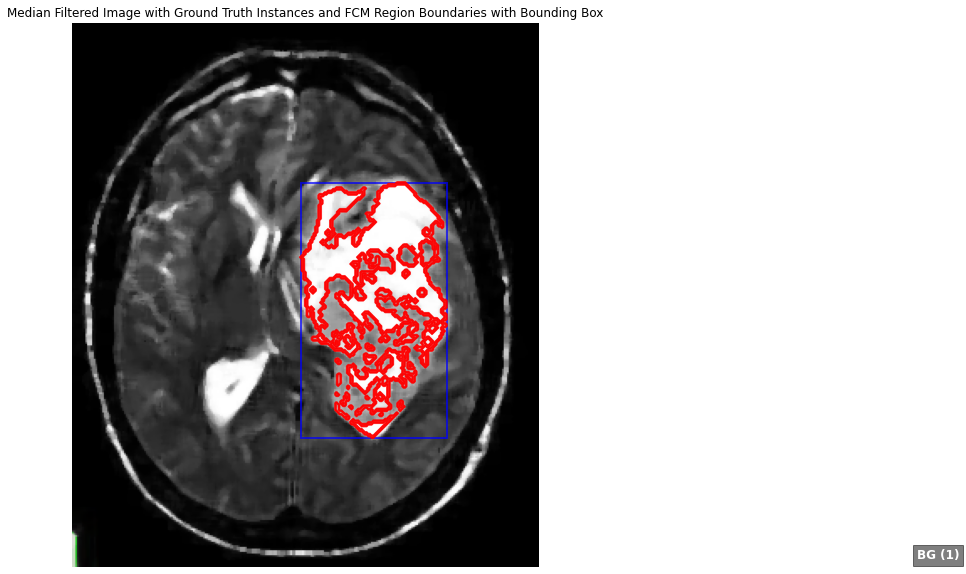

In [125]:
import matplotlib.patches as patches

def predict_and_plot_differences(dataset, img_id):
    original_image = dataset.load_image(img_id)
    mask, _ = dataset.load_mask(img_id)
    mask = mask[:, :, 0]
    normalized_image = original_image.astype(np.float32) / 255.0
    median_filtered_image = ndimage.median_filter(normalized_image, size=5)
    fcm_mask_labels = apply_fuzzy_c_means_mask(normalized_image, mask)

    # Find boundaries of the regions identified by FCM
    fcm_boundaries = find_boundaries(fcm_mask_labels, mode='inner')
    original_image, image_meta, gt_class_id, gt_box, gt_mask = \
        modellib.load_image_gt(dataset, config, img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    plt.figure(figsize=(15, 10))

    # Overlay FCM mask on median filtered image
    plt.imshow(median_filtered_image, cmap='gray')
    plt.contour(fcm_boundaries, colors='red', alpha=0.5)  # Adjust alpha for transparency if needed

    # Find contours of FCM boundaries
    contours, _ = cv2.findContours(fcm_boundaries.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate bounding box that encloses all contours
    all_contours = np.concatenate(contours)
    x, y, w, h = cv2.boundingRect(all_contours)
    rect = patches.Rectangle((x, y), w, h, edgecolor='blue', linewidth=2, alpha=0.7, fill=False)  # Create rectangle patch
    plt.gca().add_patch(rect)  # Add rectangle to the plot

    # Display ground truth instances
    for bbox, class_id, class_name in zip(gt_box, gt_class_id, dataset.class_names):
        y1, x1, y2, x2 = bbox
        plt.text(x1, y1, f'{class_name} ({class_id})', color='white', fontsize=12, fontweight='bold', bbox=dict(facecolor='black', alpha=0.5))
        # plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color='lime', linewidth=2, alpha=0.7)  # Plot ground truth bounding box

    plt.axis('off')
    plt.title("Median Filtered Image with Ground Truth Instances and FCM Region Boundaries with Bounding Box")
    plt.show()

ind = 9
predict_and_plot_differences(dataset_val, ind)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


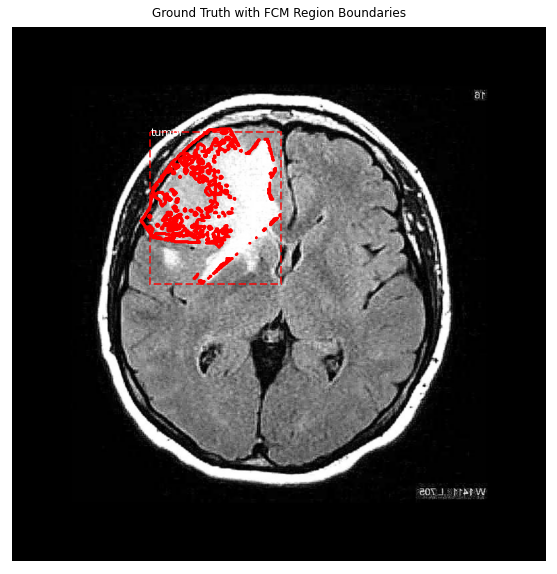

In [150]:
import cv2

def predict_and_plot_differences(dataset, img_id, fcm_mask_labels, fcm_boundaries):
    original_image, image_meta, gt_class_id, gt_box, gt_mask = \
        modellib.load_image_gt(dataset, config, img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    plt.figure(figsize=(15, 10))
    
    # Pad the contour image with zeros on the left side
    padded_contour = np.pad(fcm_boundaries, ((80, 80), (60, 60)), mode='constant')
    
    # Convert contour image to compatible data type
    padded_contour_uint8 = (padded_contour * 255).astype(np.uint8)
    
    # Resize the padded contour image to match the original image size
    fcm_boundaries_resized = cv2.resize(padded_contour_uint8, (original_image.shape[0], original_image.shape[1]))

    # Overlay FCM region boundaries
    plt.contour(fcm_boundaries_resized, colors='red', linewidths=1)
    plt.axis('off')

    # Visualize ground truth instances
    visualize.display_instances(
        original_image,
        gt_box, np.zeros_like(gt_mask), gt_class_id,
        dataset.class_names,
        ax=plt.gca(),
        title="Ground Truth with FCM Region Boundaries"    
    )

    plt.show()

# Example usage
ind = 9
predict_and_plot_differences(dataset_val, ind, fcm_mask_labels, fcm_boundaries)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}
Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


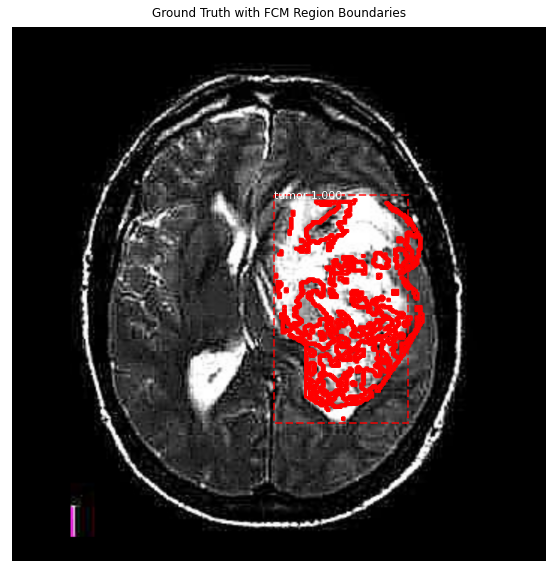

In [161]:
import cv2

def predict_and_plot_differences(dataset, img_id):
    # Load original image and mask
    original_image = dataset.load_image(img_id)
    mask, _ = dataset.load_mask(img_id)
    mask = mask[:, :, 0]
    
    # Preprocess original image
    normalized_image = original_image.astype(np.float32) / 255.0
    median_filtered_image = ndimage.median_filter(normalized_image, size=5)
    
    # Apply Fuzzy C-means clustering to get mask labels
    fcm_mask_labels = apply_fuzzy_c_means_mask(normalized_image, mask)

    # Find boundaries of the regions identified by FCM
    fcm_boundaries = find_boundaries(fcm_mask_labels, mode='inner')

    # Load ground truth instances
    original_image, image_meta, gt_class_id, gt_box, gt_mask = \
        modellib.load_image_gt(dataset, config, img_id, use_mini_mask=False)

    # Detect instances in the original image
    results = model.detect([original_image], verbose=0)
    r = results[0]

    plt.figure(figsize=(15, 10))
    
    # Pad the contour image with zeros on the left side
    padded_contour = np.pad(fcm_boundaries, ((20, 20), (20, 20)), mode='constant')
    
    # Convert contour image to compatible data type
    padded_contour_uint8 = (padded_contour * 255).astype(np.uint8)
    
    # Resize the padded contour image to match the original image size
    fcm_boundaries_resized = cv2.resize(padded_contour_uint8, (original_image.shape[0], original_image.shape[1]))

    # Overlay FCM region boundaries
    plt.contour(fcm_boundaries_resized, colors='red', linewidths=1)
    plt.axis('off')

    # Visualize ground truth instances
    visualize.display_instances(
        original_image,
        gt_box, np.zeros_like(gt_mask), gt_class_id,
        dataset.class_names,r['scores'],
        ax=plt.gca(),
        title="Ground Truth with FCM Region Boundaries"    
    )

    plt.show()

# Example usage
ind = 9
predict_and_plot_differences(dataset_val, ind)


In [2]:
import os
import sys
import skimage.io
import numpy as np
import json
import skimage.draw
import matplotlib.pyplot as plt
import ssl
from sklearn.cluster import KMeans
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
import scipy.ndimage as ndimage
import skimage.filters as filters
from mrcnn import visualize
from mrcnn import visualize
# Root directory of the project
ROOT_DIR = os.path.abspath("D:/Mask_RCNN-master/")
sys.path.append(ROOT_DIR)

# Create directory for logs and trained weights if it doesn't exist
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

ssl._create_default_https_context = ssl._create_unverified_context
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))
plt.rcParams['figure.facecolor'] = 'white'


def get_ax(rows=1, cols=1, size=7):
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax


# Import Mask RCNN COCO trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

DATASET_DIR = "D:/Mask_RCNN-master/Br35H-Mask-RCNN/"


class TumorConfig(Config):
    NAME = 'tumor_detector'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # background + tumor
    DETECTION_MIN_CONFIDENCE = 0.85
    STEPS_PER_EPOCH = 5
    LEARNING_RATE = 0.001


config = TumorConfig()


class BrainScanDataset(utils.Dataset):
    def load_brain_scan(self, dataset_dir, subset):
        self.add_class("tumor", 1, "tumor")
        assert subset in ["TRAIN", "VAL", "TEST"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations = json.load(open(os.path.join(DATASET_DIR, subset, 'annotations_' + subset + '.json')))
        annotations = list(annotations.values())
        annotations = [a for a in annotations if a['regions']]
        for a in annotations:
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            image = image.astype(np.float32) / 255.0
            image = ndimage.median_filter(image, size=3)
            image = filters.unsharp_mask(image, radius=1.0, amount=1.5)
            height, width = image.shape[:2]
            self.add_image(
                "tumor",
                image_id=a['filename'],
                path=image_path,
                width=width,
                height=height,
                polygons=polygons
            )

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "tumor":
            return super(self.__class__, self).load_mask(image_id)
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            print("Polygon:", p)
            if 'all_points_y' not in p or 'all_points_x' not in p:
                print("Invalid polygon format:", p)
                continue
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [3]:

dataset_train = BrainScanDataset()
dataset_train.load_brain_scan(DATASET_DIR, 'TRAIN')
dataset_train.prepare()

dataset_val = BrainScanDataset()
dataset_val.load_brain_scan(DATASET_DIR, 'VAL')
dataset_val.prepare()


In [4]:
import imgaug.augmenters as iaa

# Define augmentation pipeline
augmentation = iaa.Sometimes(.667, iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontal flips
    iaa.Crop(percent=(0, 0.1)),  # random crops
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.25))),  # Gaussian blur
    iaa.ContrastNormalization((0.75, 1.5)),  # contrast normalization
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255)),  # additive Gaussian noise
    iaa.Multiply((0.8, 1.2)),  # brightness adjustment
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # scale/zoom
        rotate=(-180, 180),  # rotation
    )
], random_order=True))


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [5]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [6]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/5,
            epochs=100,
            layers='heads',
            augmentation=augmentation)  ## no need to augment yet




Starting at epoch 0. LR=0.0002

Checkpoint Path: D:\Mask_RCNN-master\tumor_detector20240529T1453\mask_rcnn_tumor_detector_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/100
Polygon: {'name': 'polygon', 'all_points_x': [91, 97, 99, 99, 103, 103, 91, 83, 68, 61, 58, 51, 47, 53, 63, 77], 'all_points_y': [236, 228, 217, 207, 199, 183, 175, 163, 166, 174, 180, 194, 219, 225, 233, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:17 - loss: 6.2280 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.6261 - mrcnn_class_loss: 2.5662 - mrcnn_bbox_loss: 0.7415 - mrcnn_mask_loss: 2.2928Polygon: {'name': 'polygon', 'all_points_x': [245, 227, 216, 201, 185, 167, 142, 133, 130, 133, 142, 159, 181, 200, 219, 230, 231, 238, 242, 243], 'all_points_y': [187, 179, 171, 168, 170, 171, 175, 183, 198, 207, 228, 249, 260, 264, 265, 258, 244, 225, 213, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:38 - loss: 6.0368 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.4457 - mrcnn_class_loss: 2.4721 - mrcnn_bbox_loss: 0.7519 - mrcnn_mask_loss: 2.3618Polygon: {'name': 'polygon', 'all_points_x': [43, 64, 86, 107, 119, 119, 117, 109, 99, 73, 67, 56, 49], 'all_points_y': [155, 145, 143, 135, 151, 171, 191, 197, 183, 181, 201, 205, 180]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:04 - loss: 7.5064 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.9362 - mrcnn_class_loss: 2.3274 - mrcnn_bbox_loss: 0.9758 - mrcnn_mask_loss: 2.2536Polygon: {'name': 'polygon', 'all_points_x': [102, 71, 36, 25, 27, 37, 49, 72, 94, 107, 115, 126, 126, 116], 'all_points_y': [103, 94, 128, 143, 166, 188, 208, 219, 217, 207, 186, 167, 149, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 32s - loss: 7.1558 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 1.6642 - mrcnn_class_loss: 2.0618 - mrcnn_bbox_loss: 0.9175 - mrcnn_mask_loss: 2.5013 Polygon: {'name': 'polygon', 'all_points_x': [90, 98, 93, 85, 66, 53, 56, 73], 'all_points_y': [172, 194, 213, 216, 209, 202, 181, 173]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry':

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'po

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 660s 132s/step - loss: 8.3544 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 3.7830 - mrcnn_class_loss: 1.7801 - mrcnn_bbox_loss: 0.7340 - mrcnn_mask_loss: 2.0010 - val_loss: 5.3575 - val_rpn_class_loss: 0.0202 - val_rpn_bbox_loss: 2.3573 - val_mrcnn_class_loss: 0.5939 - val_mrcnn_bbox_loss: 0.6552 - val_mrcnn_mask_loss: 1.7310

Epoch 2/100
Polygon: {'name': 'polygon', 'all_points_x': [241, 233, 241, 220, 200, 195, 182, 180, 157, 156, 138, 111, 95, 98, 111, 130, 139, 154, 168, 171, 183, 185, 202, 218, 235], 'all_points_y': [297, 280, 251, 230, 228, 239, 229, 218, 224, 253, 266, 271, 278, 306, 321, 327, 343, 359, 351, 334, 327, 316, 306, 316, 310]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:05 - loss: 5.1584 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 1.9638 - mrcnn_class_loss: 0.5953 - mrcnn_bbox_loss: 1.0254 - mrcnn_mask_loss: 1.5557Polygon: {'name': 'polygon', 'all_points_x': [157, 158, 139, 103, 95, 101, 114, 132, 146, 160, 171, 170, 186, 191, 201, 214, 228, 242, 234, 242, 228, 208, 200, 185, 181], 'all_points_y': [222, 247, 268, 271, 283, 321, 329, 329, 355, 355, 348, 330, 331, 305, 304, 316, 312, 293, 278, 248, 232, 226, 237, 233, 218]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:35 - loss: 5.0473 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 1.6096 - mrcnn_class_loss: 0.5191 - mrcnn_bbox_loss: 0.9702 - mrcnn_mask_loss: 1.9377Polygon: {'name': 'polygon', 'all_points_x': [271, 252, 228, 219, 215, 222, 247, 263, 279, 286, 273], 'all_points_y': [222, 221, 224, 250, 268, 289, 310, 307, 274, 250, 234]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:04 - loss: 4.6791 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 2.3021 - mrcnn_class_loss: 0.3871 - mrcnn_bbox_loss: 0.6468 - mrcnn_mask_loss: 1.2918Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 88, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 88, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 92, 'cy': 171, 'rx': 16, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 92, 'cy': 171, 'rx': 16, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [109, 114, 123, 125, 132, 125, 106, 79, 75, 45, 56, 64, 55, 66, 85], 'all_points_y': [203, 184, 179, 165, 154, 135, 134, 119, 132, 145, 164, 167, 181, 196, 202]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 32s - loss: 4.4652 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 1.7448 - mrcnn_class_loss: 0.3231 - mrcnn_bbox_loss: 0.6920 - mrcnn_mask_loss: 1.6666 Polygon: {'name': 'polygon', 'all_points_x': [272, 261, 264, 269, 257, 253, 269, 290, 316, 343, 300, 292, 278, 280], 'all_points_y': [239, 248, 277, 303, 334, 366, 385, 378, 365, 340, 311, 281, 261, 244]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 664s 133s/step - loss: 5.5308 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 3.3063 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.5536 - mrcnn_mask_loss: 1.3333 - val_loss: 4.2880 - val_rpn_class_loss: 0.0183 - val_rpn_bbox_loss: 1.5281 - val_mrcnn_class_loss: 0.0634 - val_mrcnn_bbox_loss: 0.6995 - val_mrcnn_mask_loss: 1.9786
Epoch 3/100
Polygon: {'name': 'polygon', 'all_points_x': [181, 190, 193, 199, 202, 192, 179, 170, 160, 155, 160, 152, 155, 166], 'all_points_y': [165, 153, 139, 129, 112, 100, 102, 105, 106, 120, 131, 141, 160, 168]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:12 - loss: 3.7895 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 1.4759 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.5981 - mrcnn_mask_loss: 1.6645Polygon: {'name': 'polygon', 'all_points_x': [245, 234, 219, 206, 191, 177, 163, 154, 141, 135, 131, 129, 128, 127, 130, 139, 143, 146, 157, 166, 183, 217, 229, 234, 239, 245], 'all_points_y': [188, 182, 173, 168, 167, 171, 171, 179, 174, 181, 189, 198, 206, 219, 235, 243, 260, 272, 277, 273, 265, 265, 265, 249, 227, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:39 - loss: 4.4467 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 1.6571 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.8284 - mrcnn_mask_loss: 1.8728Polygon: {'name': 'polygon', 'all_points_x': [143, 138, 133, 131, 131, 134, 138, 142, 148, 152, 154, 156, 159, 160, 153, 150, 146], 'all_points_y': [37, 40, 45, 50, 56, 59, 63, 65, 64, 63, 60, 57, 54, 51, 49, 45, 40]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:06 - loss: 5.0391 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 3.1335 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.5523 - mrcnn_mask_loss: 1.2486Polygon: {'name': 'polygon', 'all_points_x': [194, 181, 169, 153, 139, 129, 129, 142, 144, 153, 164, 180, 192, 201, 209, 213, 217, 217, 215, 209, 203, 200], 'all_points_y': [165, 166, 173, 183, 184, 200, 213, 220, 228, 239, 248, 250, 247, 240, 231, 223, 212, 201, 187, 179, 173, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 33s - loss: 4.5407 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 2.4489 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.5386 - mrcnn_mask_loss: 1.4687 Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 274, 'rx': 51, 'ry': 53, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 274, 'rx': 51, 'ry': 53, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [119, 139, 184, 179, 227, 259, 253, 283, 312, 305, 263, 250, 212, 188, 185, 136, 126, 119, 108, 109], 'all_points_y': [219, 220, 207, 184, 175, 202, 233, 274, 309, 347, 365, 398, 386, 378, 400, 402, 343, 299, 262, 233]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235,

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 670s 134s/step - loss: 4.4572 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 2.0911 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.7182 - mrcnn_mask_loss: 1.5514 - val_loss: 4.5764 - val_rpn_class_loss: 0.0157 - val_rpn_bbox_loss: 1.9252 - val_mrcnn_class_loss: 0.0468 - val_mrcnn_bbox_loss: 0.8049 - val_mrcnn_mask_loss: 1.7838
Epoch 4/100
Polygon: {'name': 'polygon', 'all_points_x': [77, 67, 56, 49, 44, 39, 40, 48, 54, 64, 78, 87, 94, 98, 96, 89], 'all_points_y': [103, 102, 105, 113, 121, 132, 141, 152, 160, 166, 166, 160, 148, 135, 122, 112]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:12 - loss: 4.8312 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 1.8603 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.3854 - mrcnn_mask_loss: 2.5644Polygon: {'name': 'polygon', 'all_points_x': [30, 17, 14, 10, 12, 21, 35, 46, 49, 49, 43], 'all_points_y': [58, 67, 85, 100, 118, 123, 115, 103, 88, 74, 63]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:40 - loss: 3.7522 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 2.2633 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.1927 - mrcnn_mask_loss: 1.2822Polygon: {'name': 'polygon', 'all_points_x': [255, 224, 204, 196, 190, 196, 211, 222, 240, 255, 259, 258], 'all_points_y': [109, 106, 109, 121, 138, 159, 172, 176, 178, 177, 150, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:06 - loss: 3.4351 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 1.6824 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 1.5209Polygon: {'name': 'polygon', 'all_points_x': [243, 225, 206, 198, 203, 217, 232, 238, 242], 'all_points_y': [208, 200, 199, 211, 229, 234, 231, 225, 217]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 33s - loss: 3.6645 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 2.3350 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.1633 - mrcnn_mask_loss: 1.1407 Polygon: {'name': 'polygon', 'all_points_x': [41, 48, 49, 58, 65, 74, 84, 91, 96, 95, 88, 85, 85, 88, 84, 81, 75, 72, 59, 55, 48, 44, 40, 37, 33, 32, 31, 35, 37], 'all_points_y': [55, 58, 61, 61, 62, 65, 69, 78, 87, 92, 92, 97, 102, 104, 110, 114, 113, 116, 110, 107, 106, 100, 94, 88, 84, 76, 69, 61, 57]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 669s 134s/step - loss: 3.3937 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 1.9495 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.2337 - mrcnn_mask_loss: 1.1805 - val_loss: 3.6492 - val_rpn_class_loss: 0.0165 - val_rpn_bbox_loss: 1.5231 - val_mrcnn_class_loss: 0.0512 - val_mrcnn_bbox_loss: 0.6801 - val_mrcnn_mask_loss: 1.3784
Epoch 5/100
Polygon: {'name': 'polygon', 'all_points_x': [65, 81, 97, 106, 109, 116, 122, 128, 133, 136, 126, 108, 96, 89, 77, 64, 59, 53, 50, 48, 43, 39, 39, 49, 57], 'all_points_y': [77, 75, 75, 80, 89, 97, 109, 113, 129, 142, 149, 153, 158, 164, 169, 163, 157, 152, 144, 136, 127, 110, 100, 88, 83]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:09 - loss: 5.2150 - rpn_class_loss: 4.3921e-04 - rpn_bbox_loss: 2.1851 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.9655 - mrcnn_mask_loss: 2.0166Polygon: {'name': 'polygon', 'all_points_x': [41, 63, 85, 88, 112, 137, 151, 161, 164, 159, 159, 151, 133, 119, 98, 77, 63, 56, 46, 41], 'all_points_y': [177, 165, 156, 144, 147, 157, 173, 198, 219, 230, 253, 269, 293, 292, 283, 283, 260, 237, 211, 191]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:37 - loss: 3.8091 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 1.2942 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.7489 - mrcnn_mask_loss: 1.7101    Polygon: {'name': 'polygon', 'all_points_x': [71, 77, 78, 89, 102, 119, 128, 129, 133, 128, 123, 121, 107, 97, 87, 81, 74, 64, 56, 51, 51, 53, 51, 47, 46, 47, 53, 61, 65, 67], 'all_points_y': [90, 86, 80, 80, 76, 89, 102, 116, 132, 142, 154, 162, 168, 170, 172, 165, 165, 155, 146, 140, 137, 132, 123, 118, 108, 100, 96, 92, 96, 92]}
Polygon: {'name': 'polygon', 'all_points_x': [66, 66, 68, 75, 81, 83, 86, 89, 91, 95, 99, 107, 111, 115, 116, 117, 116, 114, 109, 102, 94, 87, 83, 77, 72, 67, 65, 67, 69, 73, 73, 66], 'all_points_y': [117, 109, 104, 103, 101, 93, 91, 99, 104, 108, 110, 109, 110, 120, 125, 134, 143, 149, 153, 156, 157, 157, 155, 151, 147, 141, 137, 133, 129, 126, 123, 118]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:05 - loss: 3.6130 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 1.1701 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.7549 - mrcnn_mask_loss: 1.6165Polygon: {'name': 'polygon', 'all_points_x': [38, 59, 80, 92, 93, 78, 65, 48, 38, 27, 27, 25, 36], 'all_points_y': [97, 91, 101, 116, 136, 149, 159, 167, 168, 151, 127, 107, 109]}
Polygon: {'name': 'ellipse', 'cx': 70, 'cy': 126, 'rx': 19, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 70, 'cy': 126, 'rx': 19, 'ry': 23, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 50, 'cy': 152, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 50, 'cy': 152, 'rx': 9, 'ry': 10, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 32s - loss: 3.2675 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 1.0053 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.6152 - mrcnn_mask_loss: 1.5895 Polygon: {'name': 'polygon', 'all_points_x': [141, 134, 138, 133, 105, 84, 77, 74, 84, 104, 118, 131, 129, 142, 144, 148, 154, 155, 147], 'all_points_y': [158, 161, 171, 176, 172, 180, 203, 236, 259, 266, 276, 268, 255, 245, 218, 208, 199, 179, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygo

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 668s 134s/step - loss: 3.2734 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.9735 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.7295 - mrcnn_mask_loss: 1.5107 - val_loss: 3.4195 - val_rpn_class_loss: 0.0162 - val_rpn_bbox_loss: 1.5697 - val_mrcnn_class_loss: 0.0457 - val_mrcnn_bbox_loss: 0.6974 - val_mrcnn_mask_loss: 1.0905
Epoch 6/100
Polygon: {'name': 'polygon', 'all_points_x': [52, 62, 76, 88, 91, 88, 83, 78, 67, 58, 51, 49], 'all_points_y': [204, 200, 196, 201, 210, 218, 224, 233, 233, 230, 224, 213]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:10 - loss: 6.9208 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 3.8178 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 1.4659 - mrcnn_mask_loss: 1.5731Polygon: {'name': 'polygon', 'all_points_x': [226, 205, 214, 200, 175, 158, 155, 166, 174, 200, 223, 228], 'all_points_y': [216, 204, 200, 191, 205, 223, 246, 267, 281, 268, 244, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:42 - loss: 4.8309 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 2.0825 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 1.1086 - mrcnn_mask_loss: 1.5967Polygon: {'name': 'polygon', 'all_points_x': [52, 48, 45, 54, 80, 108, 118, 119, 115, 103, 96, 71, 67, 57], 'all_points_y': [145, 171, 189, 201, 206, 212, 191, 169, 152, 155, 166, 167, 146, 141]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:13 - loss: 4.4264 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.9873 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 1.0978 - mrcnn_mask_loss: 1.3089Polygon: {'name': 'polygon', 'all_points_x': [702, 674, 621, 565, 524, 506, 506, 522, 551, 600, 632, 674, 717], 'all_points_y': [227, 194, 174, 165, 193, 232, 271, 321, 354, 367, 359, 337, 264]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 58:50 - loss: 4.0449 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 2.2146 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.8233 - mrcnn_mask_loss: 0.9816Polygon: {'name': 'polygon', 'all_points_x': [55, 71, 86, 97, 108, 117, 135, 137, 143, 138, 141, 144, 147, 144, 144, 136, 129, 126, 133, 122, 97, 84, 67, 53, 44, 39, 32, 26, 23, 21, 22, 20, 34, 45, 65], 'all_points_y': [154, 151, 150, 155, 163, 175, 206, 221, 227, 237, 247, 255, 273, 281, 286, 291, 291, 303, 316, 323, 330, 326, 314, 303, 291, 278, 265, 244, 225, 207, 185, 168, 164, 159, 152]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 14764s 2953s/step - loss: 3.8200 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 1.8627 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.7379 - mrcnn_mask_loss: 1.1974 - val_loss: 3.0306 - val_rpn_class_loss: 0.0164 - val_rpn_bbox_loss: 1.4298 - val_mrcnn_class_loss: 0.0462 - val_mrcnn_bbox_loss: 0.6258 - val_mrcnn_mask_loss: 0.9124
Epoch 7/100
Polygon: {'name': 'polygon', 'all_points_x': [98, 98, 89, 77, 63, 50, 49, 54, 66, 58, 60, 69, 84, 89, 94, 102, 104, 102, 98], 'all_points_y': [211, 227, 235, 234, 227, 218, 204, 195, 192, 182, 173, 163, 163, 166, 174, 181, 191, 206, 212]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:21 - loss: 2.3261 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.4052 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.8390 - mrcnn_mask_loss: 1.0171Polygon: {'name': 'polygon', 'all_points_x': [434, 424, 410, 396, 379, 370, 359, 358, 364, 376, 389, 408, 420, 426, 433, 434], 'all_points_y': [217, 210, 200, 196, 207, 221, 233, 250, 268, 274, 284, 282, 270, 252, 239, 227]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:46 - loss: 2.5808 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.2217 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.8601 - mrcnn_mask_loss: 1.4514Polygon: {'name': 'polygon', 'all_points_x': [247, 234, 222, 213, 199, 188, 174, 165, 165, 170, 171, 167, 167, 171, 188, 205, 221, 225, 234, 237, 245, 249, 253, 256, 251], 'all_points_y': [168, 167, 158, 145, 136, 135, 135, 143, 154, 159, 170, 182, 192, 209, 214, 215, 222, 235, 231, 215, 205, 193, 187, 177, 172]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:10 - loss: 2.5056 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.3237 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.8635 - mrcnn_mask_loss: 1.2790Polygon: {'name': 'ellipse', 'cx': 96, 'cy': 144, 'rx': 16, 'ry': 18.788, 'theta': -2.702}
Invalid polygon format: {'name': 'ellipse', 'cx': 96, 'cy': 144, 'rx': 16, 'ry': 18.788, 'theta': -2.702}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 247, 'rx': 34.724, 'ry': 32, 'theta': 0.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 247, 'rx': 34.724, 'ry': 32, 'theta': 0.058}
Polygon: {'name': 'polygon', 'all_points_x': [247, 218, 198, 179, 159, 143, 135, 121, 131, 149, 164, 178, 183, 199, 211, 224, 235, 243, 247], 'all_points_y': [216, 206, 207, 196, 207, 210, 228, 237, 253, 265, 297, 304, 314, 313, 308, 292, 275, 254, 233]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 35s - loss: 2.6859 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.4448 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.9376 - mrcnn_mask_loss: 1.2456 Polygon: {'name': 'polygon', 'all_points_x': [196, 183, 175, 171, 171, 177, 177, 172, 164, 161, 159, 159, 156, 159, 164, 172, 179, 188, 198, 205, 209, 211, 214, 218, 217, 216, 216, 213, 213, 209, 210, 207, 201, 197], 'all_points_y': [103, 109, 115, 123, 135, 139, 145, 153, 151, 161, 171, 178, 196, 204, 213, 214, 213, 215, 217, 209, 199, 190, 181, 177, 170, 159, 151, 144, 137, 134, 126, 119, 110, 104]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 719s 144s/step - loss: 2.6379 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4948 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.8923 - mrcnn_mask_loss: 1.1755 - val_loss: 2.8936 - val_rpn_class_loss: 0.0111 - val_rpn_bbox_loss: 1.0567 - val_mrcnn_class_loss: 0.0651 - val_mrcnn_bbox_loss: 0.7613 - val_mrcnn_mask_loss: 0.9994
Epoch 8/100
Polygon: {'name': 'polygon', 'all_points_x': [101, 90, 70, 48, 44, 42, 64, 76, 76, 74, 64, 57, 75, 94, 100, 94, 92, 98, 100], 'all_points_y': [97, 87, 86, 88, 103, 114, 114, 121, 133, 149, 154, 163, 172, 167, 156, 147, 135, 125, 110]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:22 - loss: 2.0737 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.4289 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.8510 - mrcnn_mask_loss: 0.7854Polygon: {'name': 'polygon', 'all_points_x': [142, 131, 114, 89, 73, 65, 65, 71, 87, 103, 116, 124], 'all_points_y': [153, 129, 115, 115, 124, 144, 170, 186, 194, 202, 190, 179]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:45 - loss: 2.3014 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.5324 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.8136 - mrcnn_mask_loss: 0.9234Polygon: {'name': 'polygon', 'all_points_x': [191, 177, 164, 153, 149, 149, 154, 157, 167, 177, 185, 198, 209, 219, 224, 235, 237, 239, 236, 228, 221, 213, 206], 'all_points_y': [36, 43, 53, 80, 109, 124, 133, 137, 145, 143, 141, 143, 144, 140, 131, 112, 103, 88, 79, 68, 58, 49, 44]}
Polygon: {'name': 'polygon', 'all_points_x': [115, 104, 93, 84, 79, 75, 72, 72, 77, 85, 91, 96, 102, 109, 115, 115], 'all_points_y': [87, 79, 78, 85, 95, 105, 112, 121, 125, 127, 126, 123, 117, 109, 101, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:10 - loss: 2.3153 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 0.4682 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.8618 - mrcnn_mask_loss: 0.8924Polygon: {'name': 'polygon', 'all_points_x': [218, 196, 171, 158, 160, 181, 199, 224, 243, 238, 234, 226], 'all_points_y': [72, 80, 102, 119, 146, 162, 178, 181, 178, 144, 121, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 35s - loss: 2.5626 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 0.7982 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.7566 - mrcnn_mask_loss: 0.9222 Polygon: {'name': 'polygon', 'all_points_x': [191, 179, 171, 164, 161, 155, 151, 155, 157, 162, 171, 183, 196, 202, 203, 208, 209, 204, 197], 'all_points_y': [91, 93, 95, 103, 112, 120, 129, 137, 145, 149, 156, 153, 149, 143, 132, 126, 115, 106, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name':

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 720s 144s/step - loss: 2.4255 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.6462 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.7673 - mrcnn_mask_loss: 0.9379 - val_loss: 2.7410 - val_rpn_class_loss: 0.0162 - val_rpn_bbox_loss: 1.1764 - val_mrcnn_class_loss: 0.0577 - val_mrcnn_bbox_loss: 0.6968 - val_mrcnn_mask_loss: 0.7938
Epoch 9/100
Polygon: {'name': 'polygon', 'all_points_x': [67, 84, 110, 142, 157, 159, 152, 144, 115, 85, 59, 49, 50, 56], 'all_points_y': [84, 92, 102, 111, 125, 151, 172, 190, 190, 189, 181, 160, 135, 111]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:22 - loss: 1.7940 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1310 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.8863 - mrcnn_mask_loss: 0.7175Polygon: {'name': 'polygon', 'all_points_x': [131, 85, 70, 53, 58, 70, 69, 92, 119, 111, 101, 94, 112, 115, 99, 116, 129, 127], 'all_points_y': [168, 136, 141, 173, 197, 206, 223, 244, 242, 234, 231, 207, 220, 211, 204, 188, 196, 181]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:46 - loss: 2.3417 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6651 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.8875 - mrcnn_mask_loss: 0.7404Polygon: {'name': 'polygon', 'all_points_x': [184, 173, 159, 147, 157, 158, 143, 131, 127, 119, 114, 112, 111, 111, 121, 129, 139, 137, 131, 141, 156, 173, 191, 201, 212, 213, 203, 197], 'all_points_y': [61, 69, 77, 87, 97, 104, 105, 104, 115, 124, 129, 139, 149, 157, 163, 165, 169, 175, 179, 187, 185, 178, 169, 154, 135, 116, 93, 75]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:10 - loss: 9.1557 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 8.0187 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.5916 - mrcnn_mask_loss: 0.4936Polygon: {'name': 'ellipse', 'cx': 168, 'cy': 89, 'rx': 26.136, 'ry': 20.667, 'theta': -0.102}
Invalid polygon format: {'name': 'ellipse', 'cx': 168, 'cy': 89, 'rx': 26.136, 'ry': 20.667, 'theta': -0.102}
Polygon: {'name': 'polygon', 'all_points_x': [125, 131, 147, 146, 155, 165, 157, 143, 114, 86, 76, 73, 81, 100], 'all_points_y': [63, 82, 98, 116, 136, 156, 165, 174, 169, 162, 136, 108, 85, 72]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 35s - loss: 7.1860 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 6.3249 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.4437 - mrcnn_mask_loss: 0.3702 Polygon: {'name': 'ellipse', 'cx': 513, 'cy': 241, 'rx': 38.019, 'ry': 42.406, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 513, 'cy': 241, 'rx': 38.019, 'ry': 42.406, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [174, 135, 93, 78, 70, 94, 132, 169, 213, 249, 276, 279, 270, 235, 198], 'all_points_y': [165, 192, 208, 243, 285, 318, 352, 373, 373, 340, 294, 243, 193, 171, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 720s 144s/step - loss: 6.0840 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 5.1086 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.4645 - mrcnn_mask_loss: 0.4661 - val_loss: 2.5902 - val_rpn_class_loss: 0.0123 - val_rpn_bbox_loss: 1.0493 - val_mrcnn_class_loss: 0.0582 - val_mrcnn_bbox_loss: 0.6977 - val_mrcnn_mask_loss: 0.7727
Epoch 10/100
Polygon: {'name': 'polygon', 'all_points_x': [241, 232, 226, 217, 205, 191, 185, 183, 181, 183, 191, 204, 216, 225, 231, 237, 239], 'all_points_y': [155, 147, 141, 136, 136, 141, 151, 162, 171, 181, 187, 193, 193, 188, 182, 169, 159]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:23 - loss: 7.0575 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 4.9252 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 1.1748 - mrcnn_mask_loss: 0.9130Polygon: {'name': 'polygon', 'all_points_x': [100, 105, 113, 113, 125, 129, 135, 141, 145, 139, 139, 142, 143, 149, 155, 156, 156, 153, 149, 145, 143, 139, 137, 128, 122, 113, 107, 100, 94, 91, 91, 91, 91, 88, 86, 91, 95, 102, 103], 'all_points_y': [167, 156, 148, 143, 135, 133, 139, 135, 139, 148, 157, 166, 174, 176, 177, 185, 192, 199, 208, 215, 223, 230, 236, 241, 242, 239, 235, 229, 223, 215, 205, 197, 187, 185, 183, 178, 172, 167, 161]}
Polygon: {'name': 'polygon', 'all_points_x': [164, 162, 162, 156, 152, 147, 140, 137, 138, 147, 155], 'all_points_y': [31, 34, 40, 41, 44, 48, 41, 35, 30, 28, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:47 - loss: 4.9757 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 3.0051 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 1.0423 - mrcnn_mask_loss: 0.8339Polygon: {'name': 'polygon', 'all_points_x': [530, 571, 603, 624, 649, 677, 689, 698, 713, 703, 689, 672, 642, 624, 593, 563, 533, 507, 499, 510, 522], 'all_points_y': [178, 167, 167, 178, 196, 203, 211, 236, 269, 296, 320, 337, 348, 368, 378, 372, 348, 310, 258, 205, 192]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:11 - loss: 3.8466 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 2.1462 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.8153 - mrcnn_mask_loss: 0.7976Polygon: {'name': 'polygon', 'all_points_x': [53, 62, 75, 86, 99, 106, 110, 112, 112, 110, 103, 102, 99, 97, 93, 89, 81, 69, 63, 57, 47, 40, 33, 33, 33, 35, 41, 51], 'all_points_y': [47, 39, 31, 28, 29, 33, 39, 49, 61, 71, 76, 87, 94, 102, 109, 113, 121, 123, 125, 127, 128, 117, 104, 92, 79, 69, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 35s - loss: 3.4376 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 1.6676 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.8454 - mrcnn_mask_loss: 0.8224 Polygon: {'name': 'polygon', 'all_points_x': [56, 71, 76, 73, 59, 45, 35, 34, 27, 25, 32, 43], 'all_points_y': [94, 111, 130, 143, 150, 150, 147, 133, 125, 107, 95, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 719s 144s/step - loss: 3.1711 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 1.4113 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.7754 - mrcnn_mask_loss: 0.8853 - val_loss: 2.6185 - val_rpn_class_loss: 0.0130 - val_rpn_bbox_loss: 1.1647 - val_mrcnn_class_loss: 0.0665 - val_mrcnn_bbox_loss: 0.6981 - val_mrcnn_mask_loss: 0.6761
Epoch 11/100
Polygon: {'name': 'polygon', 'all_points_x': [202, 185, 163, 133, 127, 147, 157, 180, 206, 217, 211], 'all_points_y': [165, 164, 176, 186, 209, 229, 244, 250, 238, 214, 187]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:22 - loss: 1.9007 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.5907 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.6385 - mrcnn_mask_loss: 0.6039Polygon: {'name': 'polygon', 'all_points_x': [237, 216, 191, 169, 146, 129, 120, 116, 119, 122, 136, 172, 209, 218, 226, 234], 'all_points_y': [176, 167, 154, 149, 157, 168, 188, 216, 242, 267, 281, 291, 270, 255, 227, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:46 - loss: 2.0102 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.3483 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.6378 - mrcnn_mask_loss: 0.9395Polygon: {'name': 'polygon', 'all_points_x': [158, 147, 134, 117, 108, 104, 103, 111, 122, 129, 135, 135, 132, 127, 120, 113, 123, 132, 140, 143, 149, 153, 157, 159, 158], 'all_points_y': [207, 212, 215, 214, 209, 205, 196, 192, 192, 191, 185, 177, 175, 173, 171, 165, 151, 161, 160, 162, 171, 180, 187, 199, 205]}
Polygon: {'name': 'polygon', 'all_points_x': [79, 91, 101, 109, 116, 125, 131, 132, 127, 117, 107, 101, 101, 106, 119, 131, 143, 152, 159, 160, 157, 153, 149, 141, 133, 130, 125, 119, 113, 101, 92, 87, 80, 81, 80, 72, 68, 64, 62, 60, 63, 59, 57, 52, 49, 49, 48, 47, 47, 48, 52, 55, 61, 69, 78, 79], 'all_points_y': [167, 167, 169, 173, 173, 173, 178, 184, 188, 191, 191, 195, 203, 209, 215, 218, 216, 212, 210, 219, 227, 235, 245, 247, 245, 236, 229, 229, 231, 242, 238, 236, 243, 251, 259, 265

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:10 - loss: 1.8198 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.3180 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.5983 - mrcnn_mask_loss: 0.8152Polygon: {'name': 'polygon', 'all_points_x': [149, 137, 125, 113, 102, 98, 103, 111, 113, 123, 123, 128, 137, 145, 153, 148, 149], 'all_points_y': [19, 15, 11, 8, 16, 25, 37, 45, 54, 59, 67, 69, 65, 59, 47, 33, 23]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 35s - loss: 2.1728 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.5940 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.6754 - mrcnn_mask_loss: 0.8099 Polygon: {'name': 'polygon', 'all_points_x': [215, 193, 167, 157, 154, 160, 165, 185, 199, 219, 232, 241, 245, 242, 237], 'all_points_y': [71, 78, 104, 118, 131, 151, 163, 167, 168, 165, 153, 139, 121, 101, 83]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 718s 144s/step - loss: 2.2721 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.6343 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.7387 - mrcnn_mask_loss: 0.8055 - val_loss: 2.5941 - val_rpn_class_loss: 0.0105 - val_rpn_bbox_loss: 1.0678 - val_mrcnn_class_loss: 0.0648 - val_mrcnn_bbox_loss: 0.7203 - val_mrcnn_mask_loss: 0.7308
Epoch 12/100
Polygon: {'name': 'ellipse', 'cx': 215, 'cy': 254, 'rx': 53, 'ry': 72.18, 'theta': -0.746}
Invalid polygon format: {'name': 'ellipse', 'cx': 215, 'cy': 254, 'rx': 53, 'ry': 72.18, 'theta': -0.746}
Polygon: {'name': 'polygon', 'all_points_x': [137, 157, 179, 193, 206, 224, 235, 244, 246, 245, 241, 231, 225, 221, 221, 213, 194, 176, 165, 157, 147, 137, 135, 134], 'all_points_y': [260, 236, 219, 218, 218, 227, 238, 253, 272, 288, 302, 320, 342, 367, 375, 383, 369, 358, 346, 319, 302, 293, 281, 272]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:21 - loss: 5.4836 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 3.7418 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.9471 - mrcnn_mask_loss: 0.7585Polygon: {'name': 'polygon', 'all_points_x': [358, 366, 361, 331, 303, 288, 275, 274, 249, 241, 226, 217, 191, 168, 161, 162, 167, 160, 167, 176, 191, 215, 236, 239, 253, 262, 270, 290, 305, 315, 332, 360], 'all_points_y': [443, 415, 393, 384, 382, 368, 336, 316, 311, 331, 339, 321, 326, 344, 361, 389, 406, 419, 430, 446, 449, 432, 434, 457, 472, 485, 501, 504, 492, 466, 459, 442]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:46 - loss: 3.5822 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 2.0499 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.7558 - mrcnn_mask_loss: 0.7195Polygon: {'name': 'polygon', 'all_points_x': [145, 136, 131, 122, 131, 145, 165, 179, 184, 184, 169], 'all_points_y': [132, 148, 164, 193, 222, 240, 233, 220, 195, 176, 155]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:11 - loss: 3.8991 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 2.5036 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.6639 - mrcnn_mask_loss: 0.6663Polygon: {'name': 'polygon', 'all_points_x': [173, 168, 163, 157, 155, 157, 161, 167, 177, 183, 191, 193, 187, 187, 180], 'all_points_y': [74, 79, 84, 88, 95, 102, 108, 111, 111, 108, 108, 105, 97, 91, 84]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 35s - loss: 3.3249 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 1.9037 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.5849 - mrcnn_mask_loss: 0.7600 Polygon: {'name': 'polygon', 'all_points_x': [144, 156, 158, 153, 147, 134, 121, 113, 117, 126, 133], 'all_points_y': [87, 93, 108, 120, 131, 134, 130, 124, 108, 99, 90]}
Polygon: {'name': 'polygon', 'all_points_x': [184, 195, 199, 201, 206, 214, 214, 210, 204, 195, 182, 168, 158, 137, 127, 137, 127, 116, 112, 109, 110, 115, 116, 132, 164], 'all_points_y': [60, 71, 86, 99, 108, 112, 121, 136, 151, 166, 175, 181, 189, 187, 180, 170, 162, 158, 152, 139, 126, 116, 109, 92, 68]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 716s 143s/step - loss: 3.3731 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 1.8711 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.6554 - mrcnn_mask_loss: 0.7529 - val_loss: 2.5264 - val_rpn_class_loss: 0.0153 - val_rpn_bbox_loss: 1.1254 - val_mrcnn_class_loss: 0.0661 - val_mrcnn_bbox_loss: 0.6745 - val_mrcnn_mask_loss: 0.6451
Epoch 13/100
Polygon: {'name': 'polygon', 'all_points_x': [22, 37, 52, 72, 99, 108, 101, 101, 106, 103, 92, 71, 50, 39, 30, 21, 15], 'all_points_y': [170, 164, 146, 134, 134, 148, 155, 169, 189, 207, 213, 216, 222, 216, 207, 188, 180]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:24 - loss: 1.7299 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.2519 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.6638 - mrcnn_mask_loss: 0.7182Polygon: {'name': 'polygon', 'all_points_x': [250, 252, 245, 233, 221, 211, 203, 194, 189, 181, 177, 172, 172, 172, 179, 185, 197, 206, 215, 226, 235, 243, 246], 'all_points_y': [120, 105, 98, 94, 87, 84, 84, 79, 90, 95, 107, 118, 129, 142, 157, 166, 168, 169, 169, 164, 156, 141, 135]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:47 - loss: 1.6098 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.2232 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.5947 - mrcnn_mask_loss: 0.7131Polygon: {'name': 'polygon', 'all_points_x': [56, 95, 127, 132, 119, 93, 73, 64], 'all_points_y': [272, 253, 257, 287, 309, 319, 322, 290]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:11 - loss: 2.4936 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.8482 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.8830 - mrcnn_mask_loss: 0.7005Polygon: {'name': 'polygon', 'all_points_x': [67, 82, 90, 84, 89, 93, 101, 106, 97, 85, 76, 67, 55, 49, 47, 45, 49, 53, 59], 'all_points_y': [105, 111, 122, 135, 147, 163, 172, 197, 211, 213, 213, 219, 209, 194, 180, 164, 140, 123, 111]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 35s - loss: 2.3414 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.7763 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.7858 - mrcnn_mask_loss: 0.7011 Polygon: {'name': 'circle', 'cx': 67, 'cy': 137, 'r': 8.86}
Invalid polygon format: {'name': 'circle', 'cx': 67, 'cy': 137, 'r': 8.86}
Polygon: {'name': 'polygon', 'all_points_x': [68, 88, 103, 115, 115, 107, 90, 69, 53, 48, 56], 'all_points_y': [84, 85, 94, 108, 128, 142, 152, 153, 146, 131, 109]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66,

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 2388s 478s/step - loss: 2.2688 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.7563 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.7221 - mrcnn_mask_loss: 0.7175 - val_loss: 2.1264 - val_rpn_class_loss: 0.0125 - val_rpn_bbox_loss: 0.6817 - val_mrcnn_class_loss: 0.0616 - val_mrcnn_bbox_loss: 0.6669 - val_mrcnn_mask_loss: 0.7036
Epoch 14/100
Polygon: {'name': 'polygon', 'all_points_x': [29, 52, 74, 93, 109, 111, 100, 77, 54, 46, 33], 'all_points_y': [151, 148, 155, 171, 188, 212, 231, 249, 257, 235, 204]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:43 - loss: 1.7920 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1876 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.8556 - mrcnn_mask_loss: 0.7208Polygon: {'name': 'polygon', 'all_points_x': [36, 51, 65, 81, 90, 91, 94, 94, 92, 91, 84, 77, 67, 58, 49, 40, 29, 21, 17, 15, 18, 23, 27, 30, 32], 'all_points_y': [131, 129, 130, 137, 144, 151, 163, 175, 185, 193, 205, 212, 219, 222, 222, 221, 219, 217, 217, 199, 185, 173, 161, 148, 142]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:58 - loss: 2.2990 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.6898 - mrcnn_class_loss: 0.0841 - mrcnn_bbox_loss: 0.7208 - mrcnn_mask_loss: 0.7948Polygon: {'name': 'polygon', 'all_points_x': [176, 157, 156, 164, 177, 192, 183], 'all_points_y': [75, 91, 103, 111, 113, 105, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:18 - loss: 2.2447 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.5641 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.7701 - mrcnn_mask_loss: 0.8240Polygon: {'name': 'polygon', 'all_points_x': [428, 384, 353, 324, 297, 275, 264, 268, 293, 332, 378, 400, 425, 419, 431, 438, 455, 470, 470, 438], 'all_points_y': [551, 548, 559, 567, 593, 621, 658, 685, 726, 751, 759, 767, 751, 715, 687, 653, 638, 612, 587, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 38s - loss: 2.1441 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.5372 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.7355 - mrcnn_mask_loss: 0.7998 Polygon: {'name': 'polygon', 'all_points_x': [201, 196, 186, 168, 154, 147, 149, 158, 174, 189, 198], 'all_points_y': [155, 138, 126, 121, 129, 145, 167, 179, 184, 180, 168]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 767s 153s/step - loss: 2.0129 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4333 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.7142 - mrcnn_mask_loss: 0.8024 - val_loss: 2.4146 - val_rpn_class_loss: 0.0112 - val_rpn_bbox_loss: 1.0333 - val_mrcnn_class_loss: 0.0672 - val_mrcnn_bbox_loss: 0.6491 - val_mrcnn_mask_loss: 0.6538
Epoch 15/100
Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 167, 158, 157, 155, 153, 150, 153, 157, 161, 167, 179, 183, 189, 195, 206, 215, 222, 226, 233, 236, 238, 231, 231, 233, 234, 229, 227, 226, 221, 219, 219, 213, 204, 199, 195], 'all_points_y': [37, 45, 51, 64, 75, 86, 102, 115, 125, 133, 140, 145, 145, 141, 139, 141, 143, 141, 138, 129, 121, 111, 105, 103, 97, 92, 82, 75, 69, 67, 66, 60, 53, 48, 42, 39, 37]}
Polygon: {'name': 'polygon', 'all_points_x': [83, 91, 97, 101, 106, 111, 113, 115, 115, 113, 110, 108, 105, 99, 92, 85, 79, 74, 75, 75, 77, 81, 85], 'all_points_y': [89, 79, 77, 76, 79, 83, 87, 94, 100, 107,

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:25 - loss: 3.3492 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 1.9427 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.5758 - mrcnn_mask_loss: 0.7488Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 250, 'rx': 29.017, 'ry': 34, 'theta': -0.034}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 250, 'rx': 29.017, 'ry': 34, 'theta': -0.034}
Polygon: {'name': 'polygon', 'all_points_x': [47, 74, 97, 112, 148, 158, 150, 135, 125, 109, 90, 66, 53, 45], 'all_points_y': [214, 207, 209, 198, 210, 233, 260, 281, 301, 313, 316, 293, 269, 236]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:46 - loss: 2.5146 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 1.1032 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.5881 - mrcnn_mask_loss: 0.7371Polygon: {'name': 'polygon', 'all_points_x': [233, 220, 186, 167, 171, 178, 195, 216, 236, 234], 'all_points_y': [242, 226, 221, 246, 272, 295, 312, 310, 301, 267]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:11 - loss: 3.1122 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 1.5460 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.6629 - mrcnn_mask_loss: 0.7849Polygon: {'name': 'polygon', 'all_points_x': [59, 67, 75, 79, 75, 67, 59, 57, 60], 'all_points_y': [77, 73, 75, 81, 88, 90, 87, 79, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 35s - loss: 2.7001 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 1.1923 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.6037 - mrcnn_mask_loss: 0.7972 Polygon: {'name': 'polygon', 'all_points_x': [105, 95, 87, 81, 63, 53, 49, 48, 43, 38, 31, 31, 36, 40, 41, 41, 41, 44, 44, 46, 52, 60, 65, 69, 75, 84, 92, 99, 105, 109, 111, 113, 115, 115, 115, 113, 113, 112], 'all_points_y': [106, 103, 99, 95, 105, 108, 115, 123, 131, 136, 145, 151, 154, 161, 167, 175, 181, 189, 195, 205, 207, 208, 203, 194, 188, 183, 184, 188, 191, 188, 183, 177, 163, 161, 150, 140, 126, 119]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 28185s 5637s/step - loss: 2.6110 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 1.1149 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.6181 - mrcnn_mask_loss: 0.7807 - val_loss: 2.2990 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.8930 - val_mrcnn_class_loss: 0.0661 - val_mrcnn_bbox_loss: 0.6813 - val_mrcnn_mask_loss: 0.6490
Epoch 16/100
Polygon: {'name': 'polygon', 'all_points_x': [201, 191, 177, 172, 169, 167, 164, 155, 157, 157, 159, 161, 168, 176, 182, 197, 209, 229, 235, 242, 245, 245, 241, 236, 227, 217], 'all_points_y': [69, 77, 95, 103, 109, 114, 125, 132, 143, 151, 157, 164, 165, 161, 160, 168, 175, 166, 159, 145, 134, 117, 100, 83, 69, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:08 - loss: 3.1362 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 1.2868 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 1.0964 - mrcnn_mask_loss: 0.6878Polygon: {'name': 'polygon', 'all_points_x': [253, 228, 203, 191, 191, 208, 224, 252, 258, 257], 'all_points_y': [107, 104, 106, 124, 153, 171, 182, 181, 154, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:36 - loss: 2.3981 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.6660 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.9122 - mrcnn_mask_loss: 0.7297Polygon: {'name': 'polygon', 'all_points_x': [480, 489, 501, 523, 547, 557, 549, 531, 510, 483, 473, 484], 'all_points_y': [687, 662, 650, 654, 668, 691, 714, 732, 743, 725, 702, 685]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:03 - loss: 3.7660 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 2.5884 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.6081 - mrcnn_mask_loss: 0.4864Polygon: {'name': 'polygon', 'all_points_x': [59, 69, 75, 79, 82, 89, 96, 105, 118, 125, 129, 146, 151, 153, 158, 159, 143, 127, 116, 108, 102, 109, 119, 135, 135, 126, 106, 97, 84, 74, 83, 84, 85, 81, 77, 71, 64, 62, 57, 54, 55, 55, 55, 57], 'all_points_y': [270, 271, 266, 257, 247, 240, 243, 258, 259, 253, 262, 255, 244, 235, 222, 212, 212, 215, 212, 205, 199, 193, 192, 182, 175, 169, 171, 168, 167, 173, 195, 200, 211, 219, 224, 234, 227, 218, 214, 225, 239, 249, 256, 263]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 32s - loss: 3.1548 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 1.9747 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.5723 - mrcnn_mask_loss: 0.5175 Polygon: {'name': 'ellipse', 'cx': 86, 'cy': 101, 'rx': 27.333, 'ry': 30.007, 'theta': 0.022}
Invalid polygon format: {'name': 'ellipse', 'cx': 86, 'cy': 101, 'rx': 27.333, 'ry': 30.007, 'theta': 0.022}
Polygon: {'name': 'polygon', 'all_points_x': [167, 159, 152, 151, 163, 186, 188, 187, 185, 181, 175], 'all_points_y': [60, 73, 91, 106, 115, 123, 113, 99, 87, 71, 63]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393,

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 661s 132s/step - loss: 3.0797 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 1.7756 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.6979 - mrcnn_mask_loss: 0.5271 - val_loss: 2.1998 - val_rpn_class_loss: 0.0140 - val_rpn_bbox_loss: 0.8826 - val_mrcnn_class_loss: 0.0724 - val_mrcnn_bbox_loss: 0.5934 - val_mrcnn_mask_loss: 0.6373
Epoch 17/100
Polygon: {'name': 'polygon', 'all_points_x': [124, 140, 150, 158, 165, 172, 184, 192, 195, 195, 191, 188, 184, 180, 170, 162, 155, 149, 140, 130, 120, 113, 105, 100, 100, 99, 103, 109, 121], 'all_points_y': [149, 145, 146, 144, 146, 151, 166, 175, 187, 199, 205, 210, 217, 221, 222, 218, 221, 227, 227, 227, 224, 217, 209, 201, 192, 183, 170, 163, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:12 - loss: 3.0400 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.4575 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.6640 - mrcnn_mask_loss: 0.8762Polygon: {'name': 'polygon', 'all_points_x': [314, 286, 257, 243, 239, 249, 267, 296, 305], 'all_points_y': [267, 255, 252, 257, 288, 305, 317, 322, 299]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:39 - loss: 2.4965 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.7950 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.8709 - mrcnn_mask_loss: 0.7993Polygon: {'name': 'polygon', 'all_points_x': [91, 71, 52, 46, 51, 55, 69, 85, 105, 118, 125, 131, 127, 120, 108], 'all_points_y': [79, 89, 98, 112, 129, 145, 160, 172, 170, 162, 148, 129, 110, 91, 79]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:06 - loss: 2.2953 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.7364 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.7935 - mrcnn_mask_loss: 0.7347Polygon: {'name': 'polygon', 'all_points_x': [142, 141, 142, 148, 165, 176, 191, 198, 215, 217, 212, 197, 173, 153], 'all_points_y': [17, 36, 59, 67, 76, 89, 79, 72, 64, 46, 34, 21, 13, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 33s - loss: 2.7773 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.1147 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.9097 - mrcnn_mask_loss: 0.7190 Polygon: {'name': 'polygon', 'all_points_x': [132, 103, 79, 65, 61, 67, 81, 109, 119, 137, 139], 'all_points_y': [133, 114, 115, 132, 153, 181, 193, 200, 182, 165, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207,

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 676s 135s/step - loss: 2.5802 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.9736 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.8525 - mrcnn_mask_loss: 0.7131 - val_loss: 2.1969 - val_rpn_class_loss: 0.0112 - val_rpn_bbox_loss: 0.8289 - val_mrcnn_class_loss: 0.0631 - val_mrcnn_bbox_loss: 0.6577 - val_mrcnn_mask_loss: 0.6361
Epoch 18/100
Polygon: {'name': 'polygon', 'all_points_x': [143, 151, 161, 173, 181, 191, 195, 200, 197, 194, 186, 176, 166, 150, 141, 133, 128, 129, 135], 'all_points_y': [106, 91, 81, 83, 91, 101, 112, 118, 138, 147, 159, 167, 170, 167, 161, 150, 139, 126, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:44 - loss: 1.4106 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1409 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.5199 - mrcnn_mask_loss: 0.6869Polygon: {'name': 'polygon', 'all_points_x': [119, 104, 91, 90, 95, 103, 109, 118, 133, 147, 149, 141, 128], 'all_points_y': [123, 127, 137, 150, 159, 159, 153, 158, 163, 155, 141, 129, 122]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:01 - loss: 2.3214 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 1.0797 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.5205 - mrcnn_mask_loss: 0.6817Polygon: {'name': 'polygon', 'all_points_x': [226, 216, 207, 197, 188, 185, 182, 187, 189, 198, 207, 216, 221, 224], 'all_points_y': [151, 143, 140, 138, 140, 149, 158, 169, 175, 181, 178, 173, 172, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:18 - loss: 3.4601 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 2.5725 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.3470 - mrcnn_mask_loss: 0.4545Polygon: {'name': 'polygon', 'all_points_x': [338, 320, 297, 277, 265, 261, 264, 274, 292, 310, 325, 333], 'all_points_y': [333, 321, 312, 309, 321, 333, 350, 358, 359, 357, 351, 344]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 38s - loss: 3.5596 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 2.8834 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.2603 - mrcnn_mask_loss: 0.3409 Polygon: {'name': 'polygon', 'all_points_x': [106, 98, 93, 97, 94, 91, 91, 91, 95, 99, 101, 111, 122, 132, 135, 137, 137, 143, 146, 149, 145, 143, 135, 125, 115, 107], 'all_points_y': [25, 29, 35, 42, 50, 56, 65, 76, 83, 88, 96, 99, 97, 93, 86, 79, 73, 65, 59, 51, 44, 39, 33, 29, 27, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 17

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellips

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 745s 149s/step - loss: 3.1921 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 2.3896 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.3293 - mrcnn_mask_loss: 0.4051 - val_loss: 1.9478 - val_rpn_class_loss: 0.0100 - val_rpn_bbox_loss: 0.5929 - val_mrcnn_class_loss: 0.0663 - val_mrcnn_bbox_loss: 0.6459 - val_mrcnn_mask_loss: 0.6327
Epoch 19/100
Polygon: {'name': 'polygon', 'all_points_x': [175, 167, 165, 165, 158, 155, 154, 157, 165, 176, 187, 205, 216, 217, 209, 213, 223, 228, 229, 227, 221, 214, 203, 197, 183], 'all_points_y': [33, 41, 51, 61, 65, 66, 73, 89, 102, 113, 119, 122, 120, 115, 109, 105, 101, 97, 85, 77, 67, 59, 50, 45, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:18 - loss: 1.5273 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.0650 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.6491 - mrcnn_mask_loss: 0.7642Polygon: {'name': 'polygon', 'all_points_x': [217, 202, 195, 168, 146, 139, 135, 150, 181, 197, 215, 224, 225, 237, 259, 265, 277, 287, 304, 327, 340, 341, 334, 344, 340, 322, 302, 280, 263, 256, 243, 246, 229], 'all_points_y': [122, 137, 159, 173, 184, 206, 232, 245, 244, 249, 263, 276, 303, 315, 320, 297, 287, 301, 304, 296, 276, 250, 231, 215, 192, 183, 186, 199, 175, 159, 156, 134, 124]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:44 - loss: 1.6144 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0617 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.7888 - mrcnn_mask_loss: 0.6946Polygon: {'name': 'polygon', 'all_points_x': [85, 101, 107, 115, 139, 139, 139, 134, 125, 108, 83, 77, 70, 76, 83, 91, 89], 'all_points_y': [263, 252, 258, 268, 282, 304, 323, 327, 332, 331, 322, 315, 308, 295, 289, 281, 271]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:10 - loss: 1.6633 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.7492 - mrcnn_mask_loss: 0.6758Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 125, 'rx': 42.297, 'ry': 47, 'theta': 0.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 125, 'rx': 42.297, 'ry': 47, 'theta': 0.118}
Polygon: {'name': 'polygon', 'all_points_x': [261, 244, 225, 207, 201, 209, 214, 208, 195, 182, 176, 167, 165, 163, 154, 147, 158, 152, 152, 158, 164, 171, 177, 183, 187, 191, 203, 213, 229, 237, 246, 253, 256, 261], 'all_points_y': [223, 215, 215, 211, 207, 200, 183, 177, 188, 198, 186, 192, 204, 215, 227, 235, 259, 275, 284, 297, 298, 288, 287, 297, 303, 307, 305, 301, 289, 277, 262, 251, 237, 227]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 35s - loss: 1.6757 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.1838 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.7376 - mrcnn_mask_loss: 0.6686 Polygon: {'name': 'polygon', 'all_points_x': [86, 97, 108, 113, 125, 140, 140, 138, 138, 129, 113, 97, 84, 72, 66, 72, 83, 85, 87], 'all_points_y': [262, 257, 257, 267, 275, 279, 295, 310, 323, 330, 331, 330, 321, 313, 305, 297, 291, 279, 271]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160,

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 738s 148s/step - loss: 2.2560 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.7477 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.7522 - mrcnn_mask_loss: 0.6654 - val_loss: 2.2699 - val_rpn_class_loss: 0.0159 - val_rpn_bbox_loss: 0.8768 - val_mrcnn_class_loss: 0.0666 - val_mrcnn_bbox_loss: 0.6663 - val_mrcnn_mask_loss: 0.6443
Epoch 20/100
Polygon: {'name': 'polygon', 'all_points_x': [205, 221, 249, 257, 251, 222, 200, 192, 175, 166, 148, 120, 114, 120, 112, 114, 131, 154, 164, 172, 184, 186, 199], 'all_points_y': [353, 328, 312, 287, 269, 267, 255, 229, 218, 231, 231, 236, 254, 275, 291, 310, 314, 304, 310, 324, 340, 352, 356]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:28 - loss: 1.3160 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3177 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.3596 - mrcnn_mask_loss: 0.5832Polygon: {'name': 'polygon', 'all_points_x': [257, 236, 215, 196, 193, 173, 170, 150, 127, 114, 118, 119, 110, 122, 135, 147, 168, 170, 185, 195, 206, 214, 218, 230, 246, 256, 255], 'all_points_y': [273, 271, 271, 248, 224, 220, 233, 228, 232, 247, 261, 281, 295, 313, 316, 308, 303, 320, 337, 351, 353, 343, 329, 324, 322, 306, 294]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:50 - loss: 1.3418 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2581 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.4372 - mrcnn_mask_loss: 0.5947Polygon: {'name': 'polygon', 'all_points_x': [225, 210, 186, 166, 165, 180, 201, 227, 241, 245, 234], 'all_points_y': [116, 114, 122, 139, 159, 177, 198, 192, 175, 149, 126]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:13 - loss: 1.4341 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2642 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.4990 - mrcnn_mask_loss: 0.6176Polygon: {'name': 'polygon', 'all_points_x': [283, 271, 252, 231, 218, 217, 218, 234, 243, 257, 271, 279, 284], 'all_points_y': [245, 223, 220, 220, 242, 272, 289, 295, 309, 312, 298, 273, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 36s - loss: 2.1118 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.9133 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.5107 - mrcnn_mask_loss: 0.6245 Polygon: {'name': 'polygon', 'all_points_x': [116, 92, 70, 54, 46, 50, 73, 96, 118, 126, 131, 124], 'all_points_y': [181, 173, 183, 206, 232, 252, 258, 269, 262, 237, 207, 192]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygo

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 736s 147s/step - loss: 1.9520 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.7381 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.5075 - mrcnn_mask_loss: 0.6402 - val_loss: 1.9884 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.6735 - val_mrcnn_class_loss: 0.0581 - val_mrcnn_bbox_loss: 0.6229 - val_mrcnn_mask_loss: 0.6247
Epoch 21/100
Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 64, 77, 90, 101, 111, 113, 113, 106, 98, 90, 75, 61, 55, 47, 45, 39, 35, 30], 'all_points_y': [152, 148, 151, 156, 165, 177, 188, 200, 215, 225, 233, 243, 252, 256, 257, 245, 228, 213, 189, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:21 - loss: 2.8877 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 1.2574 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.9364 - mrcnn_mask_loss: 0.6579Polygon: {'name': 'polygon', 'all_points_x': [184, 186, 186, 184, 167, 145, 127, 110, 96, 113, 144, 169], 'all_points_y': [61, 86, 107, 122, 133, 134, 125, 109, 87, 68, 55, 48]}
Polygon: {'name': 'ellipse', 'cx': 157, 'cy': 101, 'rx': 24.698, 'ry': 20, 'theta': -0.554}
Invalid polygon format: {'name': 'ellipse', 'cx': 157, 'cy': 101, 'rx': 24.698, 'ry': 20, 'theta': -0.554}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:46 - loss: 2.3843 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.9326 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.7918 - mrcnn_mask_loss: 0.6272Polygon: {'name': 'polygon', 'all_points_x': [428, 408, 390, 347, 333, 326, 318, 313, 316, 325, 352, 373, 394, 410, 423, 435, 432, 433], 'all_points_y': [17, 5, 1, 1, 7, 17, 33, 51, 69, 87, 97, 106, 109, 104, 97, 85, 65, 39]}
Polygon: {'name': 'polygon', 'all_points_x': [461, 441, 417, 402, 399, 396, 385, 375, 360, 361, 373, 393, 414, 420, 408, 425, 447, 467, 493, 507, 517, 516, 504, 500, 493, 479, 468], 'all_points_y': [128, 122, 116, 128, 147, 177, 191, 170, 182, 203, 219, 230, 235, 246, 261, 274, 269, 270, 261, 264, 264, 246, 225, 209, 189, 163, 138]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:10 - loss: 2.1503 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.6942 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.7572 - mrcnn_mask_loss: 0.6315Polygon: {'name': 'polygon', 'all_points_x': [157, 134, 110, 87, 79, 75, 76, 79, 92, 109, 124, 132, 129, 141, 157, 163, 147, 155], 'all_points_y': [196, 176, 171, 181, 198, 216, 233, 253, 263, 271, 279, 267, 260, 252, 248, 231, 218, 205]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 35s - loss: 1.9367 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.5582 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.6700 - mrcnn_mask_loss: 0.6437 Polygon: {'name': 'polygon', 'all_points_x': [203, 189, 176, 163, 167, 177, 199, 225, 235, 244, 241, 237, 223], 'all_points_y': [163, 179, 191, 206, 225, 244, 254, 249, 235, 218, 197, 183, 171]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 9386s 1877s/step - loss: 1.8391 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4814 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.6558 - mrcnn_mask_loss: 0.6457 - val_loss: 1.9417 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.6747 - val_mrcnn_class_loss: 0.0562 - val_mrcnn_bbox_loss: 0.5722 - val_mrcnn_mask_loss: 0.6289
Epoch 22/100
Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 214, 'rx': 25.495, 'ry': 18, 'theta': -0.197}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 214, 'rx': 25.495, 'ry': 18, 'theta': -0.197}
Polygon: {'name': 'polygon', 'all_points_x': [222, 210, 195, 181, 187, 201, 217, 226, 235, 231], 'all_points_y': [77, 70, 82, 96, 114, 127, 128, 117, 105, 91]}
Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 94, 'rx': 20, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 94, 'rx': 20, 'ry': 20, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:39 - loss: 1.7231 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.2309 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.7377 - mrcnn_mask_loss: 0.6664Polygon: {'name': 'polygon', 'all_points_x': [184, 175, 160, 151, 146, 147, 151, 158, 169, 177, 186, 191, 193], 'all_points_y': [75, 68, 70, 71, 82, 94, 103, 108, 109, 107, 100, 91, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:57 - loss: 1.4825 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1319 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.6012 - mrcnn_mask_loss: 0.6817Polygon: {'name': 'polygon', 'all_points_x': [169, 169, 165, 157, 154, 156, 158, 161, 165, 171, 175, 179, 183, 189, 194, 193, 189, 185, 183, 177, 173], 'all_points_y': [67, 77, 81, 88, 95, 103, 107, 109, 111, 112, 112, 111, 108, 107, 111, 104, 95, 90, 85, 77, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:16 - loss: 2.8085 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 1.1878 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.8338 - mrcnn_mask_loss: 0.6844Polygon: {'name': 'polygon', 'all_points_x': [245, 219, 214, 216, 230, 252, 272, 282, 282, 273, 257], 'all_points_y': [135, 144, 173, 199, 218, 223, 219, 198, 174, 150, 135]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 37s - loss: 2.4923 - rpn_class_loss: 0.0674 - rpn_bbox_loss: 1.2540 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.6254 - mrcnn_mask_loss: 0.5133 Polygon: {'name': 'polygon', 'all_points_x': [107, 90, 83, 76, 77, 87, 105, 119, 127, 127, 123], 'all_points_y': [68, 71, 85, 99, 109, 118, 118, 114, 106, 88, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 753s 151s/step - loss: 2.6946 - rpn_class_loss: 0.0549 - rpn_bbox_loss: 1.4031 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.6420 - mrcnn_mask_loss: 0.5566 - val_loss: 2.2981 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 0.7956 - val_mrcnn_class_loss: 0.0659 - val_mrcnn_bbox_loss: 0.7508 - val_mrcnn_mask_loss: 0.6773
Epoch 23/100
Polygon: {'name': 'ellipse', 'cx': 172, 'cy': 355, 'rx': 15, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 172, 'cy': 355, 'rx': 15, 'ry': 12, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [145, 127, 124, 135, 163, 184, 196, 206, 201, 184, 161], 'all_points_y': [328, 341, 363, 382, 395, 400, 374, 352, 332, 320, 320]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:45 - loss: 1.5819 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 0.2932 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.5585 - mrcnn_mask_loss: 0.6547Polygon: {'name': 'polygon', 'all_points_x': [118, 138, 160, 175, 181, 181, 174, 160, 146, 131, 114, 104, 101, 101, 110, 117], 'all_points_y': [114, 115, 109, 122, 141, 157, 170, 187, 199, 207, 205, 196, 176, 158, 139, 122]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:32 - loss: 1.8369 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.3676 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.7081 - mrcnn_mask_loss: 0.6876Polygon: {'name': 'polygon', 'all_points_x': [215, 262, 331, 380, 428, 464, 464, 455, 417, 369, 292, 258, 217, 187, 180, 193, 202], 'all_points_y': [544, 541, 531, 574, 629, 704, 780, 853, 906, 936, 949, 943, 872, 805, 709, 627, 573]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:48 - loss: 1.8273 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.4030 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.6354 - mrcnn_mask_loss: 0.6962Polygon: {'name': 'polygon', 'all_points_x': [207, 188, 181, 178, 177, 176, 185, 201, 217, 231, 239, 248, 241, 231, 218], 'all_points_y': [29, 28, 35, 54, 85, 106, 122, 123, 119, 105, 97, 83, 63, 46, 36]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 56s - loss: 1.8031 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.5283 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.5241 - mrcnn_mask_loss: 0.6787 Polygon: {'name': 'polygon', 'all_points_x': [227, 222, 211, 200, 190, 187, 188, 197, 209, 219, 224], 'all_points_y': [201, 187, 177, 169, 170, 185, 199, 208, 213, 219, 212]}
Polygon: {'name': 'polygon', 'all_points_x': [247, 227, 213, 209, 203, 191, 175, 155, 152, 159, 168, 165, 147, 138, 139, 145, 161, 188, 195, 208, 222, 229, 241, 247], 'all_points_y': [178, 164, 143, 123, 114, 114, 118, 124, 139, 149, 157, 169, 195, 202, 223, 235, 249, 252, 248, 235, 236, 223, 215, 198]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1137s 227s/step - loss: 2.4211 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 1.0078 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.6037 - mrcnn_mask_loss: 0.6926 - val_loss: 2.0787 - val_rpn_class_loss: 0.0115 - val_rpn_bbox_loss: 0.6722 - val_mrcnn_class_loss: 0.0723 - val_mrcnn_bbox_loss: 0.6939 - val_mrcnn_mask_loss: 0.6288
Epoch 24/100
Polygon: {'name': 'polygon', 'all_points_x': [85, 60, 48, 53, 70, 93, 109, 116, 106], 'all_points_y': [165, 176, 187, 204, 220, 223, 212, 192, 170]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 4:04 - loss: 2.1227 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.7028 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.6766 - mrcnn_mask_loss: 0.7149Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 264, 'rx': 100.301, 'ry': 104.933, 'theta': -0.165}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 264, 'rx': 100.301, 'ry': 104.933, 'theta': -0.165}
Polygon: {'name': 'polygon', 'all_points_x': [122, 101, 82, 56, 55, 60, 65, 77, 81, 105, 113, 125, 129, 127], 'all_points_y': [138, 137, 143, 152, 169, 193, 206, 202, 184, 183, 196, 195, 173, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 3:00 - loss: 2.1489 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.6472 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.7185 - mrcnn_mask_loss: 0.7014Polygon: {'name': 'polygon', 'all_points_x': [327, 301, 272, 250, 237, 225, 240, 267, 298, 330, 314, 327], 'all_points_y': [159, 160, 159, 170, 183, 205, 223, 232, 223, 218, 200, 171]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 2:01 - loss: 2.1731 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.7263 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.6953 - mrcnn_mask_loss: 0.6842Polygon: {'name': 'polygon', 'all_points_x': [195, 176, 162, 154, 154, 162, 181, 195, 205, 202], 'all_points_y': [209, 205, 209, 222, 233, 247, 251, 242, 233, 217]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 1:00 - loss: 1.9019 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.5484 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.6100 - mrcnn_mask_loss: 0.6813Polygon: {'name': 'polygon', 'all_points_x': [191, 170, 159, 153, 166, 187, 197, 207, 206, 200], 'all_points_y': [93, 98, 118, 137, 149, 151, 147, 126, 108, 94]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232,

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1362s 272s/step - loss: 1.8484 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5114 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.6185 - mrcnn_mask_loss: 0.6617 - val_loss: 2.1261 - val_rpn_class_loss: 0.0130 - val_rpn_bbox_loss: 0.6861 - val_mrcnn_class_loss: 0.0681 - val_mrcnn_bbox_loss: 0.7258 - val_mrcnn_mask_loss: 0.6331
Epoch 25/100
Polygon: {'name': 'polygon', 'all_points_x': [81, 84, 92, 105, 109, 109, 108, 102, 93, 85, 78, 76, 81], 'all_points_y': [141, 132, 127, 131, 138, 149, 157, 161, 165, 163, 158, 151, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 4:09 - loss: 1.0025 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.1658 - mrcnn_mask_loss: 0.7266Polygon: {'name': 'polygon', 'all_points_x': [204, 187, 177, 166, 161, 161, 177, 200, 218, 209, 224, 233, 228, 216, 196], 'all_points_y': [51, 36, 35, 52, 66, 89, 110, 122, 117, 108, 103, 93, 76, 57, 41]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 3:09 - loss: 1.2421 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.2585 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.2723 - mrcnn_mask_loss: 0.6776Polygon: {'name': 'polygon', 'all_points_x': [106, 91, 66, 46, 33, 17, 20, 30, 44, 68, 95, 106, 106, 99], 'all_points_y': [145, 131, 137, 153, 166, 174, 193, 204, 221, 215, 213, 200, 176, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 2:05 - loss: 1.3913 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.2736 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.4088 - mrcnn_mask_loss: 0.6668Polygon: {'name': 'polygon', 'all_points_x': [782, 742, 711, 680, 652, 630, 607, 603, 595, 589, 589, 597, 611, 630, 647, 666, 691, 724, 762, 797, 817, 839, 858, 861, 869, 874, 878, 878, 867, 846, 834, 824, 820, 798], 'all_points_y': [242, 244, 254, 260, 275, 294, 338, 363, 397, 427, 470, 510, 549, 585, 607, 637, 661, 672, 670, 662, 652, 650, 632, 607, 569, 515, 471, 426, 382, 346, 320, 298, 276, 251]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 1:04 - loss: 1.5643 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2496 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.5945 - mrcnn_mask_loss: 0.6735Polygon: {'name': 'polygon', 'all_points_x': [137, 109, 89, 71, 61, 45, 41, 44, 49, 58, 63, 73, 77, 95, 105, 132, 147, 157, 161, 173, 155], 'all_points_y': [157, 151, 153, 161, 169, 180, 187, 203, 223, 240, 261, 277, 283, 274, 288, 292, 274, 250, 221, 207, 175]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1351s 270s/step - loss: 1.8225 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3493 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.6822 - mrcnn_mask_loss: 0.7213 - val_loss: 2.0049 - val_rpn_class_loss: 0.0109 - val_rpn_bbox_loss: 0.5892 - val_mrcnn_class_loss: 0.0736 - val_mrcnn_bbox_loss: 0.6891 - val_mrcnn_mask_loss: 0.6421
Epoch 26/100
Polygon: {'name': 'polygon', 'all_points_x': [139, 126, 110, 91, 75, 73, 73, 79, 87, 105, 125, 135, 140], 'all_points_y': [235, 222, 215, 218, 230, 243, 255, 268, 279, 287, 278, 261, 251]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 4:05 - loss: 2.4371 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 1.2645 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.4261 - mrcnn_mask_loss: 0.6995Polygon: {'name': 'polygon', 'all_points_x': [258, 227, 227, 194, 146, 137, 144, 174, 188, 206, 222, 245, 243, 262, 263, 287, 308, 332, 343, 333, 342, 341, 324, 289, 286, 268, 258], 'all_points_y': [313, 319, 353, 380, 386, 414, 452, 463, 463, 501, 512, 491, 471, 465, 438, 434, 450, 442, 417, 396, 371, 352, 327, 325, 338, 336, 328]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 3:04 - loss: 2.2588 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.7574 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.7158 - mrcnn_mask_loss: 0.6986Polygon: {'name': 'polygon', 'all_points_x': [107, 105, 109, 110, 112, 120, 125, 128, 128, 128, 122, 119, 119, 115, 110, 106, 101, 95, 84, 79, 73, 59, 51, 47, 40, 35, 38, 42, 46, 50, 56, 67, 76, 81], 'all_points_y': [27, 37, 51, 60, 70, 76, 85, 96, 109, 118, 130, 139, 145, 153, 160, 161, 151, 145, 141, 135, 133, 127, 121, 117, 110, 103, 95, 80, 71, 64, 50, 43, 38, 32]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 2:02 - loss: 2.0639 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.5889 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.6960 - mrcnn_mask_loss: 0.6962Polygon: {'name': 'polygon', 'all_points_x': [141, 159, 170, 170, 161, 138, 108, 99, 86, 74, 72, 63, 81, 104, 127], 'all_points_y': [52, 80, 109, 136, 167, 173, 183, 204, 202, 169, 133, 109, 67, 41, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 1:01 - loss: 2.0651 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.5294 - mrcnn_class_loss: 0.0883 - mrcnn_bbox_loss: 0.7302 - mrcnn_mask_loss: 0.7051Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 83, 69, 56, 54, 68, 71, 95, 117, 105, 93, 97, 113, 115, 103, 114, 126, 131], 'all_points_y': [107, 126, 141, 135, 108, 86, 72, 56, 34, 38, 44, 61, 67, 57, 64, 71, 83, 82, 95]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 1

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1291s 258s/step - loss: 1.9827 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.5030 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.7058 - mrcnn_mask_loss: 0.6839 - val_loss: 2.0548 - val_rpn_class_loss: 0.0121 - val_rpn_bbox_loss: 0.7722 - val_mrcnn_class_loss: 0.0627 - val_mrcnn_bbox_loss: 0.5815 - val_mrcnn_mask_loss: 0.6262
Epoch 27/100
Polygon: {'name': 'polygon', 'all_points_x': [181, 155, 135, 123, 97, 88, 77, 79, 89, 94, 101, 119, 139, 159, 169, 177, 180], 'all_points_y': [142, 119, 101, 90, 104, 124, 150, 168, 181, 195, 212, 219, 216, 205, 185, 165, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:45 - loss: 1.6204 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.2137 - mrcnn_class_loss: 0.1149 - mrcnn_bbox_loss: 0.5807 - mrcnn_mask_loss: 0.7096Polygon: {'name': 'polygon', 'all_points_x': [33, 47, 61, 72, 78, 89, 102, 103, 102, 98, 95, 89, 81, 76, 66, 48, 32, 27, 25, 25, 25, 27], 'all_points_y': [98, 93, 92, 97, 103, 107, 125, 132, 143, 150, 155, 163, 167, 177, 179, 182, 173, 165, 155, 139, 128, 119]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:50 - loss: 1.4870 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1436 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.5556 - mrcnn_mask_loss: 0.6841Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 138, 'rx': 10.022, 'ry': 9.333, 'theta': 0.067}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 138, 'rx': 10.022, 'ry': 9.333, 'theta': 0.067}
Polygon: {'name': 'polygon', 'all_points_x': [157, 158, 157, 160, 168, 173, 179, 183, 184, 184, 191, 196, 208, 217, 228, 234, 239, 241, 240, 239, 236, 235, 238, 241, 240, 236, 230, 221, 214, 206, 201, 196, 194, 185, 183, 192, 191, 180, 173, 170, 170, 162, 154, 143, 139, 135, 132, 126, 115, 108, 101, 98, 96, 96, 98, 106, 113, 124, 138, 143, 143, 147, 153, 155, 158], 'all_points_y': [247, 238, 231, 224, 222, 219, 213, 211, 224, 231, 237, 235, 227, 227, 233, 239, 245, 253, 262, 271, 276, 280, 286, 292, 302, 308, 313, 319, 317, 311, 305, 306, 312, 318, 328, 328, 335, 334, 335, 343, 349, 353, 358, 352, 3

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:54 - loss: 1.7703 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4570 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.5447 - mrcnn_mask_loss: 0.6751Polygon: {'name': 'ellipse', 'cx': 63, 'cy': 69, 'rx': 15.333, 'ry': 16.56, 'theta': 0.7}
Invalid polygon format: {'name': 'ellipse', 'cx': 63, 'cy': 69, 'rx': 15.333, 'ry': 16.56, 'theta': 0.7}
Polygon: {'name': 'polygon', 'all_points_x': [69, 83, 92, 102, 105, 111, 106, 97, 79, 57, 39, 41, 49], 'all_points_y': [49, 41, 35, 44, 59, 73, 93, 107, 118, 122, 97, 77, 59]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 57s - loss: 2.0227 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.5537 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.6761 - mrcnn_mask_loss: 0.6912 Polygon: {'name': 'polygon', 'all_points_x': [415, 388, 362, 341, 309, 291, 288, 271, 264, 272, 286, 308, 326, 343, 369, 392, 419, 437, 448, 470, 479, 471, 461, 449, 437, 432, 435, 430, 421, 421, 428, 426, 419], 'all_points_y': [169, 169, 179, 187, 202, 215, 243, 262, 285, 311, 337, 365, 384, 385, 385, 392, 389, 388, 368, 349, 327, 314, 298, 289, 283, 272, 257, 242, 231, 218, 204, 187, 177]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1269s 254s/step - loss: 2.0090 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.5639 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.6668 - mrcnn_mask_loss: 0.6818 - val_loss: 2.0911 - val_rpn_class_loss: 0.0116 - val_rpn_bbox_loss: 0.7646 - val_mrcnn_class_loss: 0.0624 - val_mrcnn_bbox_loss: 0.6029 - val_mrcnn_mask_loss: 0.6496
Epoch 28/100
Polygon: {'name': 'polygon', 'all_points_x': [507, 488, 484, 478, 488, 513, 537, 551, 551, 531], 'all_points_y': [651, 664, 684, 708, 725, 741, 724, 700, 676, 661]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:44 - loss: 1.8966 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.9473 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.2978 - mrcnn_mask_loss: 0.6178Polygon: {'name': 'polygon', 'all_points_x': [160, 185, 207, 218, 228, 235, 235, 225, 210, 185, 164, 154, 149, 156], 'all_points_y': [53, 42, 46, 59, 74, 96, 116, 130, 143, 143, 146, 134, 109, 81]}
Polygon: {'name': 'polygon', 'all_points_x': [114, 100, 85, 78, 77, 79, 88, 107, 114, 116], 'all_points_y': [88, 79, 85, 99, 114, 123, 126, 116, 107, 95]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:50 - loss: 1.8600 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.6158 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.4897 - mrcnn_mask_loss: 0.6473Polygon: {'name': 'polygon', 'all_points_x': [245, 231, 212, 191, 173, 152, 128, 121, 113, 117, 121, 121, 127, 142, 153, 173, 199, 208, 215, 223, 233, 239], 'all_points_y': [163, 174, 163, 155, 154, 155, 180, 195, 212, 224, 242, 255, 270, 283, 295, 294, 285, 274, 262, 233, 201, 179]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:53 - loss: 1.9434 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.6097 - mrcnn_class_loss: 0.0855 - mrcnn_bbox_loss: 0.5492 - mrcnn_mask_loss: 0.6786Polygon: {'name': 'polygon', 'all_points_x': [415, 394, 385, 377, 379, 378, 388, 409, 437, 454, 454, 448, 465, 463, 445, 433, 423], 'all_points_y': [200, 210, 229, 252, 269, 290, 303, 303, 300, 288, 263, 245, 234, 218, 222, 201, 197]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 56s - loss: 1.9855 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.6580 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.5715 - mrcnn_mask_loss: 0.6665 Polygon: {'name': 'polygon', 'all_points_x': [89, 116, 125, 136, 116, 86, 60, 35, 45, 62], 'all_points_y': [304, 287, 266, 238, 215, 178, 184, 206, 246, 277]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygo

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1260s 252s/step - loss: 1.9736 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.6156 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.5896 - mrcnn_mask_loss: 0.6781 - val_loss: 1.7439 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.4630 - val_mrcnn_class_loss: 0.0674 - val_mrcnn_bbox_loss: 0.5526 - val_mrcnn_mask_loss: 0.6520
Epoch 29/100
Polygon: {'name': 'polygon', 'all_points_x': [125, 109, 97, 88, 91, 94, 103, 113, 129, 139, 145, 152, 153, 144, 135], 'all_points_y': [135, 151, 171, 182, 193, 215, 228, 237, 241, 231, 211, 197, 178, 161, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:44 - loss: 1.0336 - rpn_class_loss: 5.1810e-04 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.3867 - mrcnn_mask_loss: 0.6075Polygon: {'name': 'polygon', 'all_points_x': [40, 40, 47, 56, 59, 75, 84, 95, 99, 97, 95, 92, 100, 101, 95, 89, 87, 79, 73, 69, 65, 73, 75, 71, 66, 60, 52, 44, 40, 36, 33, 37, 41, 40], 'all_points_y': [25, 19, 15, 11, 14, 7, 7, 9, 11, 23, 33, 39, 40, 45, 47, 51, 54, 54, 57, 60, 61, 63, 68, 70, 73, 73, 71, 66, 56, 49, 41, 38, 33, 29]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:49 - loss: 1.3024 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.5235 - mrcnn_mask_loss: 0.6429    Polygon: {'name': 'polygon', 'all_points_x': [257, 255, 240, 213, 192, 175, 169, 168, 167, 167, 179, 193, 207, 219, 239, 249, 256], 'all_points_y': [267, 246, 232, 227, 227, 232, 249, 271, 289, 311, 321, 326, 327, 326, 317, 302, 285]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:53 - loss: 1.4402 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1932 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.5445 - mrcnn_mask_loss: 0.6391Polygon: {'name': 'polygon', 'all_points_x': [178, 158, 156, 154, 135, 123, 127, 140, 151, 178, 199, 214, 224, 226, 225, 209, 195], 'all_points_y': [75, 96, 117, 131, 138, 171, 191, 214, 228, 227, 230, 213, 197, 154, 137, 107, 90]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 56s - loss: 1.6196 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2949 - mrcnn_class_loss: 0.0832 - mrcnn_bbox_loss: 0.5707 - mrcnn_mask_loss: 0.6648 Polygon: {'name': 'polygon', 'all_points_x': [472, 460, 436, 422, 425, 410, 375, 335, 296, 265, 259, 283, 313, 372, 423, 457], 'all_points_y': [338, 302, 272, 234, 198, 171, 177, 185, 209, 239, 296, 331, 365, 390, 390, 362]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1257s 251s/step - loss: 1.8531 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.4611 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.6575 - mrcnn_mask_loss: 0.6618 - val_loss: 1.7105 - val_rpn_class_loss: 0.0100 - val_rpn_bbox_loss: 0.4560 - val_mrcnn_class_loss: 0.0609 - val_mrcnn_bbox_loss: 0.5425 - val_mrcnn_mask_loss: 0.6409
Epoch 30/100
Polygon: {'name': 'polygon', 'all_points_x': [505, 489, 467, 445, 412, 392, 384, 393, 394, 401, 408, 410, 453, 475, 490, 501, 507, 512], 'all_points_y': [285, 263, 242, 223, 224, 239, 273, 302, 320, 345, 369, 385, 402, 401, 377, 358, 326, 300]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:50 - loss: 2.5403 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.9608 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.8641 - mrcnn_mask_loss: 0.6567Polygon: {'name': 'ellipse', 'cx': 281, 'cy': 165, 'rx': 13, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 281, 'cy': 165, 'rx': 13, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [323, 310, 282, 262, 251, 251, 278, 307, 333, 332], 'all_points_y': [139, 127, 120, 140, 163, 186, 193, 189, 177, 155]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:51 - loss: 2.1790 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.7101 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.7562 - mrcnn_mask_loss: 0.6464Polygon: {'name': 'polygon', 'all_points_x': [33, 37, 50, 65, 78, 89, 102, 112, 113, 113, 103, 99, 97, 87, 78, 65, 59, 50, 45, 38, 32, 27, 31, 31], 'all_points_y': [155, 151, 149, 153, 158, 167, 179, 189, 204, 215, 221, 227, 233, 244, 250, 255, 259, 251, 239, 225, 206, 190, 165, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:53 - loss: 1.9238 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.5222 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.6913 - mrcnn_mask_loss: 0.6488Polygon: {'name': 'ellipse', 'cx': 63, 'cy': 69, 'rx': 13.892, 'ry': 17, 'theta': 0.528}
Invalid polygon format: {'name': 'ellipse', 'cx': 63, 'cy': 69, 'rx': 13.892, 'ry': 17, 'theta': 0.528}
Polygon: {'name': 'polygon', 'all_points_x': [96, 105, 112, 110, 101, 84, 62, 40, 44, 59, 77], 'all_points_y': [35, 53, 70, 88, 107, 115, 122, 96, 72, 54, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 56s - loss: 1.7315 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.4140 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.6184 - mrcnn_mask_loss: 0.6464 Polygon: {'name': 'polygon', 'all_points_x': [183, 167, 147, 131, 133, 136, 154, 171, 180], 'all_points_y': [148, 139, 137, 145, 167, 181, 186, 181, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1124s 225s/step - loss: 1.9225 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.5780 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.6343 - mrcnn_mask_loss: 0.6593 - val_loss: 1.9907 - val_rpn_class_loss: 0.0117 - val_rpn_bbox_loss: 0.7001 - val_mrcnn_class_loss: 0.0734 - val_mrcnn_bbox_loss: 0.5699 - val_mrcnn_mask_loss: 0.6357
Epoch 31/100
Polygon: {'name': 'polygon', 'all_points_x': [512, 495, 473, 446, 426, 427, 422, 408, 391, 379, 348, 338, 324, 314, 311, 317, 324, 319, 314, 319, 325, 340, 363, 387, 405, 426, 443, 466, 471, 486, 494, 499, 511], 'all_points_y': [419, 408, 397, 389, 380, 359, 345, 340, 348, 358, 382, 395, 411, 426, 437, 456, 470, 490, 501, 526, 541, 547, 561, 565, 562, 555, 535, 518, 499, 486, 469, 442, 423]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:08 - loss: 1.8791 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.4550 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.7726 - mrcnn_mask_loss: 0.6269Polygon: {'name': 'polygon', 'all_points_x': [217, 201, 182, 164, 152, 153, 164, 174, 191, 206, 219, 220], 'all_points_y': [232, 221, 216, 223, 238, 257, 270, 283, 288, 273, 254, 242]}
Polygon: {'name': 'polygon', 'all_points_x': [245, 219, 189, 154, 137, 133, 147, 160, 182, 193, 216, 234, 245, 246], 'all_points_y': [217, 207, 205, 209, 221, 246, 262, 287, 309, 315, 302, 275, 249, 232]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:21 - loss: 1.8238 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.3547 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.6899 - mrcnn_mask_loss: 0.6714Polygon: {'name': 'polygon', 'all_points_x': [95, 103, 107, 116, 106, 92, 78, 62, 56, 46, 43, 47, 59, 75, 84], 'all_points_y': [34, 44, 58, 74, 103, 111, 119, 121, 114, 101, 85, 67, 55, 45, 39]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:28 - loss: 1.7818 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.3317 - mrcnn_class_loss: 0.0904 - mrcnn_bbox_loss: 0.6774 - mrcnn_mask_loss: 0.6769Polygon: {'name': 'polygon', 'all_points_x': [176, 172, 163, 156, 140, 135, 125, 123, 132, 147, 160, 174, 177], 'all_points_y': [122, 113, 102, 95, 106, 120, 131, 148, 160, 159, 151, 144, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 41s - loss: 1.6291 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.2624 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.6109 - mrcnn_mask_loss: 0.6681 Polygon: {'name': 'polygon', 'all_points_x': [178, 151, 131, 111, 100, 104, 117, 135, 162, 182, 194, 191], 'all_points_y': [117, 112, 111, 123, 139, 168, 185, 192, 191, 176, 157, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 802s 160s/step - loss: 1.5768 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2552 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.5689 - mrcnn_mask_loss: 0.6715 - val_loss: 1.9756 - val_rpn_class_loss: 0.0116 - val_rpn_bbox_loss: 0.6550 - val_mrcnn_class_loss: 0.0662 - val_mrcnn_bbox_loss: 0.6003 - val_mrcnn_mask_loss: 0.6423
Epoch 32/100
Polygon: {'name': 'polygon', 'all_points_x': [252, 230, 209, 191, 166, 142, 129, 127, 127, 130, 144, 156, 173, 193, 208, 225, 240], 'all_points_y': [180, 171, 159, 147, 154, 170, 194, 214, 249, 267, 281, 299, 313, 310, 293, 269, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:20 - loss: 2.2501 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.6545 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.7803 - mrcnn_mask_loss: 0.7124Polygon: {'name': 'polygon', 'all_points_x': [180, 167, 143, 122, 119, 129, 151, 168, 179, 181], 'all_points_y': [60, 55, 63, 77, 92, 109, 109, 97, 84, 72]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:45 - loss: 1.7248 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.9246 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.3902 - mrcnn_mask_loss: 0.3562Polygon: {'name': 'polygon', 'all_points_x': [74, 68, 52, 45, 51, 79, 110, 119, 121, 109, 99, 85], 'all_points_y': [162, 145, 143, 190, 202, 208, 213, 189, 162, 150, 162, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:09 - loss: 1.9467 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.7777 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.6224 - mrcnn_mask_loss: 0.4629Polygon: {'name': 'polygon', 'all_points_x': [232, 235, 169, 157, 155, 157, 150, 146, 141, 131, 128, 128, 128, 135, 140, 165, 179, 194, 201, 211, 213, 224, 184, 198], 'all_points_y': [186, 167, 111, 119, 140, 155, 163, 177, 187, 203, 215, 237, 253, 271, 283, 277, 272, 272, 263, 257, 237, 232, 190, 177]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 34s - loss: 1.9967 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.7203 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.6572 - mrcnn_mask_loss: 0.5279 Polygon: {'name': 'polygon', 'all_points_x': [64, 70, 74, 74, 73, 65, 58, 49, 43, 45, 49, 56], 'all_points_y': [54, 55, 62, 69, 76, 84, 84, 84, 81, 72, 62, 58]}
Polygon: {'name': 'polygon', 'all_points_x': [92, 98, 102, 102, 104, 110, 111, 108, 103, 98, 88, 80, 69, 58, 53, 54, 61, 59, 53, 43, 41, 40, 42, 45, 47, 49, 63, 77, 88], 'all_points_y': [36, 42, 49, 56, 63, 67, 79, 91, 101, 108, 115, 122, 124, 122, 118, 114, 113, 107, 105, 100, 94, 84, 78, 72, 65, 62, 51, 44, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 706s 141s/step - loss: 2.1994 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.9236 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.6395 - mrcnn_mask_loss: 0.5537 - val_loss: 1.7910 - val_rpn_class_loss: 0.0106 - val_rpn_bbox_loss: 0.5056 - val_mrcnn_class_loss: 0.0625 - val_mrcnn_bbox_loss: 0.5644 - val_mrcnn_mask_loss: 0.6480
Epoch 33/100
Polygon: {'name': 'polygon', 'all_points_x': [263, 235, 223, 216, 214, 216, 221, 232, 249, 269, 280, 283, 276], 'all_points_y': [223, 221, 235, 248, 267, 284, 301, 309, 310, 301, 271, 249, 234]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:15 - loss: 1.8363 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.4807 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.6899 - mrcnn_mask_loss: 0.6248Polygon: {'name': 'polygon', 'all_points_x': [106, 118, 127, 133, 149, 157, 159, 164, 159, 157, 165, 166, 158, 167, 158, 151, 149, 148, 144, 136, 135, 122, 113, 103, 97, 101, 109, 117, 110, 99, 85, 69, 59, 53, 64, 62, 68, 79], 'all_points_y': [35, 34, 33, 40, 42, 43, 51, 65, 77, 87, 98, 107, 114, 127, 129, 129, 137, 147, 154, 154, 141, 147, 157, 161, 159, 144, 136, 130, 128, 133, 129, 125, 115, 110, 97, 87, 77, 59]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:42 - loss: 1.6566 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4186 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.5536 - mrcnn_mask_loss: 0.6295Polygon: {'name': 'polygon', 'all_points_x': [127, 117, 107, 99, 89, 82, 87, 96, 101, 111, 120, 125, 129, 128, 128], 'all_points_y': [76, 69, 74, 80, 85, 91, 96, 101, 105, 104, 103, 106, 105, 94, 85]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:08 - loss: 2.7582 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 1.4598 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.6011 - mrcnn_mask_loss: 0.6286Polygon: {'name': 'polygon', 'all_points_x': [67, 74, 79, 75, 69, 57, 47, 44, 51, 57], 'all_points_y': [51, 55, 65, 77, 79, 83, 79, 74, 63, 57]}
Polygon: {'name': 'polygon', 'all_points_x': [95, 101, 106, 107, 113, 112, 106, 95, 82, 69, 58, 55, 61, 47, 39, 40, 45, 55, 67], 'all_points_y': [33, 42, 54, 64, 69, 85, 101, 110, 118, 123, 119, 113, 105, 100, 93, 82, 70, 58, 51]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 34s - loss: 2.5454 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 1.1693 - mrcnn_class_loss: 0.1253 - mrcnn_bbox_loss: 0.5920 - mrcnn_mask_loss: 0.6268 Polygon: {'name': 'polygon', 'all_points_x': [30, 37, 40, 46, 50, 54, 59, 67, 71, 75, 78, 80, 75, 63, 56, 49, 41, 36, 33, 34, 35, 31, 29, 28, 26, 25, 24, 23, 26, 22, 21, 23, 25, 27, 28, 32], 'all_points_y': [89, 89, 92, 91, 97, 95, 92, 100, 107, 114, 122, 133, 144, 152, 154, 152, 151, 148, 142, 136, 133, 131, 135, 142, 144, 136, 130, 124, 120, 113, 113, 105, 96, 92, 89, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 679s 136s/step - loss: 2.3124 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.9670 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.5804 - mrcnn_mask_loss: 0.6302 - val_loss: 2.0632 - val_rpn_class_loss: 0.0117 - val_rpn_bbox_loss: 0.7706 - val_mrcnn_class_loss: 0.0683 - val_mrcnn_bbox_loss: 0.5837 - val_mrcnn_mask_loss: 0.6289
Epoch 34/100
Polygon: {'name': 'polygon', 'all_points_x': [217, 201, 185, 170, 158, 161, 174, 188, 205, 229, 242, 240, 233, 226], 'all_points_y': [72, 78, 89, 103, 118, 143, 156, 170, 180, 181, 173, 153, 126, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:14 - loss: 1.3378 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1314 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.5082 - mrcnn_mask_loss: 0.6419Polygon: {'name': 'polygon', 'all_points_x': [256, 253, 247, 238, 230, 218, 205, 194, 189, 187, 187, 191, 201, 216, 228, 235, 240, 246, 253, 257], 'all_points_y': [226, 213, 205, 200, 199, 196, 201, 210, 220, 234, 245, 253, 262, 267, 269, 267, 260, 246, 233, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:41 - loss: 1.4527 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1716 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.6057 - mrcnn_mask_loss: 0.6329Polygon: {'name': 'polygon', 'all_points_x': [95, 87, 79, 71, 61, 55, 54, 59, 66, 73, 81, 88, 95, 94], 'all_points_y': [184, 169, 168, 176, 185, 193, 205, 215, 218, 215, 209, 201, 191, 175]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:07 - loss: 1.6538 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.7640 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.4038 - mrcnn_mask_loss: 0.4219Polygon: {'name': 'polygon', 'all_points_x': [53, 74, 90, 97, 101, 91, 78, 64, 53, 42, 37, 43], 'all_points_y': [134, 149, 158, 174, 191, 204, 216, 214, 205, 201, 182, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 33s - loss: 2.1399 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.9228 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.6314 - mrcnn_mask_loss: 0.5248 Polygon: {'name': 'polygon', 'all_points_x': [125, 135, 139, 142, 124, 112, 98, 98, 104, 106, 114], 'all_points_y': [205, 191, 187, 166, 149, 152, 165, 180, 197, 205, 209]}
Polygon: {'name': 'polygon', 'all_points_x': [166, 152, 137, 119, 99, 88, 85, 91, 97, 106, 116, 127, 144, 151, 158, 167], 'all_points_y': [144, 137, 129, 129, 136, 145, 160, 175, 185, 205, 209, 205, 196, 185, 169, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 678s 136s/step - loss: 2.1036 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.8879 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.5971 - mrcnn_mask_loss: 0.5563 - val_loss: 1.7683 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.4300 - val_mrcnn_class_loss: 0.0703 - val_mrcnn_bbox_loss: 0.6021 - val_mrcnn_mask_loss: 0.6571
Epoch 35/100
Polygon: {'name': 'polygon', 'all_points_x': [158, 126, 110, 89, 75, 86, 104, 125, 168, 177, 186, 191, 170], 'all_points_y': [187, 189, 195, 203, 222, 243, 262, 272, 263, 249, 231, 211, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:14 - loss: 1.1994 - rpn_class_loss: 4.4995e-04 - rpn_bbox_loss: 0.1873 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.3735 - mrcnn_mask_loss: 0.6082Polygon: {'name': 'polygon', 'all_points_x': [121, 117, 107, 95, 91, 91, 100, 113, 123, 125], 'all_points_y': [143, 131, 127, 131, 142, 155, 162, 165, 157, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:41 - loss: 1.1418 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.3326 - mrcnn_mask_loss: 0.6300    Polygon: {'name': 'polygon', 'all_points_x': [237, 218, 193, 169, 140, 133, 140, 146, 168, 193, 212, 223, 233], 'all_points_y': [206, 187, 176, 185, 198, 236, 271, 308, 317, 307, 280, 256, 231]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:07 - loss: 1.5803 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3696 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.5098 - mrcnn_mask_loss: 0.6441Polygon: {'name': 'polygon', 'all_points_x': [145, 123, 109, 101, 102, 117, 131, 149, 161, 179, 187, 194, 192, 180, 169, 155], 'all_points_y': [145, 151, 163, 181, 204, 218, 227, 226, 218, 221, 206, 190, 176, 161, 151, 145]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 33s - loss: 1.4940 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.3178 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.4673 - mrcnn_mask_loss: 0.6504 Polygon: {'name': 'ellipse', 'cx': 373, 'cy': 112, 'rx': 21, 'ry': 27.295, 'theta': -0.496}
Invalid polygon format: {'name': 'ellipse', 'cx': 373, 'cy': 112, 'rx': 21, 'ry': 27.295, 'theta': -0.496}
Polygon: {'name': 'polygon', 'all_points_x': [365, 339, 330, 313, 308, 299, 302, 318, 345, 378, 385, 371, 403, 400, 387], 'all_points_y': [82, 72, 61, 79, 106, 108, 137, 166, 184, 185, 176, 168, 151, 117, 95]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 675s 135s/step - loss: 1.6201 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3493 - mrcnn_class_loss: 0.0771 - mrcnn_bbox_loss: 0.5273 - mrcnn_mask_loss: 0.6549 - val_loss: 1.7762 - val_rpn_class_loss: 0.0108 - val_rpn_bbox_loss: 0.4957 - val_mrcnn_class_loss: 0.0641 - val_mrcnn_bbox_loss: 0.5558 - val_mrcnn_mask_loss: 0.6499
Epoch 36/100
Polygon: {'name': 'polygon', 'all_points_x': [99, 85, 81, 79, 75, 80, 89, 101, 109, 109, 103], 'all_points_y': [125, 128, 138, 147, 153, 162, 167, 162, 150, 135, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:10 - loss: 2.0785 - rpn_class_loss: 0.0640 - rpn_bbox_loss: 0.7833 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.4573 - mrcnn_mask_loss: 0.6987Polygon: {'name': 'polygon', 'all_points_x': [95, 105, 113, 124, 133, 137, 137, 137, 131, 125, 115, 110, 103, 98, 92, 89, 91], 'all_points_y': [75, 71, 68, 70, 73, 82, 90, 98, 104, 109, 109, 105, 105, 101, 96, 87, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:39 - loss: 1.9441 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 0.6604 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.5224 - mrcnn_mask_loss: 0.6610Polygon: {'name': 'polygon', 'all_points_x': [20, 30, 40, 54, 65, 70, 72, 67, 62, 57, 51, 46, 39, 32, 23, 17, 15, 15], 'all_points_y': [77, 69, 65, 67, 74, 83, 95, 106, 116, 122, 123, 123, 123, 120, 115, 108, 97, 91]}
Polygon: {'name': 'polygon', 'all_points_x': [68, 72, 79, 89, 101, 111, 114, 117, 115, 112, 103, 95, 91, 83, 69, 61, 56, 64, 68, 72, 71, 68], 'all_points_y': [78, 75, 73, 71, 78, 83, 95, 104, 114, 122, 125, 128, 137, 141, 136, 131, 125, 115, 107, 95, 83, 78]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:07 - loss: 2.0338 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.7313 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.5324 - mrcnn_mask_loss: 0.6605Polygon: {'name': 'polygon', 'all_points_x': [45, 60, 81, 96, 115, 132, 150, 159, 159, 160, 151, 140, 135, 129, 123, 115, 108, 95, 82, 64, 54, 46, 45], 'all_points_y': [216, 210, 207, 207, 207, 210, 217, 230, 233, 246, 255, 267, 283, 295, 305, 310, 316, 317, 309, 295, 269, 250, 231]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 33s - loss: 2.0056 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.6805 - mrcnn_class_loss: 0.0853 - mrcnn_bbox_loss: 0.5421 - mrcnn_mask_loss: 0.6705 Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 137, 'rx': 12, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 137, 'rx': 12, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [358, 342, 328, 298, 295, 285, 279, 275, 272, 271, 263, 261, 258, 258, 258, 262, 268, 282, 305, 312, 326, 333, 347, 361, 369, 377, 384, 387, 387, 385, 381, 375, 367], 'all_points_y': [112, 109, 109, 127, 137, 145, 156, 163, 171, 181, 189, 193, 204, 215, 224, 233, 243, 243, 239, 251, 257, 259, 259, 252, 244, 233, 217, 203, 186, 168, 149, 131, 114]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 677s 135s/step - loss: 1.9010 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.5821 - mrcnn_class_loss: 0.0841 - mrcnn_bbox_loss: 0.5344 - mrcnn_mask_loss: 0.6723 - val_loss: 2.2086 - val_rpn_class_loss: 0.0144 - val_rpn_bbox_loss: 0.9727 - val_mrcnn_class_loss: 0.0524 - val_mrcnn_bbox_loss: 0.5410 - val_mrcnn_mask_loss: 0.6281
Epoch 37/100
Polygon: {'name': 'polygon', 'all_points_x': [174, 165, 162, 157, 155, 161, 170, 185, 206, 208, 202, 192], 'all_points_y': [91, 99, 112, 125, 133, 144, 149, 153, 138, 124, 107, 92]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:15 - loss: 2.3324 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 1.2425 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.3972 - mrcnn_mask_loss: 0.6767Polygon: {'name': 'polygon', 'all_points_x': [199, 181, 173, 173, 173, 163, 159, 158, 163, 174, 183, 199, 210, 213, 214, 216, 212, 207], 'all_points_y': [108, 112, 121, 134, 149, 161, 175, 189, 208, 214, 217, 217, 206, 186, 173, 155, 137, 118]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:41 - loss: 2.2547 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.9857 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.5379 - mrcnn_mask_loss: 0.6814Polygon: {'name': 'polygon', 'all_points_x': [142, 133, 123, 116, 113, 112, 113, 117, 121, 127, 131, 142, 149, 155, 163, 172, 182, 192, 199, 208, 212, 220, 223, 225, 213, 203, 192, 179, 163, 145], 'all_points_y': [189, 193, 199, 207, 213, 224, 234, 244, 255, 262, 267, 269, 265, 263, 267, 271, 275, 269, 261, 249, 241, 233, 223, 212, 201, 190, 186, 183, 187, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:07 - loss: 1.9715 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.7509 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.5088 - mrcnn_mask_loss: 0.6710Polygon: {'name': 'polygon', 'all_points_x': [469, 420, 403, 386, 384, 389, 405, 433, 451, 464, 484, 496, 500, 474, 466], 'all_points_y': [282, 311, 313, 338, 363, 392, 404, 410, 404, 398, 376, 355, 334, 319, 301]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 33s - loss: 1.8514 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.6408 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.4796 - mrcnn_mask_loss: 0.6737 Polygon: {'name': 'polygon', 'all_points_x': [84, 57, 54, 61, 87, 98, 94], 'all_points_y': [170, 183, 199, 210, 218, 200, 182]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 697s 139s/step - loss: 1.9396 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.6479 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.5370 - mrcnn_mask_loss: 0.6882 - val_loss: 1.8029 - val_rpn_class_loss: 0.0109 - val_rpn_bbox_loss: 0.4612 - val_mrcnn_class_loss: 0.0728 - val_mrcnn_bbox_loss: 0.6039 - val_mrcnn_mask_loss: 0.6541
Epoch 38/100
Polygon: {'name': 'polygon', 'all_points_x': [75, 81, 83, 84, 84, 85, 77, 64, 56, 54, 49, 47, 50, 55, 64, 72, 73, 71], 'all_points_y': [86, 87, 97, 108, 117, 125, 126, 121, 123, 135, 127, 117, 109, 107, 102, 102, 95, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 4:14 - loss: 2.4553 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 1.1531 - mrcnn_class_loss: 0.0865 - mrcnn_bbox_loss: 0.5471 - mrcnn_mask_loss: 0.6671Polygon: {'name': 'polygon', 'all_points_x': [38, 61, 76, 74, 61, 43, 32, 25, 25, 34], 'all_points_y': [158, 158, 170, 193, 211, 218, 215, 196, 179, 172]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 3:03 - loss: 2.4397 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.9157 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.8562 - mrcnn_mask_loss: 0.6204Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 75, 'rx': 34, 'ry': 36, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 75, 'rx': 34, 'ry': 36, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [119, 101, 86, 71, 78, 98, 116, 125, 126], 'all_points_y': [71, 67, 77, 99, 112, 120, 117, 111, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 2:00 - loss: 4.0925 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 2.6261 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.8059 - mrcnn_mask_loss: 0.6123Polygon: {'name': 'polygon', 'all_points_x': [266, 244, 217, 185, 157, 152, 152, 164, 181, 232, 251, 261, 266], 'all_points_y': [558, 541, 525, 524, 540, 570, 596, 616, 625, 629, 623, 602, 573]}
Polygon: {'name': 'polygon', 'all_points_x': [72, 91, 128, 156, 182, 163, 184, 207, 224, 227, 212, 204, 193, 190, 182, 155, 132, 115, 102, 91, 83, 75], 'all_points_y': [362, 369, 356, 359, 368, 386, 403, 405, 428, 456, 458, 436, 442, 475, 508, 512, 505, 487, 464, 444, 416, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 59s - loss: 3.8204 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 2.2314 - mrcnn_class_loss: 0.0839 - mrcnn_bbox_loss: 0.8255 - mrcnn_mask_loss: 0.6560 Polygon: {'name': 'polygon', 'all_points_x': [207, 185, 165, 155, 147, 140, 139, 143, 150, 169, 189, 202, 211, 216, 217, 217, 215, 213], 'all_points_y': [187, 183, 179, 167, 155, 146, 122, 103, 85, 71, 74, 89, 100, 113, 129, 141, 160, 175]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1016s 203s/step - loss: 3.4787 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 1.9249 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.7867 - mrcnn_mask_loss: 0.6654 - val_loss: 1.7682 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.4404 - val_mrcnn_class_loss: 0.0659 - val_mrcnn_bbox_loss: 0.5959 - val_mrcnn_mask_loss: 0.6572
Epoch 39/100
Polygon: {'name': 'polygon', 'all_points_x': [137, 131, 118, 91, 89, 89, 91, 97, 95, 97, 101, 109, 123, 130, 139, 145, 146, 149, 143, 136, 135, 133, 135, 135], 'all_points_y': [176, 166, 161, 181, 191, 201, 210, 213, 224, 229, 234, 234, 232, 227, 222, 218, 209, 204, 195, 193, 190, 184, 178, 173]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:41 - loss: 1.7288 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.3570 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.6348 - mrcnn_mask_loss: 0.6302Polygon: {'name': 'polygon', 'all_points_x': [149, 154, 151, 136, 128, 128, 113, 100, 90, 60, 46, 52, 78, 96, 102, 91, 88, 66, 61, 72, 101, 128], 'all_points_y': [61, 94, 124, 154, 179, 203, 222, 220, 195, 172, 163, 146, 156, 148, 125, 109, 139, 128, 97, 77, 63, 58]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:58 - loss: 1.9223 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.5130 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.6834 - mrcnn_mask_loss: 0.6382Polygon: {'name': 'polygon', 'all_points_x': [492, 474, 482, 500, 513, 529, 524, 535, 530, 518, 478, 382, 334, 305, 331, 350, 334, 291, 291, 345, 345, 273, 257, 305, 364, 380, 359, 337, 431], 'all_points_y': [93, 176, 217, 222, 209, 233, 284, 308, 353, 415, 401, 425, 519, 484, 427, 414, 374, 374, 359, 331, 289, 316, 283, 248, 235, 208, 157, 131, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:21 - loss: 2.3322 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.9263 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.6755 - mrcnn_mask_loss: 0.6388Polygon: {'name': 'ellipse', 'cx': 333, 'cy': 180, 'rx': 50.01, 'ry': 67, 'theta': 3.122}
Invalid polygon format: {'name': 'ellipse', 'cx': 333, 'cy': 180, 'rx': 50.01, 'ry': 67, 'theta': 3.122}
Polygon: {'name': 'polygon', 'all_points_x': [173, 161, 144, 134, 126, 119, 117, 119, 144, 158, 169, 176], 'all_points_y': [133, 120, 110, 107, 119, 133, 152, 174, 191, 170, 157, 142]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 45s - loss: 2.4696 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.0740 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.6625 - mrcnn_mask_loss: 0.6498 Polygon: {'name': 'polygon', 'all_points_x': [370, 359, 345, 333, 323, 321, 319, 315, 321, 329, 333, 346, 357, 367, 377, 381, 384, 383, 380, 373, 372], 'all_points_y': [153, 149, 151, 159, 167, 175, 183, 189, 195, 197, 207, 215, 212, 207, 207, 203, 193, 183, 175, 165, 155]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 899s 180s/step - loss: 2.2762 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.9225 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.6198 - mrcnn_mask_loss: 0.6520 - val_loss: 1.9646 - val_rpn_class_loss: 0.0116 - val_rpn_bbox_loss: 0.6954 - val_mrcnn_class_loss: 0.0666 - val_mrcnn_bbox_loss: 0.5583 - val_mrcnn_mask_loss: 0.6328
Epoch 40/100
Polygon: {'name': 'polygon', 'all_points_x': [126, 111, 107, 95, 92, 93, 109, 126, 139, 143, 152, 155, 141, 134], 'all_points_y': [133, 141, 156, 171, 195, 217, 231, 241, 229, 215, 198, 178, 161, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:08 - loss: 1.2026 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.1029 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.4230 - mrcnn_mask_loss: 0.6114Polygon: {'name': 'polygon', 'all_points_x': [214, 204, 196, 194, 193, 187, 184, 184, 186, 186, 191, 194, 199, 199, 206, 217, 223, 226, 230, 234, 236, 231, 228, 223, 220], 'all_points_y': [71, 73, 78, 84, 89, 89, 95, 106, 113, 118, 122, 124, 128, 133, 133, 131, 126, 122, 115, 109, 100, 94, 86, 81, 75]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:18 - loss: 1.3145 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.2318 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.3961 - mrcnn_mask_loss: 0.6329Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 138, 'rx': 9.124, 'ry': 9, 'theta': 0.165}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 138, 'rx': 9.124, 'ry': 9, 'theta': 0.165}
Polygon: {'name': 'polygon', 'all_points_x': [130, 130, 121, 104, 97, 105, 123, 131], 'all_points_y': [115, 101, 90, 92, 103, 118, 122, 122]}
Polygon: {'name': 'polygon', 'all_points_x': [120, 101, 104, 106, 103, 97, 104, 130, 149, 160, 153, 130, 125, 126, 139, 136], 'all_points_y': [32, 44, 60, 79, 91, 103, 118, 123, 123, 98, 90, 88, 74, 60, 48, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:31 - loss: 1.4565 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.2578 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.4748 - mrcnn_mask_loss: 0.6401Polygon: {'name': 'polygon', 'all_points_x': [221, 224, 234, 236, 247, 239, 225, 202, 176, 158, 146, 131, 124, 121, 124, 129, 134, 139, 163, 181, 208], 'all_points_y': [375, 347, 324, 300, 268, 240, 223, 218, 223, 237, 254, 277, 288, 312, 334, 365, 388, 403, 412, 407, 397]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 47s - loss: 1.9359 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.6443 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.5685 - mrcnn_mask_loss: 0.6565 Polygon: {'name': 'polygon', 'all_points_x': [118, 103, 86, 79, 73, 73, 82, 96, 110, 120, 132, 147, 146, 126, 124, 113], 'all_points_y': [48, 43, 53, 74, 90, 121, 129, 131, 132, 119, 116, 121, 89, 83, 53, 47]}
Polygon: {'name': 'ellipse', 'cx': 127, 'cy': 139, 'rx': 15, 'ry': 19.416, 'theta': 0.207}
Invalid polygon format: {'name': 'ellipse', 'cx': 127, 'cy': 139, 'rx': 15, 'ry': 19.416, 'theta': 0.207}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x'

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 892s 178s/step - loss: 1.8711 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.5806 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.5722 - mrcnn_mask_loss: 0.6547 - val_loss: 1.6846 - val_rpn_class_loss: 0.0080 - val_rpn_bbox_loss: 0.3552 - val_mrcnn_class_loss: 0.0669 - val_mrcnn_bbox_loss: 0.5989 - val_mrcnn_mask_loss: 0.6556
Epoch 41/100
Polygon: {'name': 'polygon', 'all_points_x': [75, 68, 66, 70, 79, 88, 90, 82, 77, 77], 'all_points_y': [51, 57, 65, 74, 79, 79, 72, 66, 60, 53]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:37 - loss: 1.0250 - rpn_class_loss: 7.2398e-04 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.2627 - mrcnn_mask_loss: 0.6348Polygon: {'name': 'polygon', 'all_points_x': [301, 285, 263, 246, 244, 247, 266, 289, 311, 314, 306], 'all_points_y': [133, 129, 142, 160, 183, 199, 205, 201, 185, 182, 158]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:59 - loss: 1.3684 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.2945 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.3422 - mrcnn_mask_loss: 0.6645    Polygon: {'name': 'polygon', 'all_points_x': [26, 43, 54, 89, 121, 145, 156, 178, 193, 192, 207, 198, 197, 166, 138, 109, 65, 44, 34, 31], 'all_points_y': [217, 243, 261, 272, 260, 234, 207, 230, 226, 180, 151, 120, 79, 64, 90, 83, 107, 125, 159, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:24 - loss: 1.4870 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.2709 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.4562 - mrcnn_mask_loss: 0.6842Polygon: {'name': 'polygon', 'all_points_x': [49, 55, 65, 67, 61, 50, 38, 29, 39], 'all_points_y': [71, 78, 89, 101, 110, 112, 107, 107, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 47s - loss: 1.4698 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2624 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.4442 - mrcnn_mask_loss: 0.6726 Polygon: {'name': 'polygon', 'all_points_x': [105, 86, 71, 58, 57, 59, 75, 93, 109, 118, 113], 'all_points_y': [140, 136, 140, 152, 164, 178, 189, 194, 185, 169, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 1

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1244s 249s/step - loss: 1.4407 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2457 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.4383 - mrcnn_mask_loss: 0.6653 - val_loss: 1.7222 - val_rpn_class_loss: 0.0108 - val_rpn_bbox_loss: 0.4524 - val_mrcnn_class_loss: 0.0620 - val_mrcnn_bbox_loss: 0.5573 - val_mrcnn_mask_loss: 0.6396
Epoch 42/100
Polygon: {'name': 'polygon', 'all_points_x': [195, 176, 158, 144, 146, 151, 175, 187], 'all_points_y': [272, 251, 251, 254, 278, 298, 299, 291]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:56 - loss: 4.0749 - rpn_class_loss: 0.1134 - rpn_bbox_loss: 3.9614 - mrcnn_class_loss: 4.6610e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00Polygon: {'name': 'polygon', 'all_points_x': [115, 127, 136, 135, 123, 110, 89, 76, 73, 82, 96, 106], 'all_points_y': [70, 65, 73, 85, 97, 103, 100, 86, 73, 63, 60, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 3:08 - loss: 3.4618 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 2.6275 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.3837 - mrcnn_mask_loss: 0.3239            Polygon: {'name': 'polygon', 'all_points_x': [185, 175, 167, 165, 164, 172, 187, 198, 209, 216, 216, 207, 200, 193], 'all_points_y': [45, 58, 68, 85, 97, 109, 109, 104, 105, 94, 85, 71, 60, 55]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 2:04 - loss: 3.0216 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 1.8792 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.6071 - mrcnn_mask_loss: 0.4364Polygon: {'name': 'polygon', 'all_points_x': [69, 46, 42, 31, 29, 24, 26, 27, 29, 32, 42, 60, 79, 89, 100, 101, 97, 93, 81], 'all_points_y': [67, 72, 86, 92, 102, 113, 131, 153, 167, 186, 193, 189, 183, 163, 153, 129, 109, 87, 75]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 1:00 - loss: 2.6564 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 1.4775 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.5659 - mrcnn_mask_loss: 0.4977Polygon: {'name': 'polygon', 'all_points_x': [510, 487, 443, 402, 431, 419, 380, 333, 310, 320, 327, 320, 329, 342, 355, 365, 398, 437, 466, 487], 'all_points_y': [423, 398, 391, 389, 339, 334, 369, 406, 427, 456, 464, 506, 544, 544, 523, 528, 561, 536, 508, 480]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1285s 257s/step - loss: 2.4058 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 1.2128 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.5674 - mrcnn_mask_loss: 0.5247 - val_loss: 1.8829 - val_rpn_class_loss: 0.0121 - val_rpn_bbox_loss: 0.5863 - val_mrcnn_class_loss: 0.0657 - val_mrcnn_bbox_loss: 0.5832 - val_mrcnn_mask_loss: 0.6357
Epoch 43/100
Polygon: {'name': 'polygon', 'all_points_x': [450, 418, 402, 399, 393, 380, 376, 363, 360, 383, 411, 426, 408, 420, 447, 467, 509, 504, 493, 478, 457], 'all_points_y': [120, 115, 125, 158, 191, 191, 173, 176, 195, 225, 228, 241, 258, 271, 257, 260, 245, 228, 185, 151, 124]}
Polygon: {'name': 'ellipse', 'cx': 382, 'cy': 54, 'rx': 57, 'ry': 56.009, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 382, 'cy': 54, 'rx': 57, 'ry': 56.009, 'theta': 3.124}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:45 - loss: 2.4729 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 1.2856 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.4908 - mrcnn_mask_loss: 0.6607Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 117, 'rx': 34, 'ry': 44.102, 'theta': 0.068}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 117, 'rx': 34, 'ry': 44.102, 'theta': 0.068}
Polygon: {'name': 'polygon', 'all_points_x': [95, 84, 65, 43, 32, 33, 40, 51, 65, 83, 91], 'all_points_y': [89, 70, 61, 57, 61, 76, 94, 105, 111, 111, 101]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:48 - loss: 1.7484 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.7135 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.3477 - mrcnn_mask_loss: 0.6437Polygon: {'name': 'polygon', 'all_points_x': [239, 226, 213, 201, 202, 206, 211, 213, 224, 233, 239, 242, 243, 243], 'all_points_y': [201, 198, 198, 209, 218, 224, 231, 234, 234, 230, 226, 219, 212, 204]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:51 - loss: 1.5554 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.5443 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.3311 - mrcnn_mask_loss: 0.6455Polygon: {'name': 'polygon', 'all_points_x': [27, 36, 57, 75, 74, 64, 58, 42, 28], 'all_points_y': [180, 163, 157, 169, 191, 202, 213, 217, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 56s - loss: 1.7828 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6962 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.3833 - mrcnn_mask_loss: 0.6682 Polygon: {'name': 'polygon', 'all_points_x': [97, 101, 113, 121, 131, 137, 138, 135, 133, 123, 113, 97, 90, 89, 92], 'all_points_y': [195, 189, 187, 184, 190, 198, 208, 217, 221, 225, 229, 219, 213, 207, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 991s 198s/step - loss: 1.7278 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.5931 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.4135 - mrcnn_mask_loss: 0.6731 - val_loss: 1.8163 - val_rpn_class_loss: 0.0107 - val_rpn_bbox_loss: 0.5245 - val_mrcnn_class_loss: 0.0662 - val_mrcnn_bbox_loss: 0.5677 - val_mrcnn_mask_loss: 0.6472
Epoch 44/100
Polygon: {'name': 'polygon', 'all_points_x': [106, 96, 97, 91, 91, 99, 103, 111, 124, 133, 136, 146, 147, 146, 132, 118], 'all_points_y': [24, 31, 47, 59, 75, 82, 91, 96, 95, 87, 76, 61, 50, 43, 33, 27]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:08 - loss: 1.6658 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.2855 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.6696 - mrcnn_mask_loss: 0.6559Polygon: {'name': 'polygon', 'all_points_x': [33, 45, 53, 69, 82, 95, 109, 122, 129, 134, 135, 139, 143, 139, 137, 133, 131, 128, 119, 107, 101, 92, 81, 69, 62, 55, 54, 49, 45, 41, 36, 36], 'all_points_y': [207, 196, 189, 184, 173, 179, 185, 187, 196, 205, 212, 225, 238, 249, 261, 281, 292, 300, 308, 311, 315, 315, 309, 297, 287, 273, 257, 251, 243, 232, 220, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:35 - loss: 1.7008 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1883 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.7710 - mrcnn_mask_loss: 0.6952Polygon: {'name': 'polygon', 'all_points_x': [112, 137, 163, 168, 165, 154, 133, 95, 69, 41, 49, 61, 67, 86, 98], 'all_points_y': [312, 302, 269, 228, 200, 172, 156, 145, 167, 180, 215, 244, 270, 292, 309]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:12 - loss: 1.6530 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.2068 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.6812 - mrcnn_mask_loss: 0.6980Polygon: {'name': 'polygon', 'all_points_x': [86, 64, 55, 54, 59, 77, 89, 97, 99, 95], 'all_points_y': [135, 143, 150, 163, 173, 180, 182, 168, 155, 140]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 35s - loss: 1.7789 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.2591 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.7644 - mrcnn_mask_loss: 0.6881 Polygon: {'name': 'polygon', 'all_points_x': [73, 133, 174, 164, 180, 210, 229, 209, 205, 192, 183, 151, 129, 105, 82], 'all_points_y': [382, 358, 367, 391, 405, 407, 454, 459, 437, 442, 507, 530, 515, 474, 419]}
Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 578, 'rx': 53.46, 'ry': 55, 'theta': 3.01}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 578, 'rx': 53.46, 'ry': 55, 'theta': 3.01}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'na

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 745s 149s/step - loss: 2.0251 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4337 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.8547 - mrcnn_mask_loss: 0.6771 - val_loss: 1.7714 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.5217 - val_mrcnn_class_loss: 0.0655 - val_mrcnn_bbox_loss: 0.5425 - val_mrcnn_mask_loss: 0.6324
Epoch 45/100
Polygon: {'name': 'polygon', 'all_points_x': [110, 97, 90, 75, 67, 59, 59, 69, 79, 95, 104, 111], 'all_points_y': [91, 84, 73, 73, 85, 99, 114, 123, 132, 130, 114, 102]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:43 - loss: 2.2315 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.9793 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.5196 - mrcnn_mask_loss: 0.6577Polygon: {'name': 'polygon', 'all_points_x': [80, 97, 97, 94, 88, 86, 74, 64, 50, 40, 33, 43, 39, 53, 67], 'all_points_y': [7, 10, 23, 38, 52, 60, 66, 71, 69, 54, 43, 34, 21, 11, 7]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:50 - loss: 2.0866 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.6379 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.6774 - mrcnn_mask_loss: 0.6879Polygon: {'name': 'polygon', 'all_points_x': [253, 238, 223, 209, 192, 179, 172, 169, 171, 176, 186, 200, 216, 229, 239, 246, 250], 'all_points_y': [105, 95, 85, 81, 79, 93, 107, 123, 142, 155, 166, 172, 171, 164, 150, 139, 121]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:14 - loss: 1.9844 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.5222 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.7164 - mrcnn_mask_loss: 0.6810Polygon: {'name': 'polygon', 'all_points_x': [251, 222, 205, 184, 161, 143, 134, 127, 123, 128, 127, 131, 145, 157, 174, 195, 223, 236, 245, 251, 253], 'all_points_y': [177, 164, 153, 147, 155, 169, 187, 205, 215, 239, 254, 268, 283, 299, 307, 305, 271, 239, 214, 188, 182]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 36s - loss: 1.8289 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.4493 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.6373 - mrcnn_mask_loss: 0.6819 Polygon: {'name': 'polygon', 'all_points_x': [500, 484, 482, 530, 537, 532, 511, 465, 420, 375, 350, 334, 284, 243, 193, 177, 193, 212, 228, 251, 291, 331, 396, 446], 'all_points_y': [93, 144, 203, 232, 297, 383, 423, 404, 417, 439, 487, 522, 497, 494, 487, 476, 422, 350, 291, 224, 165, 118, 97, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'po

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 721s 144s/step - loss: 1.7567 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.3708 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.6380 - mrcnn_mask_loss: 0.6787 - val_loss: 1.5880 - val_rpn_class_loss: 0.0101 - val_rpn_bbox_loss: 0.4090 - val_mrcnn_class_loss: 0.0564 - val_mrcnn_bbox_loss: 0.4707 - val_mrcnn_mask_loss: 0.6418
Epoch 46/100
Polygon: {'name': 'polygon', 'all_points_x': [77, 87, 97, 105, 110, 108, 106, 98, 89, 83, 80], 'all_points_y': [95, 87, 85, 91, 102, 111, 120, 122, 125, 117, 107]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:39 - loss: 1.3214 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.5249 - mrcnn_mask_loss: 0.6734Polygon: {'name': 'polygon', 'all_points_x': [136, 157, 178, 193, 210, 212, 209, 190, 166, 147, 132, 124], 'all_points_y': [188, 183, 168, 164, 183, 205, 227, 249, 248, 233, 216, 206]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:54 - loss: 1.4481 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.1795 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.5101 - mrcnn_mask_loss: 0.6856Polygon: {'name': 'polygon', 'all_points_x': [236, 222, 210, 190, 177, 169, 169, 170, 181, 186, 197, 211, 225, 236, 236], 'all_points_y': [247, 229, 220, 220, 229, 245, 263, 280, 297, 304, 313, 310, 298, 279, 266]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:13 - loss: 1.3711 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.1582 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.4779 - mrcnn_mask_loss: 0.6637Polygon: {'name': 'polygon', 'all_points_x': [192, 173, 160, 156, 164, 170, 176, 187], 'all_points_y': [193, 192, 197, 208, 217, 223, 225, 206]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 35s - loss: 1.8692 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.5408 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.6081 - mrcnn_mask_loss: 0.6547 Polygon: {'name': 'ellipse', 'cx': 58, 'cy': 177, 'rx': 17.333, 'ry': 20.044, 'theta': 3.075}
Invalid polygon format: {'name': 'ellipse', 'cx': 58, 'cy': 177, 'rx': 17.333, 'ry': 20.044, 'theta': 3.075}
Polygon: {'name': 'polygon', 'all_points_x': [35, 48, 62, 80, 89, 98, 96, 93, 81, 69, 61, 44, 42, 32, 29, 25, 26, 29], 'all_points_y': [113, 112, 119, 120, 139, 167, 185, 208, 223, 232, 225, 228, 213, 206, 186, 173, 156, 140]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [141, 125,

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1050s 210s/step - loss: 1.8312 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.5001 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.5869 - mrcnn_mask_loss: 0.6537 - val_loss: 1.8207 - val_rpn_class_loss: 0.0118 - val_rpn_bbox_loss: 0.5378 - val_mrcnn_class_loss: 0.0659 - val_mrcnn_bbox_loss: 0.5619 - val_mrcnn_mask_loss: 0.6434
Epoch 47/100
Polygon: {'name': 'polygon', 'all_points_x': [140, 125, 114, 103, 88, 88, 106, 127, 143, 151, 147], 'all_points_y': [63, 62, 72, 65, 71, 88, 102, 101, 94, 79, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:50 - loss: 4.0034 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 2.9093 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.4043 - mrcnn_mask_loss: 0.6381Polygon: {'name': 'polygon', 'all_points_x': [131, 115, 105, 102, 102, 111, 110, 119, 149, 165, 177, 184, 186, 175, 157, 144], 'all_points_y': [29, 29, 39, 51, 70, 95, 114, 123, 125, 126, 111, 94, 81, 63, 43, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:54 - loss: 3.1118 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 1.9278 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.4649 - mrcnn_mask_loss: 0.6490Polygon: {'name': 'polygon', 'all_points_x': [220, 200, 190, 188, 188, 199, 213, 224, 226], 'all_points_y': [134, 141, 152, 166, 178, 184, 172, 160, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:54 - loss: 2.4503 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.3227 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.4255 - mrcnn_mask_loss: 0.6372Polygon: {'name': 'ellipse', 'cx': 84, 'cy': 120, 'rx': 33.287, 'ry': 36, 'theta': 0.571}
Invalid polygon format: {'name': 'ellipse', 'cx': 84, 'cy': 120, 'rx': 33.287, 'ry': 36, 'theta': 0.571}
Polygon: {'name': 'polygon', 'all_points_x': [520, 504, 486, 476, 439, 433, 425, 422, 422, 430, 457, 474, 492, 503, 510, 507, 517, 523], 'all_points_y': [276, 266, 266, 249, 256, 276, 289, 307, 314, 331, 352, 365, 377, 384, 369, 345, 328, 304]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 57s - loss: 2.2562 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 1.0919 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.4306 - mrcnn_mask_loss: 0.6417 Polygon: {'name': 'polygon', 'all_points_x': [84, 101, 107, 105, 109, 114, 121, 127, 128, 129, 124, 124, 122, 111, 105, 99, 92, 82, 71, 80, 73, 67, 54, 47, 58, 61, 48, 45, 47, 48, 56, 59, 70, 76, 76], 'all_points_y': [29, 25, 28, 43, 57, 70, 78, 83, 101, 117, 123, 133, 146, 156, 162, 150, 143, 144, 147, 137, 134, 133, 123, 113, 113, 104, 99, 92, 78, 70, 53, 49, 42, 39, 32]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'ellipse'

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1251s 250s/step - loss: 2.2210 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.9528 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.5221 - mrcnn_mask_loss: 0.6454 - val_loss: 1.6554 - val_rpn_class_loss: 0.0076 - val_rpn_bbox_loss: 0.4209 - val_mrcnn_class_loss: 0.0705 - val_mrcnn_bbox_loss: 0.5147 - val_mrcnn_mask_loss: 0.6418
Epoch 48/100
Polygon: {'name': 'polygon', 'all_points_x': [170, 184, 203, 218, 224, 227, 233, 231, 225, 209, 196, 183, 171, 167, 167], 'all_points_y': [237, 222, 220, 225, 239, 255, 271, 282, 298, 306, 310, 303, 286, 266, 251]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:46 - loss: 1.4645 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.1905 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.5525 - mrcnn_mask_loss: 0.6590Polygon: {'name': 'polygon', 'all_points_x': [113, 136, 150, 165, 165, 173, 163, 154, 140, 117, 93, 67, 41, 50, 58, 65, 75, 89, 99], 'all_points_y': [41, 53, 73, 96, 119, 137, 159, 179, 194, 203, 209, 189, 174, 142, 118, 101, 77, 59, 45]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:19 - loss: 1.6851 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.4389 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.4857 - mrcnn_mask_loss: 0.6706Polygon: {'name': 'polygon', 'all_points_x': [166, 164, 158, 151, 145, 148, 152, 157, 154, 151, 150, 149, 153, 159, 161, 162, 175, 184, 186, 188, 187, 187, 189, 188, 186, 185, 183, 182, 181, 179, 174, 168], 'all_points_y': [60, 68, 73, 73, 78, 81, 82, 81, 86, 91, 97, 105, 110, 112, 114, 117, 121, 122, 120, 115, 111, 106, 100, 96, 90, 85, 80, 76, 72, 65, 62, 59]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:23 - loss: 1.9596 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4966 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.7430 - mrcnn_mask_loss: 0.6548Polygon: {'name': 'polygon', 'all_points_x': [243, 232, 220, 205, 185, 179, 174, 173, 153, 140, 139, 140, 144, 149, 157, 177, 184, 194, 203, 214, 218, 223, 232, 246, 258, 260, 255, 263, 263, 257, 254, 250], 'all_points_y': [142, 125, 116, 111, 108, 124, 148, 155, 158, 166, 188, 206, 230, 240, 258, 260, 274, 286, 283, 269, 251, 243, 248, 241, 229, 219, 203, 186, 176, 168, 160, 152]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 39s - loss: 1.9303 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.4499 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.7401 - mrcnn_mask_loss: 0.6729 Polygon: {'name': 'polygon', 'all_points_x': [170, 143, 128, 116, 102, 94, 81, 78, 81, 94, 108, 122, 139, 160, 174, 186, 191, 186], 'all_points_y': [88, 93, 83, 79, 92, 107, 119, 134, 148, 161, 163, 169, 164, 164, 156, 145, 131, 113]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 679s 136s/step - loss: 1.8032 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.3970 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.6808 - mrcnn_mask_loss: 0.6622 - val_loss: 1.8744 - val_rpn_class_loss: 0.0118 - val_rpn_bbox_loss: 0.6057 - val_mrcnn_class_loss: 0.0588 - val_mrcnn_bbox_loss: 0.5613 - val_mrcnn_mask_loss: 0.6367
Epoch 49/100
Polygon: {'name': 'polygon', 'all_points_x': [104, 83, 72, 67, 57, 52, 59, 68, 63, 62, 75, 87, 97, 104, 117, 121, 122, 129, 133, 142, 140, 137, 126, 121, 121, 119], 'all_points_y': [79, 91, 105, 115, 135, 147, 169, 187, 200, 211, 223, 229, 221, 205, 197, 213, 221, 221, 200, 182, 166, 143, 131, 115, 100, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:11 - loss: 1.6724 - rpn_class_loss: 7.0110e-05 - rpn_bbox_loss: 0.3255 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.6906 - mrcnn_mask_loss: 0.6103Polygon: {'name': 'polygon', 'all_points_x': [241, 234, 218, 194, 177, 168, 163, 173, 185, 195, 204, 220, 240, 243, 245], 'all_points_y': [142, 125, 114, 114, 129, 142, 155, 172, 182, 196, 201, 195, 173, 164, 152]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:37 - loss: 1.4463 - rpn_class_loss: 5.8065e-04 - rpn_bbox_loss: 0.2103 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.5827 - mrcnn_mask_loss: 0.6094Polygon: {'name': 'polygon', 'all_points_x': [344, 315, 286, 264, 252, 252, 258, 274, 299, 329, 353, 366, 374, 363], 'all_points_y': [189, 191, 208, 231, 253, 282, 304, 315, 312, 302, 284, 257, 235, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:04 - loss: 1.3834 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.2014 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.5121 - mrcnn_mask_loss: 0.6166    Polygon: {'name': 'polygon', 'all_points_x': [241, 233, 223, 213, 201, 191, 191, 181, 171, 158, 145, 136, 129, 125, 119, 114, 113, 113, 118, 118, 118, 136, 145, 150, 157, 165, 176, 183, 187, 195, 205, 209, 217, 219, 226, 231, 236, 239], 'all_points_y': [177, 173, 171, 164, 159, 155, 147, 143, 146, 149, 153, 161, 169, 178, 187, 203, 213, 223, 232, 246, 258, 283, 295, 303, 306, 307, 307, 307, 303, 292, 281, 271, 261, 249, 230, 217, 199, 184]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 32s - loss: 1.4274 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.2612 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.4739 - mrcnn_mask_loss: 0.6306 Polygon: {'name': 'polygon', 'all_points_x': [133, 149, 159, 160, 166, 136, 107, 85, 60, 40, 48, 57, 67, 80, 105], 'all_points_y': [53, 77, 102, 127, 136, 192, 199, 199, 184, 172, 137, 110, 85, 62, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'polygon', 'all_points_x': [253, 21

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 1

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 648s 130s/step - loss: 1.6043 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.3799 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.5101 - mrcnn_mask_loss: 0.6419 - val_loss: 1.5795 - val_rpn_class_loss: 0.0094 - val_rpn_bbox_loss: 0.3264 - val_mrcnn_class_loss: 0.0653 - val_mrcnn_bbox_loss: 0.5394 - val_mrcnn_mask_loss: 0.6389
Epoch 50/100
Polygon: {'name': 'polygon', 'all_points_x': [163, 183, 217, 228, 244, 239, 221, 194, 166, 155, 148, 154], 'all_points_y': [170, 173, 176, 194, 217, 242, 263, 279, 269, 237, 202, 182]}
Polygon: {'name': 'polygon', 'all_points_x': [85, 77, 81, 93, 105, 114, 114, 103], 'all_points_y': [191, 203, 224, 237, 236, 230, 212, 196]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:10 - loss: 2.0424 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.5314 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.7568 - mrcnn_mask_loss: 0.6252Polygon: {'name': 'polygon', 'all_points_x': [160, 159, 153, 141, 127, 115, 103, 99, 99, 103, 113, 125, 137, 147, 155], 'all_points_y': [98, 104, 119, 122, 123, 124, 121, 110, 102, 95, 91, 90, 91, 93, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:37 - loss: 1.6202 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.8621 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.3784 - mrcnn_mask_loss: 0.3126Polygon: {'name': 'polygon', 'all_points_x': [340, 315, 286, 285, 259, 255, 223, 227, 208, 191, 159, 136, 137, 145, 163, 184, 196, 204, 220, 242, 243, 250, 258, 268, 284, 304, 318, 338, 343, 333, 342, 344], 'all_points_y': [347, 327, 326, 340, 326, 314, 320, 353, 371, 382, 387, 396, 426, 448, 460, 459, 479, 499, 510, 496, 478, 469, 471, 445, 433, 447, 452, 437, 412, 397, 378, 359]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:04 - loss: 1.4085 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.5795 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.3538 - mrcnn_mask_loss: 0.4097Polygon: {'name': 'polygon', 'all_points_x': [253, 239, 218, 198, 192, 189, 190, 201, 215, 232, 245, 253, 258, 258, 259, 256], 'all_points_y': [111, 110, 105, 111, 124, 144, 157, 169, 177, 185, 181, 173, 161, 139, 127, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 32s - loss: 1.3674 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4661 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.3884 - mrcnn_mask_loss: 0.4604 Polygon: {'name': 'polygon', 'all_points_x': [512, 493, 469, 449, 442, 451, 451, 425, 402, 389, 378, 369, 371, 371, 364, 350, 333, 327, 318, 310, 315, 315, 315, 327, 330, 321, 330, 343, 363, 363, 375, 382, 386, 394, 403, 416, 434, 449, 465, 480, 489, 494, 499, 501, 507, 509, 512, 519, 525, 516, 515], 'all_points_y': [218, 212, 205, 204, 198, 191, 184, 173, 176, 174, 193, 206, 223, 234, 245, 257, 264, 268, 280, 305, 311, 323, 334, 334, 338, 355, 359, 359, 356, 371, 370, 388, 397, 402, 395, 393, 399, 407, 408, 407, 406, 404, 377, 352, 332, 313, 288, 266, 244, 228, 222]}
Polygon: {'name': 'polygon', 'all_points_x': [267, 260, 252, 244, 248, 253, 261, 267, 260, 255, 240, 224, 213, 207, 204, 208, 213, 223, 244, 257, 264], 'all_points_y': [120, 133, 147, 161, 176, 188, 202, 224, 235, 240, 244, 250, 245, 

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1115s 223s/step - loss: 1.5736 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.4632 - mrcnn_class_loss: 0.1253 - mrcnn_bbox_loss: 0.4606 - mrcnn_mask_loss: 0.4951 - val_loss: 1.6834 - val_rpn_class_loss: 0.0103 - val_rpn_bbox_loss: 0.4043 - val_mrcnn_class_loss: 0.0631 - val_mrcnn_bbox_loss: 0.5665 - val_mrcnn_mask_loss: 0.6392
Epoch 51/100
Polygon: {'name': 'polygon', 'all_points_x': [81, 62, 47, 34, 32, 37, 59, 72, 83, 93, 91], 'all_points_y': [119, 125, 134, 151, 168, 178, 175, 172, 164, 150, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:37 - loss: 1.7934 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.5046 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.5625 - mrcnn_mask_loss: 0.6908Polygon: {'name': 'polygon', 'all_points_x': [122, 105, 87, 72, 64, 63, 66, 83, 107, 126, 138, 153, 143], 'all_points_y': [181, 174, 162, 171, 188, 207, 231, 246, 248, 238, 222, 204, 184]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:44 - loss: 1.6301 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.3559 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.5443 - mrcnn_mask_loss: 0.6743Polygon: {'name': 'polygon', 'all_points_x': [190, 177, 171, 166, 151, 140, 141, 141, 151, 171, 185, 195, 201, 205, 201, 193, 185, 190], 'all_points_y': [261, 253, 258, 268, 278, 283, 305, 323, 328, 330, 327, 319, 313, 303, 292, 290, 288, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:50 - loss: 2.0924 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.7047 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.6403 - mrcnn_mask_loss: 0.6816Polygon: {'name': 'polygon', 'all_points_x': [230, 210, 191, 169, 159, 155, 165, 177, 200, 216, 226], 'all_points_y': [219, 200, 195, 208, 226, 250, 267, 280, 267, 251, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 55s - loss: 1.8693 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.5415 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.5920 - mrcnn_mask_loss: 0.6639 Polygon: {'name': 'polygon', 'all_points_x': [223, 208, 193, 187, 183, 196, 209, 221, 232, 235], 'all_points_y': [211, 207, 215, 227, 242, 257, 265, 261, 245, 229]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 1

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90,

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1245s 249s/step - loss: 1.7636 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4688 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.5636 - mrcnn_mask_loss: 0.6511 - val_loss: 1.9288 - val_rpn_class_loss: 0.0117 - val_rpn_bbox_loss: 0.7034 - val_mrcnn_class_loss: 0.0516 - val_mrcnn_bbox_loss: 0.5259 - val_mrcnn_mask_loss: 0.6362
Epoch 52/100
Polygon: {'name': 'polygon', 'all_points_x': [128, 120, 106, 97, 90, 93, 97, 107, 119, 129, 137, 138, 137], 'all_points_y': [72, 69, 70, 76, 83, 94, 103, 108, 111, 105, 96, 83, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:57 - loss: 0.8314 - rpn_class_loss: 4.9629e-04 - rpn_bbox_loss: 0.0486 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1643 - mrcnn_mask_loss: 0.5930Polygon: {'name': 'polygon', 'all_points_x': [80, 96, 103, 106, 106, 98, 79, 56, 44, 40, 46, 60, 69], 'all_points_y': [312, 308, 287, 264, 240, 225, 228, 241, 253, 264, 283, 301, 307]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 3:04 - loss: 1.5339 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.5200 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.3268 - mrcnn_mask_loss: 0.6558    Polygon: {'name': 'ellipse', 'cx': 70, 'cy': 127, 'rx': 19, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 70, 'cy': 127, 'rx': 19, 'ry': 23, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 52, 'cy': 152, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 52, 'cy': 152, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [23, 36, 42, 61, 79, 92, 88, 71, 60, 46, 34, 27, 21], 'all_points_y': [107, 111, 94, 93, 99, 124, 143, 155, 164, 167, 169, 151, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 2:00 - loss: 1.5078 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3714 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.4225 - mrcnn_mask_loss: 0.6567Polygon: {'name': 'polygon', 'all_points_x': [182, 155, 126, 157, 190, 208, 213, 216, 195], 'all_points_y': [72, 81, 115, 140, 158, 145, 122, 98, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 59s - loss: 1.5596 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3988 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.4432 - mrcnn_mask_loss: 0.6598 Polygon: {'name': 'polygon', 'all_points_x': [177, 189, 196, 207, 217, 229, 237, 243, 243, 243, 239, 232, 219, 206, 195, 185, 175, 172, 165, 159, 162, 163, 171, 181, 189], 'all_points_y': [187, 178, 167, 162, 169, 174, 182, 193, 205, 218, 229, 240, 251, 254, 253, 249, 245, 233, 227, 223, 212, 202, 194, 185, 179]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238,

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 9656s 1931s/step - loss: 1.6172 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.3422 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.5724 - mrcnn_mask_loss: 0.6461 - val_loss: 1.7034 - val_rpn_class_loss: 0.0069 - val_rpn_bbox_loss: 0.4435 - val_mrcnn_class_loss: 0.0683 - val_mrcnn_bbox_loss: 0.5458 - val_mrcnn_mask_loss: 0.6389
Epoch 53/100
Polygon: {'name': 'polygon', 'all_points_x': [96, 82, 72, 69, 70, 75, 84, 93, 97, 99, 98], 'all_points_y': [94, 92, 96, 106, 117, 123, 122, 119, 113, 104, 99]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:55 - loss: 1.6276 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 0.2297 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.6218 - mrcnn_mask_loss: 0.6265Polygon: {'name': 'polygon', 'all_points_x': [91, 80, 68, 50, 40, 41, 37, 39, 46, 58, 65, 75, 84, 93, 95, 94], 'all_points_y': [16, 8, 9, 14, 21, 34, 42, 52, 62, 71, 72, 69, 60, 54, 35, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 3:00 - loss: 1.6617 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.2376 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.6617 - mrcnn_mask_loss: 0.6427Polygon: {'name': 'polygon', 'all_points_x': [52, 55, 63, 73, 91, 110, 124, 136, 139, 140, 137, 136, 134, 124, 105, 99, 71, 60, 51], 'all_points_y': [266, 250, 240, 233, 235, 232, 231, 237, 250, 266, 277, 296, 308, 321, 326, 331, 311, 303, 280]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:57 - loss: 1.6671 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.2498 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.6805 - mrcnn_mask_loss: 0.6422Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 147, 'rx': 16.667, 'ry': 19.23, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 147, 'rx': 16.667, 'ry': 19.23, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [47, 60, 69, 78, 91, 104, 115, 121, 125, 128, 130, 130, 126, 123, 119, 110, 102, 94, 86, 77, 67, 57, 53, 52, 47, 48], 'all_points_y': [99, 95, 91, 83, 79, 79, 84, 92, 103, 115, 125, 138, 146, 155, 163, 168, 169, 173, 171, 167, 161, 149, 142, 129, 118, 109]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 58s - loss: 1.5020 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.1916 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.5957 - mrcnn_mask_loss: 0.6343 Polygon: {'name': 'polygon', 'all_points_x': [261, 255, 241, 226, 212, 200, 195, 191, 188, 188, 194, 203, 206, 222, 237, 236, 246, 255, 257, 259, 262], 'all_points_y': [155, 150, 148, 143, 140, 138, 143, 158, 171, 187, 199, 197, 182, 181, 187, 198, 206, 203, 186, 168, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1241s 248s/step - loss: 1.5179 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.2150 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.5841 - mrcnn_mask_loss: 0.6309 - val_loss: 1.6805 - val_rpn_class_loss: 0.0114 - val_rpn_bbox_loss: 0.4610 - val_mrcnn_class_loss: 0.0647 - val_mrcnn_bbox_loss: 0.5274 - val_mrcnn_mask_loss: 0.6161
Epoch 54/100
Polygon: {'name': 'polygon', 'all_points_x': [691, 663, 631, 609, 592, 568, 553, 547, 533, 533, 533, 534, 545, 551, 565, 585, 606, 632, 658, 678, 694, 714, 719, 718, 722, 726, 726, 732, 734, 733, 726, 710, 705], 'all_points_y': [298, 298, 307, 314, 325, 347, 374, 398, 426, 444, 468, 489, 514, 531, 556, 577, 591, 608, 614, 614, 614, 616, 602, 576, 539, 503, 473, 435, 397, 364, 334, 311, 299]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:39 - loss: 1.6958 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.3225 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.6107 - mrcnn_mask_loss: 0.6597Polygon: {'name': 'polygon', 'all_points_x': [77, 62, 53, 45, 31, 27, 35, 37, 47, 58, 81, 105, 106, 103, 113, 111, 111, 105, 91], 'all_points_y': [30, 42, 48, 59, 74, 88, 102, 114, 121, 128, 122, 123, 111, 97, 80, 65, 49, 32, 27]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:42 - loss: 1.6829 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4452 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.4929 - mrcnn_mask_loss: 0.6550Polygon: {'name': 'polygon', 'all_points_x': [166, 159, 137, 104, 75, 85, 73, 85, 110, 137, 159, 158], 'all_points_y': [157, 145, 142, 147, 153, 169, 203, 209, 206, 208, 186, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:49 - loss: 1.6796 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.4643 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.4864 - mrcnn_mask_loss: 0.6432Polygon: {'name': 'ellipse', 'cx': 81, 'cy': 73, 'rx': 30, 'ry': 37.643, 'theta': -0.297}
Invalid polygon format: {'name': 'ellipse', 'cx': 81, 'cy': 73, 'rx': 30, 'ry': 37.643, 'theta': -0.297}
Polygon: {'name': 'polygon', 'all_points_x': [105, 108, 114, 126, 130, 121, 107, 93, 64, 47, 47, 50, 60], 'all_points_y': [25, 53, 79, 84, 123, 144, 161, 138, 130, 117, 93, 69, 41]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 55s - loss: 1.5905 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.3911 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.4788 - mrcnn_mask_loss: 0.6423 Polygon: {'name': 'polygon', 'all_points_x': [180, 163, 155, 138, 127, 111, 99, 88, 86, 77, 79, 87, 95, 99, 109, 123, 141, 158, 170, 178, 179], 'all_points_y': [142, 123, 111, 104, 93, 103, 107, 124, 139, 155, 171, 179, 196, 211, 215, 221, 218, 204, 184, 165, 155]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1247s 249s/step - loss: 1.6819 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.3577 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.5815 - mrcnn_mask_loss: 0.6646 - val_loss: 1.5575 - val_rpn_class_loss: 0.0065 - val_rpn_bbox_loss: 0.3751 - val_mrcnn_class_loss: 0.0616 - val_mrcnn_bbox_loss: 0.4861 - val_mrcnn_mask_loss: 0.6281
Epoch 55/100
Polygon: {'name': 'polygon', 'all_points_x': [40, 49, 64, 80, 91, 97, 94, 91, 83, 75, 62, 53, 48, 43, 39], 'all_points_y': [145, 133, 122, 122, 135, 151, 165, 173, 179, 184, 183, 179, 172, 167, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:35 - loss: 1.2327 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1681 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.4529 - mrcnn_mask_loss: 0.5871Polygon: {'name': 'polygon', 'all_points_x': [144, 146, 134, 136, 125, 109, 98, 90, 93, 91, 88, 99, 116, 133], 'all_points_y': [215, 197, 192, 178, 164, 162, 178, 190, 204, 214, 227, 232, 230, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:47 - loss: 1.3200 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2100 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.4620 - mrcnn_mask_loss: 0.6029Polygon: {'name': 'polygon', 'all_points_x': [242, 219, 203, 184, 167, 158, 159, 163, 178, 193, 217, 221, 229, 235, 238], 'all_points_y': [151, 151, 153, 165, 181, 186, 211, 224, 238, 251, 258, 245, 227, 209, 187]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:51 - loss: 1.2572 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2181 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.3971 - mrcnn_mask_loss: 0.6013Polygon: {'name': 'polygon', 'all_points_x': [201, 197, 185, 169, 155, 149, 144, 148, 155, 168, 182, 193, 200], 'all_points_y': [152, 137, 125, 119, 124, 139, 150, 163, 175, 183, 183, 173, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 56s - loss: 1.2785 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1918 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.4375 - mrcnn_mask_loss: 0.6067 Polygon: {'name': 'polygon', 'all_points_x': [131, 139, 152, 161, 157, 156, 165, 157, 147, 135, 124, 111, 104, 96, 102, 110, 117, 98, 84, 67, 53, 63, 62, 71, 80, 85, 97, 111, 123], 'all_points_y': [33, 49, 45, 59, 72, 87, 101, 113, 124, 133, 144, 156, 161, 160, 147, 136, 130, 133, 129, 123, 110, 95, 85, 74, 62, 52, 42, 33, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 2263s 453s/step - loss: 1.3940 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.2440 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.4850 - mrcnn_mask_loss: 0.6155 - val_loss: 1.8082 - val_rpn_class_loss: 0.0108 - val_rpn_bbox_loss: 0.5821 - val_mrcnn_class_loss: 0.0636 - val_mrcnn_bbox_loss: 0.5348 - val_mrcnn_mask_loss: 0.6170
Epoch 56/100
Polygon: {'name': 'ellipse', 'cx': 71, 'cy': 231, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 71, 'cy': 231, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [125, 96, 88, 106, 122, 132, 143, 153, 144], 'all_points_y': [99, 119, 156, 187, 207, 205, 176, 153, 124]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:27 - loss: 2.6890 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.6457 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 1.4218 - mrcnn_mask_loss: 0.5885Polygon: {'name': 'polygon', 'all_points_x': [373, 353, 341, 316, 305, 303, 320, 326, 344, 352, 365, 365, 361, 361, 368], 'all_points_y': [283, 270, 253, 262, 288, 301, 312, 329, 356, 381, 383, 357, 334, 312, 297]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:50 - loss: 2.0124 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.4564 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.8804 - mrcnn_mask_loss: 0.6129Polygon: {'name': 'polygon', 'all_points_x': [49, 53, 61, 68, 66, 62, 52, 42, 34, 29, 33, 40, 46], 'all_points_y': [76, 77, 85, 92, 101, 108, 113, 111, 109, 106, 97, 87, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:12 - loss: 1.7734 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.3334 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.7502 - mrcnn_mask_loss: 0.6095Polygon: {'name': 'polygon', 'all_points_x': [215, 247, 311, 355, 404, 443, 464, 466, 453, 421, 365, 292, 258, 230, 196, 178, 189, 195], 'all_points_y': [533, 546, 531, 530, 576, 632, 698, 778, 846, 906, 936, 958, 949, 887, 827, 763, 675, 601]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 36s - loss: 1.7271 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.3458 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.6797 - mrcnn_mask_loss: 0.6068 Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 82, 'rx': 9, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 82, 'rx': 9, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [21, 29, 39, 50, 65, 77, 82, 85, 87, 87, 84, 78, 71, 60, 49, 40, 33, 28, 23, 23, 23], 'all_points_y': [92, 86, 84, 81, 77, 83, 92, 99, 109, 117, 129, 136, 143, 143, 143, 137, 135, 137, 130, 120, 113]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 722s 144s/step - loss: 1.6864 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.3184 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.6703 - mrcnn_mask_loss: 0.6123 - val_loss: 1.7896 - val_rpn_class_loss: 0.0101 - val_rpn_bbox_loss: 0.5677 - val_mrcnn_class_loss: 0.0541 - val_mrcnn_bbox_loss: 0.5413 - val_mrcnn_mask_loss: 0.6164
Epoch 57/100
Polygon: {'name': 'polygon', 'all_points_x': [799, 771, 736, 707, 674, 643, 626, 611, 597, 593, 593, 593, 603, 613, 640, 657, 676, 701, 742, 776, 819, 839, 857, 864, 869, 871, 878, 878, 863, 841, 821], 'all_points_y': [262, 260, 257, 260, 277, 290, 308, 334, 375, 415, 446, 485, 525, 570, 595, 626, 661, 676, 681, 668, 655, 661, 628, 587, 541, 499, 453, 415, 371, 331, 293]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:19 - loss: 2.3440 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.9526 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.6997 - mrcnn_mask_loss: 0.6401Polygon: {'name': 'polygon', 'all_points_x': [26, 48, 71, 86, 91, 92, 87, 76, 60, 43, 28, 24, 24], 'all_points_y': [169, 181, 175, 162, 147, 129, 118, 107, 107, 110, 111, 133, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:44 - loss: 1.8620 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.5092 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.6231 - mrcnn_mask_loss: 0.6348Polygon: {'name': 'polygon', 'all_points_x': [255, 236, 215, 217, 220, 226, 236, 255, 272, 281, 283, 277, 268], 'all_points_y': [133, 140, 149, 169, 192, 212, 226, 225, 220, 200, 180, 158, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:11 - loss: 1.7058 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.4612 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.5317 - mrcnn_mask_loss: 0.6371Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 137, 'rx': 36.014, 'ry': 40, 'theta': 0.028}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 137, 'rx': 36.014, 'ry': 40, 'theta': 0.028}
Polygon: {'name': 'polygon', 'all_points_x': [79, 71, 67, 59, 53, 52, 49, 39, 27, 32, 38, 47, 49, 45, 43, 45, 51, 60, 67, 73, 83, 93, 102, 108, 111, 117, 115, 117, 117, 116, 113, 106, 97, 87], 'all_points_y': [95, 99, 101, 105, 109, 121, 131, 139, 145, 149, 150, 161, 170, 183, 192, 201, 206, 201, 196, 187, 179, 179, 185, 189, 185, 176, 168, 155, 142, 131, 120, 107, 103, 98]}
Polygon: {'name': 'ellipse', 'cx': 87, 'cy': 201, 'rx': 21.333, 'ry': 18, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 87, 'cy': 201, 'rx': 21.333, 'ry': 18, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 35s - loss: 1.5972 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.3555 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.5190 - mrcnn_mask_loss: 0.6369 Polygon: {'name': 'polygon', 'all_points_x': [224, 212, 200, 180, 148, 124, 111, 114, 123, 127, 142, 161, 176, 191, 202, 215, 224], 'all_points_y': [216, 200, 192, 189, 189, 199, 214, 233, 250, 264, 265, 261, 271, 271, 255, 238, 227]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 29508s 5902s/step - loss: 1.5508 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.3255 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.5002 - mrcnn_mask_loss: 0.6424 - val_loss: 1.7691 - val_rpn_class_loss: 0.0105 - val_rpn_bbox_loss: 0.5580 - val_mrcnn_class_loss: 0.0644 - val_mrcnn_bbox_loss: 0.5156 - val_mrcnn_mask_loss: 0.6207
Epoch 58/100
Polygon: {'name': 'polygon', 'all_points_x': [50, 62, 73, 83, 90, 96, 96, 91, 85, 79, 68, 55, 47, 41, 39, 40, 46, 51], 'all_points_y': [107, 102, 103, 105, 113, 126, 139, 147, 157, 165, 165, 160, 153, 145, 131, 124, 116, 107]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:53 - loss: 2.4937 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 1.4044 - mrcnn_class_loss: 0.0028 - mrcnn_bbox_loss: 0.4540 - mrcnn_mask_loss: 0.6042Polygon: {'name': 'polygon', 'all_points_x': [182, 166, 151, 144, 149, 161, 176, 186, 193], 'all_points_y': [190, 185, 191, 204, 220, 225, 225, 218, 208]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 3:03 - loss: 1.7161 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.7445 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.3316 - mrcnn_mask_loss: 0.6025Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 242, 'rx': 33.899, 'ry': 43.535, 'theta': -0.048}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 242, 'rx': 33.899, 'ry': 43.535, 'theta': -0.048}
Polygon: {'name': 'polygon', 'all_points_x': [127, 110, 93, 75, 72, 74, 85, 99, 116, 126, 128], 'all_points_y': [143, 137, 139, 149, 162, 176, 189, 193, 185, 173, 155]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 2:14 - loss: 3.6334 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 2.9721 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.2210 - mrcnn_mask_loss: 0.4017Polygon: {'name': 'polygon', 'all_points_x': [82, 98, 104, 109, 110, 103, 85, 69, 49, 41, 52, 65], 'all_points_y': [33, 41, 54, 74, 98, 117, 122, 112, 100, 87, 60, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 1:04 - loss: 3.2426 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 2.2900 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.4627 - mrcnn_mask_loss: 0.4524Polygon: {'name': 'polygon', 'all_points_x': [281, 263, 228, 208, 200, 242, 210, 154, 119, 137, 160, 182, 216, 259, 294, 303, 307, 299, 311, 315, 293], 'all_points_y': [396, 380, 352, 332, 350, 398, 390, 397, 421, 471, 505, 532, 557, 564, 566, 527, 497, 470, 447, 429, 414]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1276s 255s/step - loss: 2.9839 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 1.9007 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.5452 - mrcnn_mask_loss: 0.4886 - val_loss: 1.6990 - val_rpn_class_loss: 0.0103 - val_rpn_bbox_loss: 0.5074 - val_mrcnn_class_loss: 0.0619 - val_mrcnn_bbox_loss: 0.5078 - val_mrcnn_mask_loss: 0.6116
Epoch 59/100
Polygon: {'name': 'polygon', 'all_points_x': [252, 223, 186, 178, 177, 187, 200, 224, 229, 241, 249], 'all_points_y': [150, 142, 135, 163, 189, 197, 184, 181, 199, 205, 176]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:47 - loss: 2.5829 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 1.0850 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.7285 - mrcnn_mask_loss: 0.6891Polygon: {'name': 'polygon', 'all_points_x': [159, 149, 132, 114, 100, 107, 107, 86, 62, 57, 61, 69, 81, 91, 104, 126, 141, 156, 161, 157, 166], 'all_points_y': [227, 217, 205, 189, 179, 201, 211, 212, 221, 234, 246, 263, 277, 291, 301, 307, 297, 297, 275, 253, 240]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:49 - loss: 2.2835 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.7276 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.8058 - mrcnn_mask_loss: 0.6627Polygon: {'name': 'polygon', 'all_points_x': [192, 168, 161, 156, 151, 153, 162, 180, 197, 211, 223, 231, 239, 236, 235, 220, 206], 'all_points_y': [43, 47, 62, 83, 107, 131, 143, 145, 141, 143, 138, 124, 109, 93, 75, 55, 43]}
Polygon: {'name': 'polygon', 'all_points_x': [99, 83, 77, 74, 82, 89, 100, 111, 115, 115, 107], 'all_points_y': [77, 88, 103, 121, 127, 125, 119, 109, 93, 86, 78]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:53 - loss: 2.0225 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.5324 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.7295 - mrcnn_mask_loss: 0.6463Polygon: {'name': 'polygon', 'all_points_x': [96, 83, 73, 63, 57, 63, 73, 84, 96, 109, 115, 115, 107], 'all_points_y': [167, 167, 174, 183, 198, 211, 219, 223, 221, 213, 199, 183, 171]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 56s - loss: 2.8799 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 1.3190 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.7985 - mrcnn_mask_loss: 0.6692 Polygon: {'name': 'polygon', 'all_points_x': [92, 107, 121, 130, 140, 149, 157, 164, 165, 164, 165, 165, 158, 149, 144, 141, 133, 126, 113, 101, 90, 84, 80, 80, 83], 'all_points_y': [245, 236, 234, 229, 232, 233, 234, 243, 254, 263, 275, 286, 297, 302, 302, 303, 303, 307, 309, 303, 296, 287, 275, 260, 252]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.09

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 3

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'r

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 30

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1253s 251s/step - loss: 2.6187 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 1.0934 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.7806 - mrcnn_mask_loss: 0.6618 - val_loss: 1.6069 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.4018 - val_mrcnn_class_loss: 0.0610 - val_mrcnn_bbox_loss: 0.5104 - val_mrcnn_mask_loss: 0.6241
Epoch 60/100
Polygon: {'name': 'polygon', 'all_points_x': [210, 200, 195, 186, 183, 186, 191, 198, 202, 213, 223, 228, 235, 234, 230, 224, 219], 'all_points_y': [71, 76, 82, 91, 100, 109, 120, 125, 130, 131, 125, 117, 109, 99, 90, 83, 75]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:42 - loss: 1.0707 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.3270 - mrcnn_mask_loss: 0.5651Polygon: {'name': 'polygon', 'all_points_x': [63, 85, 103, 123, 121, 119, 97, 73, 53, 42, 34, 39, 49], 'all_points_y': [64, 75, 99, 118, 142, 162, 152, 163, 164, 157, 134, 102, 75]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:46 - loss: 1.4833 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.3422 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.4852 - mrcnn_mask_loss: 0.5892Polygon: {'name': 'polygon', 'all_points_x': [325, 315, 309, 309, 301, 301, 309, 330, 353, 376, 383, 401, 397, 386, 365, 348], 'all_points_y': [63, 80, 95, 105, 116, 133, 153, 172, 185, 186, 177, 155, 126, 103, 86, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:52 - loss: 1.3259 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.2689 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.3962 - mrcnn_mask_loss: 0.6026Polygon: {'name': 'ellipse', 'cx': 175, 'cy': 151, 'rx': 26, 'ry': 30.067, 'theta': -3.075}
Invalid polygon format: {'name': 'ellipse', 'cx': 175, 'cy': 151, 'rx': 26, 'ry': 30.067, 'theta': -3.075}
Polygon: {'name': 'polygon', 'all_points_x': [138, 126, 106, 101, 95, 89, 89, 91, 91, 94, 101, 112, 121, 133, 137, 142, 142, 147, 155, 156, 156, 150, 143, 143, 143, 139], 'all_points_y': [139, 133, 153, 164, 174, 180, 192, 203, 212, 222, 229, 235, 239, 241, 234, 227, 219, 211, 200, 190, 181, 176, 175, 162, 147, 139]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 56s - loss: 1.8252 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.6741 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.4867 - mrcnn_mask_loss: 0.5977 Polygon: {'name': 'circle', 'cx': 280, 'cy': 353, 'r': 13}
Invalid polygon format: {'name': 'circle', 'cx': 280, 'cy': 353, 'r': 13}
Polygon: {'name': 'ellipse', 'cx': 517, 'cy': 240, 'rx': 39, 'ry': 43, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 517, 'cy': 240, 'rx': 39, 'ry': 43, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [181, 173, 169, 163, 157, 148, 139, 135, 133, 128, 120, 116, 121, 125, 135, 142, 153, 165, 177, 181, 181, 184, 185], 'all_points_y': [175, 167, 157, 148, 136, 133, 139, 148, 161, 173, 179, 188, 201, 215, 227, 237, 239, 233, 222, 215, 202, 193, 181]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 9

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1252s 250s/step - loss: 1.7017 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.5961 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.4510 - mrcnn_mask_loss: 0.5926 - val_loss: 1.5739 - val_rpn_class_loss: 0.0129 - val_rpn_bbox_loss: 0.3710 - val_mrcnn_class_loss: 0.0602 - val_mrcnn_bbox_loss: 0.5094 - val_mrcnn_mask_loss: 0.6204
Epoch 61/100
Polygon: {'name': 'polygon', 'all_points_x': [350, 335, 320, 291, 279, 264, 254, 250, 251, 249, 256, 269, 284, 291, 296, 296, 313, 331, 346, 358, 369, 373, 369, 359, 356], 'all_points_y': [200, 189, 191, 202, 214, 229, 237, 252, 269, 282, 305, 312, 316, 318, 317, 318, 310, 304, 292, 275, 253, 233, 215, 203, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 8:31:23 - loss: 2.0351 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.7392 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.6319 - mrcnn_mask_loss: 0.6130Polygon: {'name': 'polygon', 'all_points_x': [248, 236, 218, 187, 163, 170, 167, 169, 192, 214, 229, 239, 245, 256], 'all_points_y': [166, 166, 144, 133, 144, 166, 191, 211, 217, 218, 223, 204, 201, 179]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 3:12:52 - loss: 1.9695 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.6917 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.6104 - mrcnn_mask_loss: 0.6184Polygon: {'name': 'polygon', 'all_points_x': [149, 126, 103, 98, 100, 109, 136, 159, 177, 183, 171], 'all_points_y': [234, 231, 236, 256, 282, 300, 306, 305, 288, 262, 244]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:26:09 - loss: 1.6465 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.4888 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.5075 - mrcnn_mask_loss: 0.6058Polygon: {'name': 'polygon', 'all_points_x': [247, 244, 190, 167, 159, 156, 155, 160, 181, 210, 230, 250, 266, 259, 253], 'all_points_y': [13, 1, 1, 15, 31, 45, 72, 93, 103, 102, 95, 77, 66, 45, 30]}
Polygon: {'name': 'polygon', 'all_points_x': [127, 166, 186, 188, 191, 200, 210, 210, 227, 231, 209, 180, 163, 177, 171, 148, 127, 90, 69, 69, 86, 93, 108, 118], 'all_points_y': [128, 116, 127, 156, 188, 194, 189, 170, 175, 193, 220, 230, 241, 257, 266, 261, 270, 257, 267, 249, 226, 194, 160, 141]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 32:28 - loss: 1.6812 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4351 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.5246 - mrcnn_mask_loss: 0.6186  Polygon: {'name': 'polygon', 'all_points_x': [54, 70, 83, 89, 90, 81, 68, 54, 49, 51], 'all_points_y': [111, 107, 109, 123, 133, 142, 144, 137, 130, 119]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 9720s 1944s/step - loss: 1.6160 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3680 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.5308 - mrcnn_mask_loss: 0.6186 - val_loss: 1.7773 - val_rpn_class_loss: 0.0112 - val_rpn_bbox_loss: 0.5132 - val_mrcnn_class_loss: 0.0655 - val_mrcnn_bbox_loss: 0.5817 - val_mrcnn_mask_loss: 0.6056
Epoch 62/100
Polygon: {'name': 'polygon', 'all_points_x': [95, 85, 64, 49, 39, 32, 34, 45, 56, 67, 79, 87, 85], 'all_points_y': [87, 68, 59, 60, 56, 63, 81, 99, 109, 113, 112, 103, 95]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 5:45 - loss: 1.0934 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.3890 - mrcnn_mask_loss: 0.5809Polygon: {'name': 'ellipse', 'cx': 76, 'cy': 276, 'rx': 30, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 76, 'cy': 276, 'rx': 30, 'ry': 41, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [49, 74, 97, 108, 121, 133, 125, 128, 125, 110, 109, 105, 89, 68, 50, 49], 'all_points_y': [230, 213, 206, 184, 202, 196, 216, 240, 270, 274, 297, 319, 319, 312, 288, 258]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 4:31 - loss: 1.6556 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.2772 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.6839 - mrcnn_mask_loss: 0.6019Polygon: {'name': 'polygon', 'all_points_x': [189, 171, 150, 124, 103, 91, 86, 96, 113, 133, 153, 170, 182, 190], 'all_points_y': [216, 194, 188, 188, 198, 213, 233, 251, 270, 274, 265, 263, 240, 224]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 2:52 - loss: 1.5822 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2505 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.6387 - mrcnn_mask_loss: 0.6116Polygon: {'name': 'polygon', 'all_points_x': [91, 91, 83, 71, 62, 57, 63, 75, 84], 'all_points_y': [211, 200, 189, 187, 193, 203, 211, 213, 213]}
Polygon: {'name': 'polygon', 'all_points_x': [92, 87, 84, 91, 99, 99, 98], 'all_points_y': [164, 171, 181, 184, 185, 175, 168]}
Polygon: {'name': 'polygon', 'all_points_x': [77, 67, 57, 47, 46, 33, 39, 50, 63, 72, 78, 81, 87, 83], 'all_points_y': [92, 81, 76, 89, 103, 118, 124, 123, 123, 119, 114, 105, 101, 95]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 1:20 - loss: 1.9268 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.4895 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.7201 - mrcnn_mask_loss: 0.6195Polygon: {'name': 'polygon', 'all_points_x': [283, 277, 271, 263, 248, 232, 219, 193, 188, 180, 158, 153, 157, 157, 150, 139, 124, 111, 107, 113, 117, 117, 115, 121, 131, 145, 158, 166, 172, 179, 187, 195, 205, 222, 234, 249, 259, 267, 271, 278, 281, 282], 'all_points_y': [134, 127, 116, 103, 99, 91, 90, 106, 116, 127, 141, 149, 167, 173, 185, 194, 193, 192, 209, 223, 239, 258, 274, 285, 293, 294, 289, 282, 273, 269, 267, 266, 263, 262, 253, 246, 237, 233, 223, 203, 184, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 1

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid 

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1812s 362s/step - loss: 2.2477 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.7215 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.8000 - mrcnn_mask_loss: 0.6266 - val_loss: 1.6558 - val_rpn_class_loss: 0.0101 - val_rpn_bbox_loss: 0.3547 - val_mrcnn_class_loss: 0.0609 - val_mrcnn_bbox_loss: 0.6146 - val_mrcnn_mask_loss: 0.6154
Epoch 63/100
Polygon: {'name': 'polygon', 'all_points_x': [260, 327, 387, 425, 451, 460, 468, 462, 434, 406, 384, 341, 279, 236, 217, 196, 189, 181, 198, 228, 239], 'all_points_y': [254, 258, 279, 297, 342, 387, 447, 511, 569, 614, 660, 681, 666, 642, 664, 589, 511, 434, 369, 314, 275]}
Polygon: {'name': 'ellipse', 'cx': 269, 'cy': 421, 'rx': 63.615, 'ry': 89.829, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 269, 'cy': 421, 'rx': 63.615, 'ry': 89.829, 'theta': 0.021}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 5:07 - loss: 1.4271 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0650 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.5953 - mrcnn_mask_loss: 0.6405Polygon: {'name': 'polygon', 'all_points_x': [253, 237, 218, 203, 187, 181, 179, 177, 179, 186, 196, 202, 217, 225, 227, 230, 237, 245, 247, 253], 'all_points_y': [155, 145, 142, 137, 135, 147, 161, 176, 189, 195, 190, 181, 181, 181, 197, 203, 203, 204, 185, 159]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 4:29 - loss: 1.3829 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1349 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.5292 - mrcnn_mask_loss: 0.6231Polygon: {'name': 'polygon', 'all_points_x': [57, 82, 111, 130, 130, 128, 111, 77, 67], 'all_points_y': [268, 253, 251, 255, 276, 298, 318, 321, 299]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 2:49 - loss: 1.6032 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2910 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.5791 - mrcnn_mask_loss: 0.6435Polygon: {'name': 'polygon', 'all_points_x': [101, 83, 71, 68, 55, 55, 63, 73, 87, 103, 115, 126, 131, 123, 110, 106, 94, 103, 113], 'all_points_y': [33, 43, 60, 77, 92, 105, 125, 139, 141, 130, 122, 113, 100, 84, 80, 65, 65, 46, 39]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 1:24 - loss: 1.5539 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2771 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.5365 - mrcnn_mask_loss: 0.6449Polygon: {'name': 'polygon', 'all_points_x': [173, 166, 153, 135, 114, 103, 91, 89, 93, 101, 113, 123, 135, 157, 170, 182, 182, 178], 'all_points_y': [162, 155, 148, 145, 149, 162, 176, 192, 205, 217, 220, 219, 226, 225, 215, 203, 184, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1202s 240s/step - loss: 1.4968 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2573 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.5139 - mrcnn_mask_loss: 0.6411 - val_loss: 1.6682 - val_rpn_class_loss: 0.0106 - val_rpn_bbox_loss: 0.3603 - val_mrcnn_class_loss: 0.0659 - val_mrcnn_bbox_loss: 0.6146 - val_mrcnn_mask_loss: 0.6168
Epoch 64/100
Polygon: {'name': 'polygon', 'all_points_x': [101, 113, 123, 129, 131, 134, 136, 137, 135, 127, 128, 129, 126, 115, 105, 93, 87, 80, 70, 61, 52, 45, 40, 33, 34, 39, 44, 51, 58, 61, 70, 81], 'all_points_y': [33, 41, 48, 55, 67, 85, 97, 112, 125, 137, 143, 150, 159, 162, 165, 169, 176, 176, 169, 167, 161, 155, 148, 143, 134, 123, 107, 95, 79, 68, 55, 43]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 5:02 - loss: 1.9706 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.5136 - mrcnn_class_loss: 0.1482 - mrcnn_bbox_loss: 0.6153 - mrcnn_mask_loss: 0.6809Polygon: {'name': 'polygon', 'all_points_x': [135, 129, 112, 95, 89, 96, 98, 112, 143, 148, 142, 133], 'all_points_y': [174, 164, 163, 180, 199, 216, 231, 233, 219, 201, 193, 185]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 3:58 - loss: 1.7247 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.3452 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.6214 - mrcnn_mask_loss: 0.6378Polygon: {'name': 'polygon', 'all_points_x': [326, 307, 280, 255, 239, 233, 247, 275, 297, 324, 320, 314, 322], 'all_points_y': [164, 159, 160, 168, 181, 214, 226, 226, 223, 219, 205, 198, 180]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 2:43 - loss: 1.6397 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.6548 - mrcnn_mask_loss: 0.6211Polygon: {'name': 'polygon', 'all_points_x': [124, 115, 105, 94, 86, 78, 76, 81, 91, 108, 120, 132, 136, 136, 130], 'all_points_y': [66, 75, 69, 62, 63, 72, 82, 93, 100, 102, 100, 91, 79, 72, 68]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 1:49 - loss: 1.5895 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.3444 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.5460 - mrcnn_mask_loss: 0.6247Polygon: {'name': 'polygon', 'all_points_x': [156, 139, 125, 122, 130, 136, 144, 155, 166, 174, 176, 174, 170], 'all_points_y': [68, 64, 70, 85, 96, 110, 122, 128, 118, 106, 93, 81, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1434s 287s/step - loss: 1.5765 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3385 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.5326 - mrcnn_mask_loss: 0.6257 - val_loss: 1.7730 - val_rpn_class_loss: 0.0112 - val_rpn_bbox_loss: 0.5821 - val_mrcnn_class_loss: 0.0620 - val_mrcnn_bbox_loss: 0.5134 - val_mrcnn_mask_loss: 0.6043
Epoch 65/100
Polygon: {'name': 'polygon', 'all_points_x': [193, 179, 160, 153, 160, 158, 168, 188, 193, 205, 199], 'all_points_y': [98, 104, 105, 120, 143, 161, 170, 160, 141, 118, 104]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:45 - loss: 1.7172 - rpn_class_loss: 6.0342e-04 - rpn_bbox_loss: 0.4759 - mrcnn_class_loss: 0.1204 - mrcnn_bbox_loss: 0.5312 - mrcnn_mask_loss: 0.5890Polygon: {'name': 'polygon', 'all_points_x': [141, 124, 111, 103, 92, 91, 98, 109, 122, 139, 148, 150], 'all_points_y': [64, 64, 72, 65, 73, 86, 96, 101, 103, 96, 84, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 4:35 - loss: 5.6918 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 4.5599 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.4517 - mrcnn_mask_loss: 0.5990    Polygon: {'name': 'polygon', 'all_points_x': [505, 454, 418, 349, 298, 269, 276, 289, 291, 316, 363, 412, 467, 512, 545, 565, 550], 'all_points_y': [287, 309, 256, 256, 280, 316, 365, 418, 461, 501, 534, 547, 521, 507, 452, 405, 338]}
Polygon: {'name': 'ellipse', 'cx': 908, 'cy': 630, 'rx': 47, 'ry': 36, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 908, 'cy': 630, 'rx': 47, 'ry': 36, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 4:20 - loss: 4.4060 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 3.2270 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.4993 - mrcnn_mask_loss: 0.6100Polygon: {'name': 'polygon', 'all_points_x': [96, 89, 84, 77, 65, 55, 47, 41, 40, 42, 47, 51, 57, 68, 77, 85, 93, 96, 95], 'all_points_y': [148, 135, 124, 119, 119, 125, 133, 141, 153, 163, 171, 177, 182, 184, 183, 175, 167, 156, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 2:32 - loss: 3.5493 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 2.4291 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.4701 - mrcnn_mask_loss: 0.5957Polygon: {'name': 'polygon', 'all_points_x': [316, 299, 274, 247, 245, 250, 269, 298, 309], 'all_points_y': [267, 258, 253, 254, 280, 301, 315, 322, 293]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 18

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1945s 389s/step - loss: 3.1907 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.9893 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.5000 - mrcnn_mask_loss: 0.6154 - val_loss: 1.5679 - val_rpn_class_loss: 0.0093 - val_rpn_bbox_loss: 0.3864 - val_mrcnn_class_loss: 0.0587 - val_mrcnn_bbox_loss: 0.5123 - val_mrcnn_mask_loss: 0.6012
Epoch 66/100
Polygon: {'name': 'polygon', 'all_points_x': [594, 606, 594, 574, 559, 529, 501, 467, 441, 440, 442, 429, 430, 413, 401, 395, 397, 416, 441, 444, 462, 492, 514, 530, 543, 562, 580], 'all_points_y': [313, 278, 251, 224, 200, 184, 179, 170, 179, 210, 243, 262, 272, 296, 306, 325, 345, 364, 368, 379, 389, 391, 379, 384, 378, 357, 331]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:48 - loss: 1.0029 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.2723 - mrcnn_mask_loss: 0.6175Polygon: {'name': 'polygon', 'all_points_x': [47, 65, 89, 117, 147, 158, 162, 161, 156, 147, 119, 99, 82, 64, 57, 55, 50], 'all_points_y': [203, 182, 169, 171, 177, 193, 217, 229, 247, 263, 274, 272, 272, 271, 245, 229, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:56 - loss: 1.3568 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1490 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.5020 - mrcnn_mask_loss: 0.6436Polygon: {'name': 'polygon', 'all_points_x': [34, 58, 86, 118, 139, 139, 133, 128, 109, 85, 68, 52, 41], 'all_points_y': [206, 185, 175, 187, 203, 242, 274, 303, 320, 312, 295, 269, 242]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:57 - loss: 1.6373 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4206 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.4799 - mrcnn_mask_loss: 0.6638Polygon: {'name': 'polygon', 'all_points_x': [253, 250, 234, 218, 200, 179, 174, 179, 186, 173, 169, 167, 178, 187, 197, 211, 233, 247, 252, 251], 'all_points_y': [351, 336, 329, 327, 329, 338, 347, 365, 378, 390, 397, 405, 408, 411, 422, 428, 415, 397, 375, 359]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 58s - loss: 1.5460 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.3667 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.4675 - mrcnn_mask_loss: 0.6420 Polygon: {'name': 'polygon', 'all_points_x': [121, 121, 115, 99, 91, 86, 86, 95, 110, 117], 'all_points_y': [269, 255, 241, 234, 241, 254, 263, 271, 273, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1259s 252s/step - loss: 1.6637 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.4305 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.5242 - mrcnn_mask_loss: 0.6365 - val_loss: 1.6761 - val_rpn_class_loss: 0.0108 - val_rpn_bbox_loss: 0.4921 - val_mrcnn_class_loss: 0.0686 - val_mrcnn_bbox_loss: 0.5092 - val_mrcnn_mask_loss: 0.5954
Epoch 67/100
Polygon: {'name': 'polygon', 'all_points_x': [155, 146, 137, 125, 129, 121, 98, 99, 91, 75, 77, 46, 53, 82, 98, 102, 87, 67, 47, 57, 72, 89, 116, 141, 153, 159], 'all_points_y': [117, 134, 151, 176, 203, 218, 220, 207, 196, 194, 181, 168, 145, 156, 149, 123, 136, 132, 133, 102, 72, 49, 38, 42, 61, 89]}
Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 74, 'rx': 32, 'ry': 37.643, 'theta': 0.297}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 74, 'rx': 32, 'ry': 37.643, 'theta': 0.297}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:49 - loss: 1.9503 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.3899 - mrcnn_class_loss: 0.1455 - mrcnn_bbox_loss: 0.7525 - mrcnn_mask_loss: 0.6595Polygon: {'name': 'polygon', 'all_points_x': [93, 79, 68, 57, 53, 47, 49, 58, 76, 92, 109, 120, 127, 131, 131, 125, 119, 104], 'all_points_y': [173, 180, 187, 203, 221, 231, 246, 253, 261, 266, 265, 255, 241, 226, 209, 195, 183, 174]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:50 - loss: 1.7183 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.3587 - mrcnn_class_loss: 0.0904 - mrcnn_bbox_loss: 0.6227 - mrcnn_mask_loss: 0.6372Polygon: {'name': 'polygon', 'all_points_x': [128, 112, 98, 91, 91, 91, 95, 97, 98, 102, 109, 120, 128, 135, 145, 150, 153, 156, 157, 156, 155, 156, 149, 139, 133], 'all_points_y': [125, 130, 134, 141, 150, 158, 167, 181, 191, 203, 207, 209, 209, 203, 192, 187, 180, 170, 161, 153, 145, 139, 131, 127, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:52 - loss: 1.7506 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3730 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.6211 - mrcnn_mask_loss: 0.6470Polygon: {'name': 'polygon', 'all_points_x': [67, 70, 77, 85, 92, 99, 103, 99, 99, 91, 82, 75, 67], 'all_points_y': [247, 243, 237, 234, 241, 243, 251, 257, 265, 263, 259, 255, 251]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 57s - loss: 3.7409 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 2.2569 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.7420 - mrcnn_mask_loss: 0.6425 Polygon: {'name': 'polygon', 'all_points_x': [64, 90, 121, 169, 213, 249, 268, 274, 276, 267, 246, 216, 184, 150, 115, 90, 70, 57], 'all_points_y': [681, 648, 619, 588, 588, 616, 648, 685, 726, 762, 780, 797, 799, 790, 784, 762, 733, 705]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1217s 243s/step - loss: 3.2147 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.8287 - mrcnn_class_loss: 0.0792 - mrcnn_bbox_loss: 0.6573 - mrcnn_mask_loss: 0.6334 - val_loss: 1.6017 - val_rpn_class_loss: 0.0124 - val_rpn_bbox_loss: 0.4985 - val_mrcnn_class_loss: 0.0624 - val_mrcnn_bbox_loss: 0.4519 - val_mrcnn_mask_loss: 0.5765
Epoch 68/100
Polygon: {'name': 'polygon', 'all_points_x': [403, 386, 378, 377, 389, 410, 431, 445, 466, 464, 450, 457, 443, 426], 'all_points_y': [329, 331, 346, 382, 412, 430, 430, 411, 409, 389, 379, 353, 329, 330]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:26 - loss: 1.6005 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2905 - mrcnn_class_loss: 0.1149 - mrcnn_bbox_loss: 0.5741 - mrcnn_mask_loss: 0.6138Polygon: {'name': 'ellipse', 'cx': 213, 'cy': 163, 'rx': 30, 'ry': 29.017, 'theta': 0.034}
Invalid polygon format: {'name': 'ellipse', 'cx': 213, 'cy': 163, 'rx': 30, 'ry': 29.017, 'theta': 0.034}
Polygon: {'name': 'polygon', 'all_points_x': [276, 269, 248, 224, 199, 181, 164, 159, 159, 168, 182, 201, 223, 247, 266, 273, 277], 'all_points_y': [252, 234, 220, 198, 195, 203, 215, 228, 255, 272, 291, 304, 309, 311, 300, 281, 267]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:39 - loss: 1.6483 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3067 - mrcnn_class_loss: 0.1124 - mrcnn_bbox_loss: 0.6187 - mrcnn_mask_loss: 0.5975Polygon: {'name': 'polygon', 'all_points_x': [131, 119, 109, 95, 93, 92, 89, 96, 104, 111, 116, 127, 135, 137, 143, 143, 149, 144, 141], 'all_points_y': [101, 101, 111, 121, 134, 149, 161, 170, 180, 190, 202, 205, 201, 187, 177, 163, 146, 128, 114]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:46 - loss: 1.5941 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.2650 - mrcnn_class_loss: 0.0869 - mrcnn_bbox_loss: 0.6356 - mrcnn_mask_loss: 0.5885Polygon: {'name': 'polygon', 'all_points_x': [93, 73, 57, 55, 73, 89, 94, 98], 'all_points_y': [135, 139, 148, 170, 179, 181, 167, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 53s - loss: 1.6073 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.2852 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.6239 - mrcnn_mask_loss: 0.6082 Polygon: {'name': 'polygon', 'all_points_x': [154, 143, 138, 136, 132, 127, 120, 117, 128, 133, 137, 149, 165, 179, 180, 184, 184, 169, 164], 'all_points_y': [137, 135, 145, 155, 161, 173, 178, 196, 211, 227, 236, 241, 233, 221, 204, 187, 175, 163, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1115s 223s/step - loss: 1.5491 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.2647 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.5846 - mrcnn_mask_loss: 0.6023 - val_loss: 1.6587 - val_rpn_class_loss: 0.0098 - val_rpn_bbox_loss: 0.4148 - val_mrcnn_class_loss: 0.0646 - val_mrcnn_bbox_loss: 0.5614 - val_mrcnn_mask_loss: 0.6082
Epoch 69/100
Polygon: {'name': 'polygon', 'all_points_x': [169, 187, 196, 204, 203, 222, 219, 216, 204, 192, 176, 159, 147, 139, 141, 143, 157, 164, 158, 155, 155, 160], 'all_points_y': [30, 35, 48, 60, 73, 90, 103, 116, 137, 141, 141, 129, 117, 107, 95, 81, 80, 70, 63, 55, 39, 35]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:59 - loss: 1.1281 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1139 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.3628 - mrcnn_mask_loss: 0.6088Polygon: {'name': 'polygon', 'all_points_x': [18, 54, 75, 90, 76, 59, 44, 29, 20, 18], 'all_points_y': [216, 209, 225, 243, 266, 280, 287, 276, 258, 232]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 6:53 - loss: 1.4859 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.2529 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.5540 - mrcnn_mask_loss: 0.6205Polygon: {'name': 'polygon', 'all_points_x': [184, 176, 168, 165, 165, 163, 172, 185, 197, 210, 215, 216, 209, 201, 195, 189], 'all_points_y': [47, 54, 64, 69, 77, 91, 107, 109, 105, 103, 93, 83, 72, 61, 56, 51]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 5:23 - loss: 1.3976 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.1858 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.5399 - mrcnn_mask_loss: 0.6117Polygon: {'name': 'polygon', 'all_points_x': [108, 113, 134, 136, 128, 96, 74, 75, 94, 92, 88], 'all_points_y': [254, 270, 277, 320, 328, 329, 313, 296, 288, 276, 261]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 2:13 - loss: 1.5116 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.3098 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.5352 - mrcnn_mask_loss: 0.6039Polygon: {'name': 'circle', 'cx': 68, 'cy': 137, 'r': 9}
Invalid polygon format: {'name': 'circle', 'cx': 68, 'cy': 137, 'r': 9}
Polygon: {'name': 'polygon', 'all_points_x': [90, 78, 62, 48, 39, 43, 53, 68, 85, 95, 95], 'all_points_y': [135, 121, 122, 134, 149, 166, 179, 182, 176, 160, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1481s 296s/step - loss: 1.3962 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2683 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.4759 - mrcnn_mask_loss: 0.5927 - val_loss: 1.6517 - val_rpn_class_loss: 0.0117 - val_rpn_bbox_loss: 0.4068 - val_mrcnn_class_loss: 0.0711 - val_mrcnn_bbox_loss: 0.5603 - val_mrcnn_mask_loss: 0.6018
Epoch 70/100
Polygon: {'name': 'polygon', 'all_points_x': [29, 39, 49, 63, 77, 85, 95, 103, 103, 98, 94, 87, 79, 69, 53, 41, 32, 27, 25, 23, 23, 25], 'all_points_y': [103, 97, 93, 92, 99, 107, 111, 122, 137, 149, 155, 162, 172, 177, 180, 178, 179, 173, 164, 152, 137, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:44 - loss: 1.3885 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2236 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.4255 - mrcnn_mask_loss: 0.6221Polygon: {'name': 'polygon', 'all_points_x': [155, 179, 199, 202, 215, 215, 208, 200, 181, 162, 143, 156, 167, 159], 'all_points_y': [37, 33, 53, 71, 80, 107, 119, 137, 140, 127, 111, 92, 73, 63]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:45 - loss: 1.5264 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2879 - mrcnn_class_loss: 0.0864 - mrcnn_bbox_loss: 0.5210 - mrcnn_mask_loss: 0.6246Polygon: {'name': 'polygon', 'all_points_x': [197, 169, 161, 171, 160, 173, 194, 221, 240, 258, 263, 284, 301, 312, 357, 368, 357, 320, 292, 276, 278, 244, 244, 217], 'all_points_y': [324, 344, 378, 399, 421, 444, 450, 433, 448, 471, 497, 507, 500, 471, 452, 407, 388, 384, 370, 341, 321, 311, 332, 330]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:51 - loss: 1.6723 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.3530 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.5742 - mrcnn_mask_loss: 0.6336Polygon: {'name': 'polygon', 'all_points_x': [34, 53, 65, 78, 85, 97, 99, 100, 97, 92, 83, 69, 53, 39, 30, 24, 23, 24, 27, 29], 'all_points_y': [111, 114, 119, 119, 135, 151, 168, 181, 195, 209, 220, 229, 225, 230, 218, 202, 184, 164, 145, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 57s - loss: 1.6600 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.3005 - mrcnn_class_loss: 0.1147 - mrcnn_bbox_loss: 0.5947 - mrcnn_mask_loss: 0.6459 Polygon: {'name': 'polygon', 'all_points_x': [79, 92, 113, 129, 145, 157, 165, 160, 154, 155, 159, 154, 146, 125, 113, 101, 86, 77, 71, 83, 87, 78], 'all_points_y': [155, 149, 144, 142, 142, 144, 150, 161, 166, 175, 181, 189, 195, 207, 207, 207, 215, 207, 197, 180, 169, 159]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1260s 252s/step - loss: 1.6249 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.3311 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.5594 - mrcnn_mask_loss: 0.6351 - val_loss: 1.6437 - val_rpn_class_loss: 0.0126 - val_rpn_bbox_loss: 0.4375 - val_mrcnn_class_loss: 0.0591 - val_mrcnn_bbox_loss: 0.5442 - val_mrcnn_mask_loss: 0.5903
Epoch 71/100
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 204, 'rx': 18, 'ry': 15.033, 'theta': 0.067}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 204, 'rx': 18, 'ry': 15.033, 'theta': 0.067}
Polygon: {'name': 'polygon', 'all_points_x': [222, 190, 170, 160, 155, 159, 169, 179, 203, 226, 249, 267, 271, 275, 275, 275, 262, 241], 'all_points_y': [193, 189, 200, 217, 234, 254, 278, 296, 306, 314, 313, 299, 288, 270, 258, 244, 227, 207]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:57 - loss: 1.8619 - rpn_class_loss: 1.6179e-04 - rpn_bbox_loss: 0.6987 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.5852 - mrcnn_mask_loss: 0.5651Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 154, 'rx': 29.069, 'ry': 33, 'theta': -3.073}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 154, 'rx': 29.069, 'ry': 33, 'theta': -3.073}
Polygon: {'name': 'polygon', 'all_points_x': [90, 117, 139, 153, 163, 171, 166, 165, 143, 137, 117, 101, 84, 72, 63, 55, 47, 41, 63, 71, 88], 'all_points_y': [145, 151, 158, 171, 194, 217, 236, 270, 289, 302, 309, 308, 290, 274, 249, 227, 204, 178, 173, 165, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 3:10 - loss: 1.6415 - rpn_class_loss: 5.6679e-04 - rpn_bbox_loss: 0.4272 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.5777 - mrcnn_mask_loss: 0.5973Polygon: {'name': 'polygon', 'all_points_x': [117, 121, 128, 135, 145, 157, 173, 179, 184, 179, 171, 162, 150, 138, 127, 121, 117], 'all_points_y': [89, 79, 73, 68, 63, 58, 55, 59, 68, 83, 97, 105, 111, 112, 111, 99, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 2:03 - loss: 1.5198 - rpn_class_loss: 6.6629e-04 - rpn_bbox_loss: 0.3052 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.5751 - mrcnn_mask_loss: 0.5984Polygon: {'name': 'ellipse', 'cx': 93, 'cy': 63, 'rx': 17, 'ry': 23.087, 'theta': -0.087}
Invalid polygon format: {'name': 'ellipse', 'cx': 93, 'cy': 63, 'rx': 17, 'ry': 23.087, 'theta': -0.087}
Polygon: {'name': 'polygon', 'all_points_x': [95, 77, 65, 57, 65, 57, 47, 54, 74, 78, 89, 102, 118, 125, 129, 131, 120, 124, 120, 114, 108, 104], 'all_points_y': [28, 34, 42, 52, 67, 70, 87, 93, 100, 111, 110, 101, 97, 96, 82, 72, 73, 59, 50, 50, 32, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 1:00 - loss: 1.5422 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.2957 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.5856 - mrcnn_mask_loss: 0.6166    Polygon: {'name': 'polygon', 'all_points_x': [44, 63, 81, 95, 108, 120, 119, 118, 121, 102, 98, 80, 59, 49, 41, 34, 37, 44], 'all_points_y': [85, 72, 75, 90, 106, 130, 150, 163, 180, 172, 156, 173, 182, 168, 154, 135, 111, 90]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 14

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1283s 257s/step - loss: 1.5530 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2935 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.5784 - mrcnn_mask_loss: 0.6252 - val_loss: 1.5887 - val_rpn_class_loss: 0.0115 - val_rpn_bbox_loss: 0.4311 - val_mrcnn_class_loss: 0.0665 - val_mrcnn_bbox_loss: 0.5062 - val_mrcnn_mask_loss: 0.5734
Epoch 72/100
Polygon: {'name': 'ellipse', 'cx': 231, 'cy': 122, 'rx': 37, 'ry': 51.01, 'theta': -0.02}
Invalid polygon format: {'name': 'ellipse', 'cx': 231, 'cy': 122, 'rx': 37, 'ry': 51.01, 'theta': -0.02}
Polygon: {'name': 'ellipse', 'cx': 41, 'cy': 118, 'rx': 12, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 41, 'cy': 118, 'rx': 12, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 70, 'cy': 138, 'rx': 17, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 70, 'cy': 138, 'rx': 17, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 244, 'rx': 36.083, 'ry'

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 4:00 - loss: 1.8287 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4296 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.6871 - mrcnn_mask_loss: 0.6343Polygon: {'name': 'polygon', 'all_points_x': [209, 208, 209, 201, 181, 159, 142, 138, 143, 157, 175, 189, 202], 'all_points_y': [279, 257, 239, 219, 204, 208, 221, 238, 261, 285, 301, 304, 293]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:54 - loss: 1.5572 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.3371 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.5358 - mrcnn_mask_loss: 0.6080Polygon: {'name': 'polygon', 'all_points_x': [61, 68, 74, 81, 85, 88, 91, 91, 93, 102, 104, 102, 99, 92, 82, 74, 68, 60, 56, 52, 50, 49, 52, 55], 'all_points_y': [105, 99, 98, 104, 108, 113, 118, 123, 129, 133, 141, 148, 155, 162, 162, 161, 157, 154, 149, 144, 139, 129, 117, 110]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:55 - loss: 1.3765 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2456 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.4814 - mrcnn_mask_loss: 0.5864Polygon: {'name': 'polygon', 'all_points_x': [147, 154, 164, 172, 180, 183, 186, 188, 191, 192, 192, 191, 187, 181, 170, 160, 153, 151, 154, 158, 162, 163, 159, 152, 147, 143, 143], 'all_points_y': [47, 46, 45, 50, 57, 64, 72, 80, 89, 97, 108, 117, 125, 129, 130, 131, 125, 118, 111, 106, 97, 87, 80, 73, 69, 59, 51]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 57s - loss: 1.6799 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.4867 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.5429 - mrcnn_mask_loss: 0.5946 Polygon: {'name': 'polygon', 'all_points_x': [232, 217, 209, 217, 209, 195, 177, 165, 160, 159, 166, 173, 179, 194, 205, 216, 225, 229], 'all_points_y': [208, 201, 196, 190, 185, 188, 197, 209, 225, 237, 250, 265, 271, 262, 255, 241, 231, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1116s 223s/step - loss: 1.5906 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4206 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.5057 - mrcnn_mask_loss: 0.5946 - val_loss: 1.5268 - val_rpn_class_loss: 0.0103 - val_rpn_bbox_loss: 0.3438 - val_mrcnn_class_loss: 0.0598 - val_mrcnn_bbox_loss: 0.5264 - val_mrcnn_mask_loss: 0.5865
Epoch 73/100
Polygon: {'name': 'polygon', 'all_points_x': [289, 265, 255, 252, 256, 277, 297, 324, 351, 370, 371, 359, 347, 316], 'all_points_y': [242, 246, 266, 297, 314, 335, 355, 364, 360, 335, 307, 283, 263, 246]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:15 - loss: 4.1230 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 2.5992 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.9285 - mrcnn_mask_loss: 0.5544Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 111, 'rx': 20, 'ry': 25.612, 'theta': 0.675}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 111, 'rx': 20, 'ry': 25.612, 'theta': 0.675}
Polygon: {'name': 'polygon', 'all_points_x': [110, 109, 113, 140, 129, 137, 167, 195, 209, 213, 204, 199, 185, 166, 149, 125, 115], 'all_points_y': [128, 143, 156, 167, 177, 185, 181, 162, 138, 110, 104, 82, 61, 74, 84, 96, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:41 - loss: 2.7591 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 1.4243 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.6499 - mrcnn_mask_loss: 0.5821Polygon: {'name': 'ellipse', 'cx': 92, 'cy': 126, 'rx': 36, 'ry': 44.487, 'theta': 2.806}
Invalid polygon format: {'name': 'ellipse', 'cx': 92, 'cy': 126, 'rx': 36, 'ry': 44.487, 'theta': 2.806}
Polygon: {'name': 'polygon', 'all_points_x': [245, 233, 216, 201, 195, 185, 183, 181, 179, 180, 185, 190, 206, 219, 231, 245, 253, 260, 264, 267, 263, 260, 254, 249], 'all_points_y': [73, 72, 75, 91, 100, 109, 118, 129, 141, 155, 162, 163, 166, 169, 170, 169, 163, 153, 140, 125, 109, 95, 80, 73]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:08 - loss: 2.3786 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 1.0261 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.6371 - mrcnn_mask_loss: 0.5973Polygon: {'name': 'polygon', 'all_points_x': [154, 125, 103, 86, 80, 94, 123, 150, 164, 164, 162], 'all_points_y': [35, 30, 29, 46, 73, 91, 101, 104, 90, 67, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 34s - loss: 2.1501 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.8347 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.6211 - mrcnn_mask_loss: 0.5986 Polygon: {'name': 'polygon', 'all_points_x': [60, 67, 81, 96, 109, 123, 129, 130, 131, 128, 121, 110, 91, 79, 70, 66, 62, 59], 'all_points_y': [267, 259, 255, 251, 252, 254, 261, 275, 287, 298, 305, 315, 319, 321, 312, 301, 286, 277]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse'

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 695s 139s/step - loss: 1.9386 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.6816 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.5770 - mrcnn_mask_loss: 0.5988 - val_loss: 1.6075 - val_rpn_class_loss: 0.0116 - val_rpn_bbox_loss: 0.4414 - val_mrcnn_class_loss: 0.0628 - val_mrcnn_bbox_loss: 0.5137 - val_mrcnn_mask_loss: 0.5780
Epoch 74/100
Polygon: {'name': 'polygon', 'all_points_x': [261, 248, 237, 225, 203, 194, 188, 184, 190, 200, 210, 225, 235, 240, 251, 257, 260], 'all_points_y': [154, 146, 145, 143, 139, 141, 159, 183, 197, 197, 182, 181, 185, 201, 207, 189, 170]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:24 - loss: 1.8683 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.5680 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.6285 - mrcnn_mask_loss: 0.5995Polygon: {'name': 'polygon', 'all_points_x': [128, 139, 147, 158, 169, 180, 184, 183, 180, 175, 165, 153, 137, 125, 116, 109, 103, 93, 89, 87, 95, 102, 111, 121, 126, 135], 'all_points_y': [115, 110, 109, 113, 120, 130, 141, 156, 167, 175, 183, 190, 193, 193, 191, 185, 177, 167, 155, 141, 130, 115, 116, 119, 116, 112]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:47 - loss: 1.4148 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.3559 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.4407 - mrcnn_mask_loss: 0.5598Polygon: {'name': 'polygon', 'all_points_x': [135, 114, 100, 88, 93, 105, 122, 143, 163, 180, 183, 177, 159], 'all_points_y': [144, 150, 166, 183, 207, 221, 220, 228, 222, 206, 183, 165, 150]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:10 - loss: 1.3598 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.3121 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.4411 - mrcnn_mask_loss: 0.5541Polygon: {'name': 'ellipse', 'cx': 218, 'cy': 212, 'rx': 24.748, 'ry': 19.333, 'theta': 3.061}
Invalid polygon format: {'name': 'ellipse', 'cx': 218, 'cy': 212, 'rx': 24.748, 'ry': 19.333, 'theta': 3.061}
Polygon: {'name': 'polygon', 'all_points_x': [134, 127, 119, 116, 111, 105, 102, 104, 112, 123, 132, 143, 151, 161, 170, 177, 183, 185, 183, 182, 179, 169, 160, 154, 143], 'all_points_y': [298, 289, 277, 266, 256, 245, 237, 230, 222, 209, 205, 207, 209, 217, 224, 238, 249, 261, 274, 282, 288, 291, 297, 300, 300]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 34s - loss: 1.3575 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.2853 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.4599 - mrcnn_mask_loss: 0.5581 Polygon: {'name': 'ellipse', 'cx': 170, 'cy': 356, 'rx': 16, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 170, 'cy': 356, 'rx': 16, 'ry': 12, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [133, 123, 117, 109, 102, 93, 83, 77, 75, 83, 95, 109, 123, 133, 136], 'all_points_y': [69, 65, 71, 73, 66, 61, 65, 75, 86, 95, 101, 101, 100, 89, 75]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 21

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188,

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 694s 139s/step - loss: 1.3485 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.2957 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.4434 - mrcnn_mask_loss: 0.5635 - val_loss: 1.7078 - val_rpn_class_loss: 0.0136 - val_rpn_bbox_loss: 0.5866 - val_mrcnn_class_loss: 0.0576 - val_mrcnn_bbox_loss: 0.4886 - val_mrcnn_mask_loss: 0.5614
Epoch 75/100
Polygon: {'name': 'polygon', 'all_points_x': [404, 385, 368, 352, 315, 301, 290, 274, 263, 259, 256, 262, 275, 289, 304, 316, 329, 345, 362, 384, 408, 426, 438, 460, 471, 478, 470, 458, 445, 438, 438, 434, 429, 419, 423, 429, 419, 405], 'all_points_y': [171, 171, 182, 178, 198, 207, 214, 222, 243, 254, 271, 296, 323, 342, 358, 373, 381, 386, 386, 389, 391, 390, 389, 355, 346, 329, 314, 296, 286, 277, 273, 258, 243, 234, 210, 197, 174, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:18 - loss: 1.1387 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.5211 - mrcnn_mask_loss: 0.5345Polygon: {'name': 'polygon', 'all_points_x': [59, 72, 84, 95, 99, 107, 113, 121, 124, 121, 119, 113, 111, 111, 112, 110, 100, 87, 75, 63, 57, 57, 61, 61, 56], 'all_points_y': [51, 39, 33, 31, 43, 49, 48, 47, 55, 68, 77, 88, 98, 109, 119, 127, 127, 128, 121, 113, 103, 97, 89, 79, 65]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:43 - loss: 1.1214 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.1584 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.3755 - mrcnn_mask_loss: 0.5416Polygon: {'name': 'polygon', 'all_points_x': [57, 66, 87, 101, 101, 99, 98, 78, 62, 47, 46, 52], 'all_points_y': [174, 163, 163, 179, 199, 213, 232, 234, 227, 218, 200, 188]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:08 - loss: 1.3172 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.2054 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.4851 - mrcnn_mask_loss: 0.5676Polygon: {'name': 'polygon', 'all_points_x': [376, 384, 398, 417, 434, 448, 455, 456, 456, 451, 454, 464, 470, 464, 457, 451, 446, 438, 429, 412, 398, 385, 381, 376, 376, 376, 375], 'all_points_y': [342, 328, 325, 325, 328, 333, 344, 356, 363, 370, 380, 386, 402, 407, 414, 414, 412, 419, 431, 434, 428, 409, 403, 397, 392, 375, 362]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 34s - loss: 1.2440 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.1897 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.4403 - mrcnn_mask_loss: 0.5629 Polygon: {'name': 'polygon', 'all_points_x': [180, 157, 143, 136, 148, 164, 182, 190, 214, 230, 236, 229, 224, 215, 217, 207, 198], 'all_points_y': [302, 286, 262, 240, 223, 208, 186, 174, 186, 203, 211, 231, 248, 262, 276, 284, 279]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 890s 178s/step - loss: 1.2695 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2079 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.4370 - mrcnn_mask_loss: 0.5756 - val_loss: 1.6879 - val_rpn_class_loss: 0.0117 - val_rpn_bbox_loss: 0.5633 - val_mrcnn_class_loss: 0.0648 - val_mrcnn_bbox_loss: 0.4830 - val_mrcnn_mask_loss: 0.5650
Epoch 76/100
Polygon: {'name': 'polygon', 'all_points_x': [164, 146, 129, 117, 110, 120, 129, 146, 160, 178, 191, 205, 221, 224, 212, 194, 180], 'all_points_y': [188, 190, 196, 207, 223, 242, 263, 260, 260, 273, 268, 249, 230, 212, 198, 186, 185]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 4:24 - loss: 1.6439 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.6601 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.3179 - mrcnn_mask_loss: 0.6069Polygon: {'name': 'polygon', 'all_points_x': [32, 57, 67, 75, 76, 64, 47, 36, 31, 25, 25, 27], 'all_points_y': [90, 93, 105, 123, 139, 150, 152, 146, 136, 127, 111, 99]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 10:18 - loss: 1.7523 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.7114 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.3943 - mrcnn_mask_loss: 0.5848Polygon: {'name': 'polygon', 'all_points_x': [209, 204, 193, 180, 166, 155, 141, 143, 145, 161, 167, 158, 156, 161, 177, 191, 201, 205, 209, 217, 219, 213], 'all_points_y': [118, 133, 139, 137, 129, 118, 111, 96, 82, 80, 71, 61, 46, 38, 35, 41, 53, 65, 78, 88, 103, 112]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 7:25 - loss: 1.6911 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.5760 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.4730 - mrcnn_mask_loss: 0.5920 Polygon: {'name': 'polygon', 'all_points_x': [185, 173, 157, 143, 131, 131, 131, 135, 147, 160, 169, 179, 186], 'all_points_y': [147, 141, 137, 137, 143, 159, 171, 182, 187, 190, 183, 175, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 4:10 - loss: 1.5439 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4629 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.4386 - mrcnn_mask_loss: 0.5885Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 339, 'rx': 51, 'ry': 62.394, 'theta': 3.029}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 339, 'rx': 51, 'ry': 62.394, 'theta': 3.029}
Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 254, 'rx': 50.249, 'ry': 74, 'theta': -2.398}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 254, 'rx': 50.249, 'ry': 74, 'theta': -2.398}
Polygon: {'name': 'polygon', 'all_points_x': [194, 179, 163, 147, 135, 131, 131, 132, 136, 139, 143, 147, 150, 164, 176, 185, 195, 201, 213, 217, 223, 227, 231, 224, 223, 227, 227, 217, 210, 204], 'all_points_y': [177, 186, 191, 194, 201, 206, 219, 237, 249, 259, 270, 285, 297, 304, 307, 307, 299, 291, 287, 274, 264, 253, 241, 233, 225, 214, 203, 195, 189, 181]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 2593s 519s/step - loss: 1.5382 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4232 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.4597 - mrcnn_mask_loss: 0.5979 - val_loss: 1.5366 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.3887 - val_mrcnn_class_loss: 0.0647 - val_mrcnn_bbox_loss: 0.5096 - val_mrcnn_mask_loss: 0.5649
Epoch 77/100
Polygon: {'name': 'ellipse', 'cx': 76, 'cy': 191, 'rx': 18.788, 'ry': 27, 'theta': 0.44}
Invalid polygon format: {'name': 'ellipse', 'cx': 76, 'cy': 191, 'rx': 18.788, 'ry': 27, 'theta': 0.44}
Polygon: {'name': 'polygon', 'all_points_x': [32, 64, 73, 87, 93, 123, 133, 107, 123, 142, 138, 119, 89, 81, 59, 45, 36], 'all_points_y': [177, 156, 129, 109, 128, 120, 141, 157, 183, 206, 229, 249, 250, 233, 236, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 4:16 - loss: 1.1817 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.1275 - mrcnn_bbox_loss: 0.3739 - mrcnn_mask_loss: 0.6046Polygon: {'name': 'polygon', 'all_points_x': [202, 200, 183, 160, 143, 144, 139, 133, 135, 153, 161, 184, 199, 202, 202], 'all_points_y': [184, 173, 156, 150, 152, 178, 199, 219, 235, 231, 247, 242, 229, 208, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 10:49 - loss: 1.3771 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2018 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.4574 - mrcnn_mask_loss: 0.6059Polygon: {'name': 'ellipse', 'cx': 52, 'cy': 98, 'rx': 17.029, 'ry': 15, 'theta': -0.059}
Invalid polygon format: {'name': 'ellipse', 'cx': 52, 'cy': 98, 'rx': 17.029, 'ry': 15, 'theta': -0.059}
Polygon: {'name': 'polygon', 'all_points_x': [316, 289, 261, 237, 243, 254, 281, 313, 327, 319, 313, 322], 'all_points_y': [149, 145, 143, 147, 186, 203, 209, 209, 203, 181, 169, 155]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 9:06 - loss: 1.5324 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.3134 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.5314 - mrcnn_mask_loss: 0.5980 Polygon: {'name': 'polygon', 'all_points_x': [83, 63, 49, 42, 36, 41, 41, 45, 54, 58, 50, 47, 55, 58, 61, 67, 76, 84, 91, 104, 112, 116, 120, 127, 132, 135, 130, 120, 115, 105, 96], 'all_points_y': [172, 165, 158, 147, 141, 131, 122, 115, 119, 116, 107, 104, 97, 83, 73, 73, 66, 56, 46, 52, 61, 68, 77, 85, 96, 109, 121, 129, 135, 142, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 4:57 - loss: 1.6007 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4097 - mrcnn_class_loss: 0.0855 - mrcnn_bbox_loss: 0.4913 - mrcnn_mask_loss: 0.6065Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 217, 'rx': 31.575, 'ry': 38, 'theta': -0.191}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 217, 'rx': 31.575, 'ry': 38, 'theta': -0.191}
Polygon: {'name': 'polygon', 'all_points_x': [156, 125, 96, 81, 85, 105, 119, 145, 156, 163, 165, 165], 'all_points_y': [233, 232, 243, 261, 289, 306, 308, 299, 297, 283, 265, 246]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [240, 21

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 2786s 557s/step - loss: 1.4493 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3529 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.4208 - mrcnn_mask_loss: 0.5907 - val_loss: 1.6257 - val_rpn_class_loss: 0.0102 - val_rpn_bbox_loss: 0.5093 - val_mrcnn_class_loss: 0.0600 - val_mrcnn_bbox_loss: 0.4970 - val_mrcnn_mask_loss: 0.5491
Epoch 78/100
Polygon: {'name': 'polygon', 'all_points_x': [254, 241, 229, 219, 209, 201, 193, 194, 184, 175, 169, 157, 147, 135, 115, 113, 114, 117, 117, 113, 121, 128, 141, 150, 158, 165, 171, 173, 178, 181, 184, 197, 206, 213, 216, 223, 233, 251, 255, 259, 263, 257], 'all_points_y': [272, 271, 271, 271, 263, 255, 238, 225, 223, 223, 231, 235, 227, 231, 247, 255, 262, 275, 287, 301, 309, 315, 316, 307, 307, 311, 317, 327, 334, 342, 349, 355, 357, 349, 337, 323, 327, 320, 305, 295, 279, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:31 - loss: 1.4384 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1850 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.6009 - mrcnn_mask_loss: 0.5898Polygon: {'name': 'polygon', 'all_points_x': [180, 175, 167, 159, 151, 147, 137, 135, 131, 129, 125, 125, 125, 133, 143, 154, 161, 170, 173, 179], 'all_points_y': [105, 111, 115, 113, 110, 105, 109, 118, 126, 137, 146, 160, 171, 172, 171, 168, 168, 159, 148, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 5:27 - loss: 1.3871 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1790 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.5906 - mrcnn_mask_loss: 0.5696Polygon: {'name': 'polygon', 'all_points_x': [117, 89, 70, 55, 63, 71, 85, 101, 119, 135, 151, 157, 160, 159, 165, 161, 140, 105, 95], 'all_points_y': [209, 208, 215, 228, 249, 266, 285, 299, 307, 303, 299, 297, 265, 247, 237, 228, 210, 176, 179]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 4:15 - loss: 1.3949 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.2227 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.5417 - mrcnn_mask_loss: 0.5799Polygon: {'name': 'polygon', 'all_points_x': [55, 63, 67, 80, 91, 100, 103, 103, 93, 90, 89, 82, 71, 59, 53, 50, 48, 54], 'all_points_y': [201, 199, 196, 195, 200, 205, 213, 222, 220, 224, 228, 234, 234, 229, 224, 217, 212, 207]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 1:44 - loss: 1.3878 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.4940 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.4062 - mrcnn_mask_loss: 0.4350Polygon: {'name': 'polygon', 'all_points_x': [63, 73, 83, 89, 91, 91, 88, 99, 104, 106, 104, 99, 93, 84, 77, 66, 55, 51, 47, 45, 44, 47, 52, 57], 'all_points_y': [109, 106, 112, 118, 127, 135, 145, 160, 172, 181, 197, 208, 216, 216, 217, 217, 211, 202, 193, 179, 164, 144, 127, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 958s 192s/step - loss: 1.3986 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4342 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.4362 - mrcnn_mask_loss: 0.4648 - val_loss: 1.5952 - val_rpn_class_loss: 0.0113 - val_rpn_bbox_loss: 0.4619 - val_mrcnn_class_loss: 0.0598 - val_mrcnn_bbox_loss: 0.5132 - val_mrcnn_mask_loss: 0.5490
Epoch 79/100
Polygon: {'name': 'polygon', 'all_points_x': [34, 42, 48, 53, 62, 69, 74, 78, 76, 73, 63, 53, 43, 36, 33, 27, 22, 19, 21, 23, 23, 26, 29], 'all_points_y': [85, 89, 91, 97, 95, 105, 114, 127, 139, 146, 153, 153, 151, 149, 142, 148, 144, 132, 121, 112, 103, 93, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:17 - loss: 1.7333 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.4897 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.6872 - mrcnn_mask_loss: 0.5196Polygon: {'name': 'polygon', 'all_points_x': [110, 121, 131, 137, 156, 169, 180, 181, 180, 175, 167, 161, 150, 132, 123, 114, 104, 100, 98, 101, 99, 101, 105], 'all_points_y': [234, 236, 229, 235, 237, 245, 257, 269, 281, 291, 299, 305, 309, 305, 303, 307, 296, 282, 270, 265, 259, 241, 236]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:43 - loss: 1.3762 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.2774 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.5160 - mrcnn_mask_loss: 0.5320Polygon: {'name': 'polygon', 'all_points_x': [149, 135, 123, 110, 98, 87, 81, 80, 83, 89, 97, 111, 125, 135, 144, 151, 157, 165, 165, 165, 165, 165, 160, 156], 'all_points_y': [230, 230, 232, 235, 241, 249, 259, 268, 285, 293, 300, 306, 307, 305, 304, 303, 296, 289, 277, 267, 257, 247, 237, 231]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:08 - loss: 1.4507 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.2545 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.5618 - mrcnn_mask_loss: 0.5775Polygon: {'name': 'polygon', 'all_points_x': [229, 221, 213, 201, 185, 176, 169, 168, 172, 179, 191, 200, 207, 219, 231, 230], 'all_points_y': [251, 237, 225, 225, 223, 233, 246, 258, 279, 299, 311, 309, 300, 285, 279, 263]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 34s - loss: 1.5495 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.4006 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.5256 - mrcnn_mask_loss: 0.5741 Polygon: {'name': 'polygon', 'all_points_x': [250, 239, 229, 219, 215, 208, 200, 187, 151, 141, 134, 129, 125, 125, 129, 129, 135, 145, 158, 172, 182, 189, 203, 213, 223, 229, 235, 244, 247, 251], 'all_points_y': [181, 176, 169, 164, 153, 149, 145, 148, 157, 171, 185, 198, 213, 223, 245, 257, 269, 284, 300, 308, 311, 312, 304, 289, 275, 256, 235, 223, 206, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name':

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 672s 134s/step - loss: 1.5628 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.3574 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.5545 - mrcnn_mask_loss: 0.5861 - val_loss: 1.5429 - val_rpn_class_loss: 0.0104 - val_rpn_bbox_loss: 0.4254 - val_mrcnn_class_loss: 0.0624 - val_mrcnn_bbox_loss: 0.4768 - val_mrcnn_mask_loss: 0.5680
Epoch 80/100
Polygon: {'name': 'polygon', 'all_points_x': [114, 95, 68, 53, 42, 38, 50, 78, 104, 119, 125, 118], 'all_points_y': [59, 43, 40, 62, 88, 114, 135, 144, 144, 135, 107, 80]}
Polygon: {'name': 'polygon', 'all_points_x': [181, 169, 159, 161, 176, 193, 200, 194], 'all_points_y': [82, 80, 86, 107, 120, 124, 117, 95]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:16 - loss: 1.2495 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1405 - mrcnn_class_loss: 0.1603 - mrcnn_bbox_loss: 0.3994 - mrcnn_mask_loss: 0.5461Polygon: {'name': 'polygon', 'all_points_x': [142, 121, 106, 87, 74, 66, 66, 69, 82, 112, 128, 150, 146], 'all_points_y': [183, 182, 174, 163, 165, 181, 210, 231, 245, 247, 230, 205, 192]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:43 - loss: 1.6163 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3277 - mrcnn_class_loss: 0.1413 - mrcnn_bbox_loss: 0.5449 - mrcnn_mask_loss: 0.5948Polygon: {'name': 'polygon', 'all_points_x': [150, 142, 127, 109, 90, 79, 80, 93, 109, 125, 132, 148, 163, 159], 'all_points_y': [89, 99, 111, 117, 111, 105, 128, 141, 163, 174, 156, 139, 118, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:08 - loss: 1.5937 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3152 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.5805 - mrcnn_mask_loss: 0.5794Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 158, 'rx': 22, 'ry': 22.023, 'theta': 0.045}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 158, 'rx': 22, 'ry': 22.023, 'theta': 0.045}
Polygon: {'name': 'polygon', 'all_points_x': [162, 181, 201, 222, 227, 237, 234, 228, 220, 216, 207, 193, 179, 161, 156, 151, 144, 138, 128, 126, 131, 142, 153], 'all_points_y': [172, 173, 174, 179, 191, 205, 228, 241, 256, 267, 274, 281, 277, 264, 248, 231, 222, 217, 206, 193, 181, 173, 169]}
Polygon: {'name': 'polygon', 'all_points_x': [95, 87, 77, 73, 75, 81, 87, 95, 105, 115, 115, 112, 102], 'all_points_y': [195, 192, 195, 203, 213, 223, 232, 239, 237, 231, 218, 205, 197]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 34s - loss: 1.7039 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.4458 - mrcnn_class_loss: 0.1068 - mrcnn_bbox_loss: 0.5503 - mrcnn_mask_loss: 0.5795 Polygon: {'name': 'polygon', 'all_points_x': [109, 98, 75, 57, 37, 28, 22, 48, 75, 97, 111, 106], 'all_points_y': [41, 28, 32, 45, 64, 79, 100, 122, 123, 121, 121, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 680s 136s/step - loss: 1.7014 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4536 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.5365 - mrcnn_mask_loss: 0.5831 - val_loss: 1.5427 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.4611 - val_mrcnn_class_loss: 0.0527 - val_mrcnn_bbox_loss: 0.4784 - val_mrcnn_mask_loss: 0.5417
Epoch 81/100
Polygon: {'name': 'polygon', 'all_points_x': [394, 406, 423, 441, 446, 440, 433, 418, 403, 397], 'all_points_y': [493, 481, 477, 485, 499, 511, 518, 519, 511, 503]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:15 - loss: 2.4773 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 2.4224 - mrcnn_class_loss: 6.0676e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00Polygon: {'name': 'polygon', 'all_points_x': [515, 470, 441, 448, 432, 416, 391, 401, 426, 470, 511, 552, 581, 599, 606, 589, 549], 'all_points_y': [180, 171, 190, 228, 256, 293, 329, 359, 382, 391, 376, 359, 327, 286, 249, 208, 190]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:40 - loss: 1.8238 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 1.2657 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.2375 - mrcnn_mask_loss: 0.2712            Polygon: {'name': 'polygon', 'all_points_x': [212, 201, 195, 191, 187, 178, 172, 164, 152, 149, 145, 146, 146, 146, 148, 153, 157, 161, 173, 187, 200, 205, 212, 213, 214, 214, 215, 216], 'all_points_y': [92, 88, 82, 77, 75, 75, 73, 72, 85, 97, 107, 120, 132, 141, 153, 164, 171, 179, 184, 185, 186, 182, 174, 165, 152, 125, 113, 101]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:07 - loss: 1.5732 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.8970 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.2461 - mrcnn_mask_loss: 0.3763Polygon: {'name': 'polygon', 'all_points_x': [365, 362, 364, 369, 367, 353, 349, 331, 326, 325, 300, 288, 289, 304, 307, 327, 356, 374, 381, 380, 372, 379], 'all_points_y': [317, 301, 280, 256, 240, 240, 266, 283, 297, 311, 328, 339, 347, 356, 364, 375, 379, 379, 355, 338, 328, 339]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 33s - loss: 1.8869 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 1.0158 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.3811 - mrcnn_mask_loss: 0.4321 Polygon: {'name': 'ellipse', 'cx': 53, 'cy': 129, 'rx': 21, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 53, 'cy': 129, 'rx': 21, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [31, 37, 45, 63, 79, 92, 97, 97, 89, 83, 80, 63, 46, 33, 34, 28, 24, 25, 26], 'all_points_y': [88, 67, 63, 64, 77, 94, 115, 133, 154, 173, 181, 181, 187, 187, 172, 155, 135, 118, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 682s 136s/step - loss: 1.8436 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.9113 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.4088 - mrcnn_mask_loss: 0.4686 - val_loss: 1.6056 - val_rpn_class_loss: 0.0125 - val_rpn_bbox_loss: 0.5363 - val_mrcnn_class_loss: 0.0610 - val_mrcnn_bbox_loss: 0.4535 - val_mrcnn_mask_loss: 0.5423
Epoch 82/100
Polygon: {'name': 'ellipse', 'cx': 85, 'cy': 165, 'rx': 28, 'ry': 30.007, 'theta': -3.119}
Invalid polygon format: {'name': 'ellipse', 'cx': 85, 'cy': 165, 'rx': 28, 'ry': 30.007, 'theta': -3.119}
Polygon: {'name': 'polygon', 'all_points_x': [143, 129, 117, 103, 94, 82, 74, 67, 65, 63, 61, 62, 65, 71, 81, 95, 112, 123, 130, 140, 147, 149, 149], 'all_points_y': [183, 186, 179, 175, 166, 163, 170, 182, 193, 203, 209, 218, 226, 234, 242, 247, 247, 240, 229, 221, 209, 201, 191]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:14 - loss: 1.4451 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.2946 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.5320 - mrcnn_mask_loss: 0.5905Polygon: {'name': 'polygon', 'all_points_x': [139, 138, 131, 122, 112, 98, 81, 73, 68, 63, 63, 65, 69, 76, 82, 93, 105, 115, 124, 133, 136], 'all_points_y': [160, 150, 144, 132, 122, 117, 118, 128, 139, 149, 160, 170, 178, 183, 190, 194, 197, 187, 177, 171, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:41 - loss: 1.3993 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.1987 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.5682 - mrcnn_mask_loss: 0.6016Polygon: {'name': 'polygon', 'all_points_x': [154, 162, 155, 165, 146, 104, 95, 119, 98, 70, 53, 67, 85, 105, 136], 'all_points_y': [42, 63, 86, 103, 125, 161, 157, 127, 128, 128, 112, 79, 58, 39, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:07 - loss: 1.3763 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.1893 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.5374 - mrcnn_mask_loss: 0.6054Polygon: {'name': 'polygon', 'all_points_x': [152, 136, 117, 102, 98, 96, 117, 140, 148, 156, 158, 167, 181, 190, 200, 204, 228, 239, 238, 239, 239, 222, 206, 195, 182, 170, 171, 158], 'all_points_y': [86, 108, 121, 129, 150, 166, 173, 171, 182, 199, 215, 220, 222, 204, 202, 213, 207, 192, 172, 152, 135, 124, 133, 137, 117, 109, 90, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 34s - loss: 1.3970 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1824 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.5678 - mrcnn_mask_loss: 0.5922 Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 83, 'rx': 48.042, 'ry': 58, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 83, 'rx': 48.042, 'ry': 58, 'theta': 3.1}
Polygon: {'name': 'polygon', 'all_points_x': [104, 108, 121, 134, 137, 143, 145, 145, 135, 123, 113, 102, 99, 95, 98, 95, 89, 91, 91, 101, 102], 'all_points_y': [165, 162, 163, 172, 182, 196, 211, 219, 224, 229, 233, 234, 231, 227, 217, 211, 206, 192, 182, 175, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652,

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 685s 137s/step - loss: 1.3047 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1658 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.4996 - mrcnn_mask_loss: 0.5802 - val_loss: 1.5370 - val_rpn_class_loss: 0.0124 - val_rpn_bbox_loss: 0.4659 - val_mrcnn_class_loss: 0.0638 - val_mrcnn_bbox_loss: 0.4483 - val_mrcnn_mask_loss: 0.5466
Epoch 83/100
Polygon: {'name': 'polygon', 'all_points_x': [43, 72, 84, 98, 67, 48, 34, 29, 35], 'all_points_y': [185, 198, 214, 247, 280, 275, 259, 230, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:17 - loss: 1.5640 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4156 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.5229 - mrcnn_mask_loss: 0.5561Polygon: {'name': 'ellipse', 'cx': 103, 'cy': 161, 'rx': 24, 'ry': 26.973, 'theta': 2.444}
Invalid polygon format: {'name': 'ellipse', 'cx': 103, 'cy': 161, 'rx': 24, 'ry': 26.973, 'theta': 2.444}
Polygon: {'name': 'polygon', 'all_points_x': [155, 128, 106, 88, 81, 84, 104, 127, 150, 163, 166, 162], 'all_points_y': [36, 30, 29, 44, 60, 81, 93, 103, 101, 93, 71, 47]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:50 - loss: 1.5455 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.3551 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.5391 - mrcnn_mask_loss: 0.5829Polygon: {'name': 'polygon', 'all_points_x': [243, 228, 209, 194, 183, 167, 159, 157, 159, 165, 172, 183, 195, 211, 217, 224, 227, 232, 235, 238, 241], 'all_points_y': [151, 149, 149, 157, 167, 181, 189, 203, 217, 225, 231, 242, 251, 255, 259, 244, 229, 213, 203, 186, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 2:32 - loss: 1.5053 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.2927 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.5118 - mrcnn_mask_loss: 0.6174Polygon: {'name': 'polygon', 'all_points_x': [249, 224, 190, 175, 181, 161, 168, 189, 215, 241, 253, 253], 'all_points_y': [336, 327, 330, 350, 373, 401, 411, 422, 433, 417, 378, 357]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 2:52 - loss: 1.3288 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.2392 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.4282 - mrcnn_mask_loss: 0.5823Polygon: {'name': 'polygon', 'all_points_x': [121, 137, 151, 163, 173, 179, 182, 181, 173, 161, 150, 133, 121, 110, 104, 97, 89, 89, 98, 107], 'all_points_y': [145, 145, 147, 152, 163, 172, 189, 205, 214, 221, 229, 229, 220, 221, 221, 211, 195, 179, 168, 158]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_poi

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 13743s 2749s/step - loss: 1.2465 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2082 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.4041 - mrcnn_mask_loss: 0.5651 - val_loss: 1.6431 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.5090 - val_mrcnn_class_loss: 0.0558 - val_mrcnn_bbox_loss: 0.5078 - val_mrcnn_mask_loss: 0.5614
Epoch 84/100
Polygon: {'name': 'polygon', 'all_points_x': [44, 65, 94, 102, 105, 101, 105, 86, 60, 45, 25, 16, 24, 37], 'all_points_y': [131, 138, 141, 148, 170, 194, 208, 223, 216, 198, 188, 176, 160, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:58 - loss: 1.2546 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.1795 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.4329 - mrcnn_mask_loss: 0.5319Polygon: {'name': 'polygon', 'all_points_x': [150, 126, 105, 87, 81, 89, 103, 123, 141, 155, 163, 165, 166, 161], 'all_points_y': [233, 231, 238, 251, 271, 291, 305, 308, 303, 297, 286, 267, 247, 236]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 10:17 - loss: 1.4138 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1896 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.5980 - mrcnn_mask_loss: 0.5512Polygon: {'name': 'polygon', 'all_points_x': [52, 63, 74, 84, 93, 101, 103, 109, 115, 116, 116, 115, 118, 117, 110, 107, 105, 103, 100, 92, 92, 85, 79, 76, 72, 69, 58, 53, 50, 50, 50, 46, 44, 39, 37, 32, 30, 29, 29, 30, 31, 35, 39, 45, 51], 'all_points_y': [63, 66, 71, 78, 89, 98, 101, 114, 130, 144, 153, 166, 174, 177, 173, 166, 160, 160, 167, 176, 182, 184, 185, 185, 185, 185, 186, 186, 183, 177, 175, 171, 168, 162, 160, 144, 139, 133, 129, 116, 101, 88, 79, 72, 64]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 8:21 - loss: 1.4775 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.2919 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.5180 - mrcnn_mask_loss: 0.5784 Polygon: {'name': 'polygon', 'all_points_x': [185, 176, 165, 149, 129, 129, 132, 139, 150, 159, 166, 175, 181, 184], 'all_points_y': [153, 143, 136, 136, 143, 159, 175, 185, 193, 193, 186, 178, 173, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 3:22 - loss: 1.3644 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.2437 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.4830 - mrcnn_mask_loss: 0.5661Polygon: {'name': 'polygon', 'all_points_x': [191, 172, 165, 143, 142, 145, 164, 183, 199, 209, 206, 197, 197], 'all_points_y': [261, 254, 270, 280, 313, 327, 331, 329, 318, 307, 294, 287, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1824s 365s/step - loss: 1.3203 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2611 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.4310 - mrcnn_mask_loss: 0.5548 - val_loss: 1.4716 - val_rpn_class_loss: 0.0110 - val_rpn_bbox_loss: 0.4323 - val_mrcnn_class_loss: 0.0525 - val_mrcnn_bbox_loss: 0.4695 - val_mrcnn_mask_loss: 0.5063
Epoch 85/100
Polygon: {'name': 'polygon', 'all_points_x': [206, 191, 190, 176, 165, 146, 137, 142, 148, 178, 194], 'all_points_y': [32, 54, 86, 88, 80, 70, 51, 28, 11, 15, 23]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:44 - loss: 1.7047 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.7218 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.4245 - mrcnn_mask_loss: 0.5293Polygon: {'name': 'ellipse', 'cx': 330, 'cy': 180, 'rx': 54.066, 'ry': 64.667, 'theta': 3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 330, 'cy': 180, 'rx': 54.066, 'ry': 64.667, 'theta': 3.092}
Polygon: {'name': 'polygon', 'all_points_x': [120, 108, 97, 90, 93, 102, 114, 120, 124], 'all_points_y': [90, 85, 89, 104, 118, 124, 123, 110, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:47 - loss: 1.1944 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.3731 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.2648 - mrcnn_mask_loss: 0.4987Polygon: {'name': 'polygon', 'all_points_x': [260, 236, 207, 218, 208, 183, 148, 159, 152, 160, 177, 184, 192, 212, 243], 'all_points_y': [226, 213, 208, 181, 179, 202, 234, 255, 278, 297, 286, 296, 305, 300, 265]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:49 - loss: 1.2435 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.3344 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.3186 - mrcnn_mask_loss: 0.5160Polygon: {'name': 'polygon', 'all_points_x': [202, 181, 164, 153, 153, 163, 176, 193, 211, 219, 216, 210], 'all_points_y': [70, 60, 73, 92, 107, 121, 132, 128, 122, 109, 86, 75]}
Polygon: {'name': 'polygon', 'all_points_x': [187, 163, 153, 135, 121, 145, 170, 197, 222, 241, 248, 245, 236, 223, 211], 'all_points_y': [33, 54, 80, 96, 110, 137, 143, 142, 140, 133, 122, 97, 77, 54, 43]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 55s - loss: 1.3897 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.4024 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.3726 - mrcnn_mask_loss: 0.5286 Polygon: {'name': 'polygon', 'all_points_x': [125, 134, 128, 116, 104, 102, 103, 113, 120], 'all_points_y': [47, 61, 72, 82, 77, 61, 52, 52, 50]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1215s 243s/step - loss: 1.6038 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.7942 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.2980 - mrcnn_mask_loss: 0.4229 - val_loss: 1.5488 - val_rpn_class_loss: 0.0093 - val_rpn_bbox_loss: 0.4429 - val_mrcnn_class_loss: 0.0580 - val_mrcnn_bbox_loss: 0.4850 - val_mrcnn_mask_loss: 0.5537
Epoch 86/100
Polygon: {'name': 'polygon', 'all_points_x': [129, 102, 74, 64, 60, 53, 65, 67, 66, 77, 91, 99, 101, 117, 125, 128, 137, 147, 150, 154, 157, 162, 166, 166, 165, 159, 143, 137, 137, 131], 'all_points_y': [111, 119, 145, 155, 171, 182, 203, 217, 233, 241, 243, 250, 263, 278, 271, 262, 258, 258, 249, 244, 241, 221, 205, 192, 177, 166, 159, 149, 129, 113]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:38 - loss: 2.1122 - rpn_class_loss: 4.3628e-04 - rpn_bbox_loss: 0.9975 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.4585 - mrcnn_mask_loss: 0.6184Polygon: {'name': 'polygon', 'all_points_x': [204, 191, 166, 145, 131, 136, 151, 174, 192, 202, 203], 'all_points_y': [343, 328, 322, 334, 350, 375, 386, 396, 385, 368, 357]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:42 - loss: 1.7611 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 1.1611 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.2292 - mrcnn_mask_loss: 0.3092    Polygon: {'name': 'polygon', 'all_points_x': [192, 232, 204, 177, 144, 118, 133, 136, 156, 184, 212, 242, 271, 300, 308, 301, 317, 282, 248, 206], 'all_points_y': [335, 388, 389, 384, 399, 422, 451, 473, 499, 534, 554, 558, 551, 545, 511, 465, 430, 397, 370, 329]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:49 - loss: 1.6233 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.8578 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.2957 - mrcnn_mask_loss: 0.4042Polygon: {'name': 'polygon', 'all_points_x': [149, 171, 181, 182, 176, 167, 157, 137, 121, 108, 101, 99, 99, 104, 120, 131], 'all_points_y': [235, 245, 257, 275, 290, 298, 307, 305, 299, 297, 284, 267, 248, 236, 232, 229]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 55s - loss: 1.5357 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.6876 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.3315 - mrcnn_mask_loss: 0.4534 Polygon: {'name': 'polygon', 'all_points_x': [179, 169, 164, 156, 162, 175, 191, 212, 206, 217, 229, 227, 219, 206, 189], 'all_points_y': [35, 38, 62, 67, 95, 111, 119, 119, 110, 102, 95, 77, 62, 47, 39]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1222s 244s/step - loss: 1.4328 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.5814 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.3304 - mrcnn_mask_loss: 0.4682 - val_loss: 1.5894 - val_rpn_class_loss: 0.0110 - val_rpn_bbox_loss: 0.5491 - val_mrcnn_class_loss: 0.0569 - val_mrcnn_bbox_loss: 0.4659 - val_mrcnn_mask_loss: 0.5064
Epoch 87/100
Polygon: {'name': 'polygon', 'all_points_x': [172, 161, 155, 162, 173, 189, 193, 189, 181], 'all_points_y': [72, 85, 97, 107, 113, 109, 107, 93, 83]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:33 - loss: 1.0254 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.1640 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.3390 - mrcnn_mask_loss: 0.4766Polygon: {'name': 'polygon', 'all_points_x': [71, 57, 49, 48, 58, 75, 93, 101, 105, 93, 83], 'all_points_y': [96, 109, 129, 139, 151, 161, 161, 147, 138, 120, 106]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:43 - loss: 1.3092 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.2455 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.4861 - mrcnn_mask_loss: 0.5371Polygon: {'name': 'ellipse', 'cx': 102, 'cy': 284, 'rx': 40.05, 'ry': 38, 'theta': 3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 102, 'cy': 284, 'rx': 40.05, 'ry': 38, 'theta': 3.092}
Polygon: {'name': 'polygon', 'all_points_x': [50, 51, 57, 76, 100, 127, 141, 144, 143, 138, 123, 103, 88, 70, 63, 57], 'all_points_y': [280, 260, 246, 230, 224, 227, 239, 259, 283, 302, 318, 327, 328, 314, 301, 290]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:51 - loss: 1.2213 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.2038 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.4347 - mrcnn_mask_loss: 0.5312Polygon: {'name': 'polygon', 'all_points_x': [256, 245, 165, 153, 160, 171, 161, 154, 159, 166, 173, 181, 193, 208, 230, 246, 264, 270, 258, 258, 245, 245, 252, 256, 249], 'all_points_y': [17, 3, 2, 14, 28, 30, 45, 71, 88, 96, 96, 103, 108, 106, 102, 87, 70, 58, 47, 38, 30, 22, 19, 14, 6]}
Polygon: {'name': 'polygon', 'all_points_x': [170, 199, 216, 220, 221, 209, 208, 223, 234, 234, 220, 209, 193, 181, 188, 196, 191, 180, 173, 167, 145, 129, 112, 100, 89, 80, 73, 67, 71, 77, 80, 90, 105, 112, 128, 139, 148, 161, 169], 'all_points_y': [106, 116, 120, 132, 145, 157, 166, 168, 188, 207, 221, 233, 237, 240, 245, 263, 276, 281, 282, 284, 286, 285, 278, 273, 279, 287, 286, 261, 250, 236, 220, 197, 166, 146, 126, 114, 101, 107, 106]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 55s - loss: 1.3108 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.2004 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.4633 - mrcnn_mask_loss: 0.5626 Polygon: {'name': 'polygon', 'all_points_x': [209, 197, 185, 171, 163, 159, 157, 160, 169, 179, 186, 193, 201, 210, 218, 220, 222, 223, 224, 225, 222, 217], 'all_points_y': [95, 93, 95, 101, 110, 121, 131, 141, 147, 153, 159, 163, 165, 167, 161, 153, 145, 135, 121, 111, 104, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [181

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 31870s 6374s/step - loss: 1.3467 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.2082 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.4916 - mrcnn_mask_loss: 0.5634 - val_loss: 1.4903 - val_rpn_class_loss: 0.0075 - val_rpn_bbox_loss: 0.4533 - val_mrcnn_class_loss: 0.0534 - val_mrcnn_bbox_loss: 0.4537 - val_mrcnn_mask_loss: 0.5224
Epoch 88/100
Polygon: {'name': 'polygon', 'all_points_x': [509, 488, 459, 433, 406, 387, 375, 374, 375, 388, 395, 421, 440, 459, 477, 492, 496, 495, 508], 'all_points_y': [417, 402, 392, 388, 394, 401, 426, 439, 458, 472, 496, 503, 522, 521, 497, 473, 459, 444, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:31 - loss: 1.9806 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.7347 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.5535 - mrcnn_mask_loss: 0.6005Polygon: {'name': 'polygon', 'all_points_x': [114, 103, 102, 102, 102, 109, 131, 153, 166, 182, 190, 181, 169, 153, 136], 'all_points_y': [28, 40, 57, 75, 90, 123, 123, 125, 128, 106, 97, 73, 57, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 3:26 - loss: 2.3662 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.9379 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.6586 - mrcnn_mask_loss: 0.6363Polygon: {'name': 'polygon', 'all_points_x': [149, 165, 179, 201, 205, 210, 214, 215, 215, 210, 203, 193, 183, 174, 161, 157, 153, 149, 149, 141, 141], 'all_points_y': [176, 174, 170, 181, 186, 198, 213, 231, 241, 251, 262, 267, 271, 273, 277, 266, 251, 234, 214, 195, 184]}
Polygon: {'name': 'ellipse', 'cx': 181, 'cy': 218, 'rx': 19, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 181, 'cy': 218, 'rx': 19, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:55 - loss: 2.1377 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.7328 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.6591 - mrcnn_mask_loss: 0.6291Polygon: {'name': 'polygon', 'all_points_x': [159, 147, 133, 123, 121, 119, 119, 124, 133, 146, 153, 164, 169, 175, 172], 'all_points_y': [115, 109, 109, 125, 139, 151, 165, 183, 191, 187, 173, 163, 157, 143, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 52s - loss: 2.0867 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.7235 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.6495 - mrcnn_mask_loss: 0.6079 Polygon: {'name': 'polygon', 'all_points_x': [106, 93, 79, 67, 56, 51, 43, 43, 38, 39, 49, 65, 83, 97, 110, 116, 120, 119, 116, 113], 'all_points_y': [52, 44, 40, 45, 63, 75, 87, 97, 111, 119, 130, 143, 143, 145, 143, 133, 118, 97, 78, 62]}
Polygon: {'name': 'polygon', 'all_points_x': [197, 195, 187, 176, 165, 160, 159, 168, 177, 189, 199, 199], 'all_points_y': [105, 96, 84, 76, 82, 89, 103, 117, 124, 127, 120, 111]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 197, 'cy

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 789s 158s/step - loss: 1.9429 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.6189 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.6340 - mrcnn_mask_loss: 0.5884 - val_loss: 1.6169 - val_rpn_class_loss: 0.0087 - val_rpn_bbox_loss: 0.4729 - val_mrcnn_class_loss: 0.0648 - val_mrcnn_bbox_loss: 0.5265 - val_mrcnn_mask_loss: 0.5440
Epoch 89/100
Polygon: {'name': 'polygon', 'all_points_x': [34, 46, 54, 61, 71, 84, 99, 105, 111, 119, 128, 129, 120, 113, 103, 91, 84, 77, 73, 61, 54, 47, 38, 35, 33], 'all_points_y': [181, 173, 166, 159, 148, 148, 156, 165, 174, 183, 188, 197, 207, 209, 219, 221, 223, 228, 235, 239, 233, 225, 214, 200, 190]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:26 - loss: 1.1604 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.2594 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.3191 - mrcnn_mask_loss: 0.5220Polygon: {'name': 'polygon', 'all_points_x': [179, 165, 149, 129, 119, 120, 128, 136, 161, 175, 182, 181], 'all_points_y': [57, 55, 61, 71, 84, 95, 107, 113, 104, 94, 76, 66]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:40 - loss: 0.9936 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.2038 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2438 - mrcnn_mask_loss: 0.4932Polygon: {'name': 'polygon', 'all_points_x': [37, 62, 82, 93, 96, 116, 116, 111, 96, 78, 59, 41, 31, 28], 'all_points_y': [192, 171, 187, 200, 180, 177, 209, 233, 256, 274, 280, 269, 248, 222]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:35 - loss: 1.0838 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.1968 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.3223 - mrcnn_mask_loss: 0.5037Polygon: {'name': 'polygon', 'all_points_x': [401, 373, 382, 348, 319, 302, 299, 310, 323, 351, 364, 385, 397], 'all_points_y': [355, 343, 331, 328, 347, 376, 402, 427, 446, 435, 426, 398, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 45s - loss: 1.1985 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.1963 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.4220 - mrcnn_mask_loss: 0.5164 Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 221, 'rx': 45, 'ry': 56, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 221, 'rx': 45, 'ry': 56, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [249, 228, 204, 181, 173, 180, 176, 160, 180, 195, 216, 237, 242, 253, 252], 'all_points_y': [336, 327, 328, 334, 349, 369, 382, 403, 412, 422, 430, 418, 403, 385, 357]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'poly

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 765s 153s/step - loss: 1.1562 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.1962 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.3883 - mrcnn_mask_loss: 0.5047 - val_loss: 1.4842 - val_rpn_class_loss: 0.0107 - val_rpn_bbox_loss: 0.3452 - val_mrcnn_class_loss: 0.0618 - val_mrcnn_bbox_loss: 0.5374 - val_mrcnn_mask_loss: 0.5291
Epoch 90/100
Polygon: {'name': 'polygon', 'all_points_x': [180, 171, 168, 166, 160, 162, 165, 171, 182, 190, 202, 214, 218, 215, 222, 230, 230, 226, 220, 212, 198, 188], 'all_points_y': [36, 45, 54, 64, 71, 85, 97, 107, 113, 119, 123, 120, 116, 107, 104, 97, 85, 73, 63, 54, 45, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:24 - loss: 0.8188 - rpn_class_loss: 4.2282e-04 - rpn_bbox_loss: 0.0607 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.2129 - mrcnn_mask_loss: 0.4927Polygon: {'name': 'polygon', 'all_points_x': [125, 147, 161, 159, 153, 139, 124, 111, 99, 97, 101, 103, 109, 109, 100, 109, 115, 127, 126, 144, 127], 'all_points_y': [85, 89, 95, 106, 120, 125, 124, 121, 115, 104, 96, 82, 78, 69, 52, 37, 46, 34, 51, 46, 60]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:51 - loss: 1.4829 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.3365 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.5086 - mrcnn_mask_loss: 0.5662    Polygon: {'name': 'polygon', 'all_points_x': [209, 194, 177, 161, 155, 153, 157, 148, 160, 176, 193, 213, 215, 228, 253, 258, 253, 251, 239, 230, 219], 'all_points_y': [301, 295, 290, 298, 285, 272, 249, 235, 225, 206, 190, 176, 197, 210, 221, 229, 246, 258, 274, 287, 297]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:13 - loss: 1.5463 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4045 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.4745 - mrcnn_mask_loss: 0.5806Polygon: {'name': 'polygon', 'all_points_x': [33, 58, 76, 91, 98, 93, 76, 44, 29, 21, 24, 28], 'all_points_y': [110, 116, 118, 146, 171, 203, 228, 228, 209, 183, 158, 136]}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 174, 'rx': 24.739, 'ry': 25, 'theta': 0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 174, 'rx': 24.739, 'ry': 25, 'theta': 0.245}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 36s - loss: 1.5150 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3266 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.4984 - mrcnn_mask_loss: 0.6055 Polygon: {'name': 'polygon', 'all_points_x': [85, 73, 65, 60, 54, 57, 67, 68, 76, 88, 104, 118, 119, 127, 132, 132, 119, 109, 96], 'all_points_y': [135, 141, 151, 165, 177, 190, 203, 218, 230, 240, 243, 236, 221, 193, 183, 168, 157, 147, 142]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87,

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 733s 147s/step - loss: 1.4787 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3057 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.4840 - mrcnn_mask_loss: 0.6036 - val_loss: 1.5339 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.3821 - val_mrcnn_class_loss: 0.0627 - val_mrcnn_bbox_loss: 0.5419 - val_mrcnn_mask_loss: 0.5382
Epoch 91/100
Polygon: {'name': 'polygon', 'all_points_x': [78, 85, 92, 97, 97, 101, 107, 109, 108, 106, 101, 89, 79, 67, 58, 58, 62, 68, 71], 'all_points_y': [73, 71, 74, 79, 85, 91, 92, 101, 110, 116, 122, 132, 132, 120, 112, 102, 91, 83, 78]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 2:24 - loss: 0.9746 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.2309 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.1351 - mrcnn_mask_loss: 0.5645Polygon: {'name': 'polygon', 'all_points_x': [75, 85, 93, 103, 107, 123, 139, 155, 166, 177, 186, 190, 190, 189, 184, 179, 176, 173, 165, 160, 155, 149, 143, 138, 131, 127, 123, 114, 106, 102, 94, 93, 87, 82, 77], 'all_points_y': [216, 207, 197, 187, 186, 184, 187, 188, 188, 198, 202, 209, 219, 227, 237, 247, 258, 264, 266, 263, 262, 261, 259, 263, 267, 271, 275, 275, 268, 263, 254, 245, 241, 237, 230]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 1:48 - loss: 1.0739 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.2326 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.2401 - mrcnn_mask_loss: 0.5591Polygon: {'name': 'polygon', 'all_points_x': [256, 257, 268, 288, 300, 308, 307, 301, 315, 306, 268, 237, 210, 195, 232, 200, 171, 143, 118, 132, 134, 163, 188, 214, 241], 'all_points_y': [70, 91, 105, 84, 84, 119, 132, 169, 189, 205, 244, 267, 297, 294, 239, 241, 239, 229, 207, 175, 158, 120, 90, 72, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:11 - loss: 1.4350 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.3525 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.4430 - mrcnn_mask_loss: 0.5807Polygon: {'name': 'ellipse', 'cx': 58, 'cy': 158, 'rx': 34, 'ry': 44.181, 'theta': -0.091}
Invalid polygon format: {'name': 'ellipse', 'cx': 58, 'cy': 158, 'rx': 34, 'ry': 44.181, 'theta': -0.091}
Polygon: {'name': 'ellipse', 'cx': 71, 'cy': 164, 'rx': 20, 'ry': 22.204, 'theta': -3.006}
Invalid polygon format: {'name': 'ellipse', 'cx': 71, 'cy': 164, 'rx': 20, 'ry': 22.204, 'theta': -3.006}
Polygon: {'name': 'ellipse', 'cx': 49, 'cy': 137, 'rx': 10, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 49, 'cy': 137, 'rx': 10, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [110, 97, 90, 75, 67, 59, 59, 69, 79, 95, 104, 111], 'all_points_y': [91, 84, 73, 73, 85, 99, 114, 123, 132, 130, 114, 102]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 35s - loss: 1.2525 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2798 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.3769 - mrcnn_mask_loss: 0.5461 Polygon: {'name': 'polygon', 'all_points_x': [230, 210, 191, 169, 159, 155, 165, 177, 200, 216, 226], 'all_points_y': [219, 200, 195, 208, 226, 250, 267, 280, 267, 251, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 949s 190s/step - loss: 1.2670 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2616 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.4105 - mrcnn_mask_loss: 0.5381 - val_loss: 1.5328 - val_rpn_class_loss: 0.0094 - val_rpn_bbox_loss: 0.4916 - val_mrcnn_class_loss: 0.0571 - val_mrcnn_bbox_loss: 0.4726 - val_mrcnn_mask_loss: 0.5021
Epoch 92/100
Polygon: {'name': 'polygon', 'all_points_x': [49, 53, 61, 68, 66, 62, 52, 42, 34, 29, 33, 40, 46], 'all_points_y': [76, 77, 85, 92, 101, 108, 113, 111, 109, 106, 97, 87, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:35 - loss: 1.7761 - rpn_class_loss: 0.0569 - rpn_bbox_loss: 0.5181 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.5688 - mrcnn_mask_loss: 0.6051Polygon: {'name': 'polygon', 'all_points_x': [166, 159, 137, 104, 75, 85, 73, 85, 110, 137, 159, 158], 'all_points_y': [157, 145, 142, 147, 153, 169, 203, 209, 206, 208, 186, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:41 - loss: 1.2968 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.3299 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.3571 - mrcnn_mask_loss: 0.5458Polygon: {'name': 'polygon', 'all_points_x': [594, 606, 594, 574, 559, 529, 501, 467, 441, 440, 442, 429, 430, 413, 401, 395, 397, 416, 441, 444, 462, 492, 514, 530, 543, 562, 580], 'all_points_y': [313, 278, 251, 224, 200, 184, 179, 170, 179, 210, 243, 262, 272, 296, 306, 325, 345, 364, 368, 379, 389, 391, 379, 384, 378, 357, 331]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:48 - loss: 1.2118 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.2966 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.3247 - mrcnn_mask_loss: 0.5353Polygon: {'name': 'polygon', 'all_points_x': [143, 151, 161, 173, 181, 191, 195, 200, 197, 194, 186, 176, 166, 150, 141, 133, 128, 129, 135], 'all_points_y': [106, 91, 81, 83, 91, 101, 112, 118, 138, 147, 159, 167, 170, 167, 161, 150, 139, 126, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 54s - loss: 1.3559 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.3301 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.4308 - mrcnn_mask_loss: 0.5441 Polygon: {'name': 'polygon', 'all_points_x': [229, 221, 213, 201, 185, 176, 169, 168, 172, 179, 191, 200, 207, 219, 231, 230], 'all_points_y': [251, 237, 225, 225, 223, 233, 246, 258, 279, 299, 311, 309, 300, 285, 279, 263]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'ellipse', 'cx': 

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1197s 239s/step - loss: 1.4770 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.4936 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.3716 - mrcnn_mask_loss: 0.5620 - val_loss: 1.5686 - val_rpn_class_loss: 0.0109 - val_rpn_bbox_loss: 0.4048 - val_mrcnn_class_loss: 0.0681 - val_mrcnn_bbox_loss: 0.5566 - val_mrcnn_mask_loss: 0.5282
Epoch 93/100
Polygon: {'name': 'polygon', 'all_points_x': [133, 123, 117, 109, 102, 93, 83, 77, 75, 83, 95, 109, 123, 133, 136], 'all_points_y': [69, 65, 71, 73, 66, 61, 65, 75, 86, 95, 101, 101, 100, 89, 75]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:33 - loss: 1.9923 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.8850 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.4941 - mrcnn_mask_loss: 0.5659Polygon: {'name': 'polygon', 'all_points_x': [338, 320, 297, 277, 265, 261, 264, 274, 292, 310, 325, 333], 'all_points_y': [333, 321, 312, 309, 321, 333, 350, 358, 359, 357, 351, 344]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:41 - loss: 7.3318 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 6.7575 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.2470 - mrcnn_mask_loss: 0.2829Polygon: {'name': 'polygon', 'all_points_x': [34, 58, 86, 118, 139, 139, 133, 128, 109, 85, 68, 52, 41], 'all_points_y': [206, 185, 175, 187, 203, 242, 274, 303, 320, 312, 295, 269, 242]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:48 - loss: 5.4559 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 4.6746 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.3243 - mrcnn_mask_loss: 0.3862Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 137, 'rx': 36.014, 'ry': 40, 'theta': 0.028}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 137, 'rx': 36.014, 'ry': 40, 'theta': 0.028}
Polygon: {'name': 'polygon', 'all_points_x': [253, 238, 223, 209, 192, 179, 172, 169, 171, 176, 186, 200, 216, 229, 239, 246, 250], 'all_points_y': [105, 95, 85, 81, 79, 93, 107, 123, 142, 155, 166, 172, 171, 164, 150, 139, 121]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 54s - loss: 4.4826 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 3.5792 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.3921 - mrcnn_mask_loss: 0.4354 Polygon: {'name': 'polygon', 'all_points_x': [184, 175, 160, 151, 146, 147, 151, 158, 169, 177, 186, 191, 193], 'all_points_y': [75, 68, 70, 71, 82, 94, 103, 108, 109, 107, 100, 91, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1203s 241s/step - loss: 4.0140 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 2.9982 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.4636 - mrcnn_mask_loss: 0.4688 - val_loss: 1.5297 - val_rpn_class_loss: 0.0093 - val_rpn_bbox_loss: 0.3244 - val_mrcnn_class_loss: 0.0582 - val_mrcnn_bbox_loss: 0.6259 - val_mrcnn_mask_loss: 0.5121
Epoch 94/100
Polygon: {'name': 'polygon', 'all_points_x': [91, 97, 99, 99, 103, 103, 91, 83, 68, 61, 58, 51, 47, 53, 63, 77], 'all_points_y': [236, 228, 217, 207, 199, 183, 175, 163, 166, 174, 180, 194, 219, 225, 233, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:32 - loss: 1.3679 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.1760 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.6922 - mrcnn_mask_loss: 0.4605Polygon: {'name': 'polygon', 'all_points_x': [350, 335, 320, 291, 279, 264, 254, 250, 251, 249, 256, 269, 284, 291, 296, 296, 313, 331, 346, 358, 369, 373, 369, 359, 356], 'all_points_y': [200, 189, 191, 202, 214, 229, 237, 252, 269, 282, 305, 312, 316, 318, 317, 318, 310, 304, 292, 275, 253, 233, 215, 203, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:38 - loss: 1.2182 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.1171 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.5953 - mrcnn_mask_loss: 0.4408Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 88, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 88, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [185, 176, 165, 149, 129, 129, 132, 139, 150, 159, 166, 175, 181, 184], 'all_points_y': [153, 143, 136, 136, 143, 159, 175, 185, 193, 193, 186, 178, 173, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:47 - loss: 1.3294 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.2664 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.5410 - mrcnn_mask_loss: 0.4642Polygon: {'name': 'polygon', 'all_points_x': [358, 366, 361, 331, 303, 288, 275, 274, 249, 241, 226, 217, 191, 168, 161, 162, 167, 160, 167, 176, 191, 215, 236, 239, 253, 262, 270, 290, 305, 315, 332, 360], 'all_points_y': [443, 415, 393, 384, 382, 368, 336, 316, 311, 331, 339, 321, 326, 344, 361, 389, 406, 419, 430, 446, 449, 432, 434, 457, 472, 485, 501, 504, 492, 466, 459, 442]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 53s - loss: 1.3000 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.2191 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.5330 - mrcnn_mask_loss: 0.4891 Polygon: {'name': 'polygon', 'all_points_x': [258, 227, 227, 194, 146, 137, 144, 174, 188, 206, 222, 245, 243, 262, 263, 287, 308, 332, 343, 333, 342, 341, 324, 289, 286, 268, 258], 'all_points_y': [313, 319, 353, 380, 386, 414, 452, 463, 463, 501, 512, 491, 471, 465, 438, 434, 450, 442, 417, 396, 371, 352, 327, 325, 338, 336, 328]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1193s 239s/step - loss: 1.4061 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2475 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.5810 - mrcnn_mask_loss: 0.5114 - val_loss: 1.6129 - val_rpn_class_loss: 0.0075 - val_rpn_bbox_loss: 0.4555 - val_mrcnn_class_loss: 0.0625 - val_mrcnn_bbox_loss: 0.5738 - val_mrcnn_mask_loss: 0.5135
Epoch 95/100
Polygon: {'name': 'ellipse', 'cx': 172, 'cy': 355, 'rx': 15, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 172, 'cy': 355, 'rx': 15, 'ry': 12, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [145, 127, 124, 135, 163, 184, 196, 206, 201, 184, 161], 'all_points_y': [328, 341, 363, 382, 395, 400, 374, 352, 332, 320, 320]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:32 - loss: 1.3948 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 0.1625 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.5439 - mrcnn_mask_loss: 0.5767Polygon: {'name': 'polygon', 'all_points_x': [27, 36, 57, 75, 74, 64, 58, 42, 28], 'all_points_y': [180, 163, 157, 169, 191, 202, 213, 217, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:39 - loss: 1.8272 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.6392 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.5633 - mrcnn_mask_loss: 0.5409Polygon: {'name': 'ellipse', 'cx': 175, 'cy': 151, 'rx': 26, 'ry': 30.067, 'theta': -3.075}
Invalid polygon format: {'name': 'ellipse', 'cx': 175, 'cy': 151, 'rx': 26, 'ry': 30.067, 'theta': -3.075}
Polygon: {'name': 'polygon', 'all_points_x': [127, 110, 93, 75, 72, 74, 85, 99, 116, 126, 128], 'all_points_y': [143, 137, 139, 149, 162, 176, 189, 193, 185, 173, 155]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:47 - loss: 1.9436 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 1.1467 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.3755 - mrcnn_mask_loss: 0.3606Polygon: {'name': 'polygon', 'all_points_x': [191, 177, 164, 153, 149, 149, 154, 157, 167, 177, 185, 198, 209, 219, 224, 235, 237, 239, 236, 228, 221, 213, 206], 'all_points_y': [36, 43, 53, 80, 109, 124, 133, 137, 145, 143, 141, 143, 144, 140, 131, 112, 103, 88, 79, 68, 58, 49, 44]}
Polygon: {'name': 'polygon', 'all_points_x': [115, 104, 93, 84, 79, 75, 72, 72, 77, 85, 91, 96, 102, 109, 115, 115], 'all_points_y': [87, 79, 78, 85, 95, 105, 112, 121, 125, 127, 126, 123, 117, 109, 101, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 53s - loss: 1.7750 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.8871 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.4301 - mrcnn_mask_loss: 0.3966 Polygon: {'name': 'polygon', 'all_points_x': [106, 98, 93, 97, 94, 91, 91, 91, 95, 99, 101, 111, 122, 132, 135, 137, 137, 143, 146, 149, 145, 143, 135, 125, 115, 107], 'all_points_y': [25, 29, 35, 42, 50, 56, 65, 76, 83, 88, 96, 99, 97, 93, 86, 79, 73, 65, 59, 51, 44, 39, 33, 29, 27, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'thet

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1194s 239s/step - loss: 1.7128 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.7661 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.4672 - mrcnn_mask_loss: 0.4129 - val_loss: 1.3801 - val_rpn_class_loss: 0.0094 - val_rpn_bbox_loss: 0.2761 - val_mrcnn_class_loss: 0.0670 - val_mrcnn_bbox_loss: 0.5070 - val_mrcnn_mask_loss: 0.5206
Epoch 96/100
Polygon: {'name': 'polygon', 'all_points_x': [18, 54, 75, 90, 76, 59, 44, 29, 20, 18], 'all_points_y': [216, 209, 225, 243, 266, 280, 287, 276, 258, 232]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:34 - loss: 2.0221 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.5609 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.8535 - mrcnn_mask_loss: 0.5570Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 176, 'rx': 48, 'ry': 64, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 176, 'rx': 48, 'ry': 64, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [505, 489, 467, 445, 412, 392, 384, 393, 394, 401, 408, 410, 453, 475, 490, 501, 507, 512], 'all_points_y': [285, 263, 242, 223, 224, 239, 273, 302, 320, 345, 369, 385, 402, 401, 377, 358, 326, 300]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:42 - loss: 1.8699 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.6035 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.6872 - mrcnn_mask_loss: 0.5343Polygon: {'name': 'polygon', 'all_points_x': [47, 60, 69, 78, 91, 104, 115, 121, 125, 128, 130, 130, 126, 123, 119, 110, 102, 94, 86, 77, 67, 57, 53, 52, 47, 48], 'all_points_y': [99, 95, 91, 83, 79, 79, 84, 92, 103, 115, 125, 138, 146, 155, 163, 168, 169, 173, 171, 167, 161, 149, 142, 129, 118, 109]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:48 - loss: 1.5334 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4424 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.5245 - mrcnn_mask_loss: 0.5253Polygon: {'name': 'polygon', 'all_points_x': [245, 231, 212, 191, 173, 152, 128, 121, 113, 117, 121, 121, 127, 142, 153, 173, 199, 208, 215, 223, 233, 239], 'all_points_y': [163, 174, 163, 155, 154, 155, 180, 195, 212, 224, 242, 255, 270, 283, 295, 294, 285, 274, 262, 233, 201, 179]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 54s - loss: 1.5939 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.4428 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.5425 - mrcnn_mask_loss: 0.5384 Polygon: {'name': 'polygon', 'all_points_x': [253, 237, 218, 203, 187, 181, 179, 177, 179, 186, 196, 202, 217, 225, 227, 230, 237, 245, 247, 253], 'all_points_y': [155, 145, 142, 137, 135, 147, 161, 176, 189, 195, 190, 181, 181, 181, 197, 203, 203, 204, 185, 159]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy':

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1203s 241s/step - loss: 1.6739 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4787 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.5617 - mrcnn_mask_loss: 0.5579 - val_loss: 1.4623 - val_rpn_class_loss: 0.0102 - val_rpn_bbox_loss: 0.4030 - val_mrcnn_class_loss: 0.0657 - val_mrcnn_bbox_loss: 0.4690 - val_mrcnn_mask_loss: 0.5144
Epoch 97/100
Polygon: {'name': 'polygon', 'all_points_x': [135, 114, 100, 88, 93, 105, 122, 143, 163, 180, 183, 177, 159], 'all_points_y': [144, 150, 166, 183, 207, 221, 220, 228, 222, 206, 183, 165, 150]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:35 - loss: 0.8895 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.1934 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.2412 - mrcnn_mask_loss: 0.4002Polygon: {'name': 'ellipse', 'cx': 517, 'cy': 240, 'rx': 39, 'ry': 43, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 517, 'cy': 240, 'rx': 39, 'ry': 43, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [96, 89, 84, 77, 65, 55, 47, 41, 40, 42, 47, 51, 57, 68, 77, 85, 93, 96, 95], 'all_points_y': [148, 135, 124, 119, 119, 125, 133, 141, 153, 163, 171, 177, 182, 184, 183, 175, 167, 156, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:42 - loss: 1.2308 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3674 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.3377 - mrcnn_mask_loss: 0.4625Polygon: {'name': 'polygon', 'all_points_x': [156, 125, 96, 81, 85, 105, 119, 145, 156, 163, 165, 165], 'all_points_y': [233, 232, 243, 261, 289, 306, 308, 299, 297, 283, 265, 246]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:48 - loss: 1.2838 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.3411 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.3887 - mrcnn_mask_loss: 0.4708Polygon: {'name': 'polygon', 'all_points_x': [106, 91, 66, 46, 33, 17, 20, 30, 44, 68, 95, 106, 106, 99], 'all_points_y': [145, 131, 137, 153, 166, 174, 193, 204, 221, 215, 213, 200, 176, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 54s - loss: 1.3347 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.3198 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.4244 - mrcnn_mask_loss: 0.5015 Polygon: {'name': 'polygon', 'all_points_x': [226, 216, 207, 197, 188, 185, 182, 187, 189, 198, 207, 216, 221, 224], 'all_points_y': [151, 143, 140, 138, 140, 149, 158, 169, 175, 181, 178, 173, 172, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Invalid polygon format: {'name': 'ellipse', 'cx': 182, 'cy': 184, 'rx': 25.08, 'ry': 31, 'theta': 0.08}
Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [116, 128, 121, 114, 53, 62, 72, 84, 84, 103, 113], 'all_points_y': [151, 159, 211, 215, 196, 145, 143, 153, 166, 167, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [34, 49, 71, 89, 103, 130, 136, 116, 97, 85, 63, 50, 37], 'all_points_y': [140, 158, 171, 174, 166, 122, 106, 68, 49, 42, 63, 94, 123]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [25, 44, 66, 82, 92, 90, 81, 57, 40, 28, 25, 27], 'all_points_y': [187, 175, 177, 189, 205, 225, 246, 249, 246, 245, 226, 210]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [159, 146, 129, 122, 124, 133, 135, 145, 156, 170, 176, 173], 'all_points_y': [70, 65, 66, 85, 92, 100, 112, 121, 129, 115, 98, 80]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 125, 'rx': 21, 'ry': 19, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [141, 125, 108, 95, 102, 107, 124, 134, 143, 142, 144], 'all_points_y': [106, 103, 99, 113, 136, 156, 168, 169, 153, 129, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 135, 134, 149, 164, 192, 209, 232, 245], 'all_points_y': [123, 134, 143, 145, 125, 97, 84, 50, 36, 40, 68, 100]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [249, 227, 216, 211, 192, 159, 151, 165, 163, 142, 135, 139, 169, 195, 196, 203, 205, 224, 227, 235, 245], 'all_points_y': [172, 189, 202, 230, 253, 232, 207, 195, 177, 154, 144, 121, 98, 102, 131, 133, 118, 115, 127, 129, 148]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [586, 526, 535, 548, 538, 510, 492, 487, 479, 516, 550, 574, 626, 657, 685, 743, 789, 850, 828, 813, 794, 773, 727, 674], 'all_points_y': [85, 83, 115, 173, 214, 209, 241, 310, 396, 423, 407, 415, 423, 454, 521, 516, 510, 529, 419, 366, 312, 224, 158, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [57, 49, 47, 93, 110, 108, 100, 87, 70], 'all_points_y': [50, 65, 91, 122, 110, 78, 46, 33, 37]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Invalid polygon format: {'name': 'ellipse', 'cx': 249, 'cy': 179, 'rx': 32.985, 'ry': 44, 'theta': -0.245}
Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 250, 'rx': 23.333, 'ry': 31.048, 'theta': -0.261}
Polygon: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Invalid polygon format: {'name': 'ellipse', 'cx': 106, 'cy': 106, 'rx': 15.333, 'ry': 20.881, 'theta': 0.291}
Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [454, 406, 320, 277, 283, 282, 316, 372, 452, 518, 562, 544, 500], 'all_points_y': [306, 254, 267, 316, 378, 433, 497, 543, 536, 484, 409, 340, 295]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Invalid polygon format: {'name': 'ellipse', 'cx': 137, 'cy': 67, 'rx': 42, 'ry': 44.553, 'theta': 0.801}
Polygon: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 180, 'cy': 165, 'rx': 21, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [210, 183, 158, 149, 176, 207, 214, 220, 227, 217], 'all_points_y': [117, 105, 123, 164, 192, 196, 181, 183, 160, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Invalid polygon format: {'name': 'ellipse', 'cx': 128, 'cy': 84, 'rx': 46.69, 'ry': 59, 'theta': -0.172}
Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 69, 67, 53, 31, 40], 'all_points_y': [232, 211, 196, 190, 197, 215]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 163, 'cy': 81, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Invalid polygon format: {'name': 'ellipse', 'cx': 295, 'cy': 292, 'rx': 36, 'ry': 31.064, 'theta': 0.064}
Polygon: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Invalid polygon format: {'name': 'ellipse', 'cx': 167, 'cy': 205, 'rx': 25.386, 'ry': 22, 'theta': -0.239}
Polygon: {'name': 'polygon', 'all_points_x': [99, 128, 118, 106, 78, 46, 23, 37, 59, 79], 'all_points_y': [31, 88, 128, 147, 159, 137, 101, 62, 34, 30]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [148, 131, 119, 133, 141, 154, 175, 184, 178, 177], 'all_points_y': [100, 112, 151, 181, 204, 204, 169, 162, 140, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [172, 146, 125, 107, 77, 85, 108, 136, 164, 183, 188], 'all_points_y': [87, 94, 81, 87, 130, 149, 167, 167, 164, 148, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [404, 371, 384, 371, 349, 317, 298, 299, 309, 315, 327, 365, 394, 403], 'all_points_y': [359, 341, 333, 323, 327, 348, 388, 404, 409, 435, 450, 431, 399, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 4620s 924s/step - loss: 1.2765 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.2863 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.4125 - mrcnn_mask_loss: 0.4942 - val_loss: 1.5587 - val_rpn_class_loss: 0.0126 - val_rpn_bbox_loss: 0.4885 - val_mrcnn_class_loss: 0.0666 - val_mrcnn_bbox_loss: 0.4831 - val_mrcnn_mask_loss: 0.5079
Epoch 98/100
Polygon: {'name': 'polygon', 'all_points_x': [67, 70, 77, 85, 92, 99, 103, 99, 99, 91, 82, 75, 67], 'all_points_y': [247, 243, 237, 234, 241, 243, 251, 257, 265, 263, 259, 255, 251]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:34 - loss: 1.8074 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 1.7592 - mrcnn_class_loss: 3.3020e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 274, 'rx': 51, 'ry': 53, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 274, 'rx': 51, 'ry': 53, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [119, 139, 184, 179, 227, 259, 253, 283, 312, 305, 263, 250, 212, 188, 185, 136, 126, 119, 108, 109], 'all_points_y': [219, 220, 207, 184, 175, 202, 233, 274, 309, 347, 365, 398, 386, 378, 400, 402, 343, 299, 262, 233]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:38 - loss: 1.6045 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 1.0238 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.2278 - mrcnn_mask_loss: 0.2685            Polygon: {'name': 'ellipse', 'cx': 71, 'cy': 231, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 71, 'cy': 231, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [209, 194, 177, 161, 155, 153, 157, 148, 160, 176, 193, 213, 215, 228, 253, 258, 253, 251, 239, 230, 219], 'all_points_y': [301, 295, 290, 298, 285, 272, 249, 235, 225, 206, 190, 176, 197, 210, 221, 229, 246, 258, 274, 287, 297]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:47 - loss: 1.6220 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.8409 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.3201 - mrcnn_mask_loss: 0.3796Polygon: {'name': 'polygon', 'all_points_x': [80, 97, 97, 94, 88, 86, 74, 64, 50, 40, 33, 43, 39, 53, 67], 'all_points_y': [7, 10, 23, 38, 52, 60, 66, 71, 69, 54, 43, 34, 21, 11, 7]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 53s - loss: 1.5976 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7074 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.3759 - mrcnn_mask_loss: 0.4318 Polygon: {'name': 'polygon', 'all_points_x': [125, 147, 161, 159, 153, 139, 124, 111, 99, 97, 101, 103, 109, 109, 100, 109, 115, 127, 126, 144, 127], 'all_points_y': [85, 89, 95, 106, 120, 125, 124, 121, 115, 104, 96, 82, 78, 69, 52, 37, 46, 34, 51, 46, 60]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 206, 'rx': 23.333, 'ry': 20.667, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [443, 428, 401, 383, 378, 377, 408, 447, 456, 450, 464, 466, 445], 'all_points_y': [222, 200, 200, 229, 270, 299, 304, 296, 275, 246, 236, 220, 223]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [285, 261, 264, 244, 223, 196, 167, 159, 169, 165, 185, 217, 219, 235, 245, 276, 279, 311, 359, 371, 360, 317, 301], 'all_points_y': [121, 136, 157, 164, 199, 180, 192, 216, 232, 280, 301, 305, 288, 293, 317, 312, 276, 248, 240, 228, 176, 167, 127]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 107, 'rx': 49, 'ry': 52.154, 'theta': 0.077}
Polygon: {'name': 'polygon', 'all_points_x': [193, 202, 198, 199, 202, 182, 174, 146, 148, 134, 140, 153, 163, 179], 'all_points_y': [44, 66, 72, 92, 101, 123, 127, 127, 109, 55, 44, 52, 34, 33]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 219, 'cy': 100, 'rx': 24, 'ry': 21, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [280, 264, 260, 232, 200, 189, 195, 204, 224, 245, 264], 'all_points_y': [82, 108, 137, 151, 132, 113, 61, 47, 50, 57, 69]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [143, 163, 171, 176, 145, 129, 132, 119, 117, 127], 'all_points_y': [34, 61, 65, 87, 116, 115, 105, 97, 59, 34]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [161, 143, 76, 72, 87, 71, 158, 165, 156], 'all_points_y': [180, 163, 160, 174, 194, 221, 224, 213, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 160, 'rx': 36.125, 'ry': 55, 'theta': -0.727}
Polygon: {'name': 'polygon', 'all_points_x': [240, 214, 192, 189, 143, 106, 120, 119, 146, 179, 201, 217, 230], 'all_points_y': [178, 185, 194, 206, 197, 141, 121, 91, 56, 69, 68, 103, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 134, 'rx': 29.333, 'ry': 32.007, 'theta': 0.021}
Polygon: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Invalid polygon format: {'name': 'ellipse', 'cx': 435, 'cy': 355, 'rx': 53.009, 'ry': 56, 'theta': 0.019}
Polygon: {'name': 'polygon', 'all_points_x': [512, 459, 443, 440, 454, 432, 390, 369, 382, 350, 318, 391, 408, 468, 494, 500, 509, 517], 'all_points_y': [402, 422, 420, 429, 442, 453, 450, 420, 400, 361, 300, 233, 249, 225, 228, 272, 309, 358]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 396, 'cy': 695, 'rx': 36.557, 'ry': 45.331, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [91, 99, 97, 103, 102, 96, 89, 78, 67, 57, 47, 50, 68], 'all_points_y': [26, 32, 48, 60, 78, 83, 95, 97, 94, 80, 56, 41, 31]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Invalid polygon format: {'name': 'ellipse', 'cx': 310, 'cy': 302, 'rx': 52.498, 'ry': 73, 'theta': 2.437}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 154, 'cy': 93, 'rx': 26, 'ry': 28, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 121, 'rx': 39, 'ry': 54.571, 'theta': 0.241}
Polygon: {'name': 'polygon', 'all_points_x': [115, 139, 154, 165, 165, 170, 163, 149, 131, 91, 92, 63, 41, 49, 61, 66, 77, 91, 97], 'all_points_y': [39, 56, 78, 98, 119, 139, 165, 188, 201, 208, 197, 187, 174, 145, 112, 92, 73, 58, 48]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [54, 75, 102, 111, 111, 80, 58, 29, 33, 41, 51, 46], 'all_points_y': [72, 80, 108, 117, 147, 170, 181, 177, 148, 115, 106, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [237, 209, 177, 138, 131, 140, 149, 173, 195, 213, 224], 'all_points_y': [143, 169, 173, 161, 121, 65, 41, 32, 49, 71, 104]}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 196, 'rx': 17.333, 'ry': 16, 'theta': -3.142}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [507, 478, 397, 433, 419, 372, 329, 309, 327, 322, 331, 344, 356, 376, 385, 415, 445, 468, 490, 499], 'all_points_y': [208, 236, 238, 292, 300, 252, 222, 191, 170, 126, 85, 85, 105, 90, 66, 73, 98, 124, 155, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 109, 91, 82, 70, 93, 118], 'all_points_y': [19, 64, 72, 88, 88, 59, 37, 16, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 61, 'rx': 16, 'ry': 23.371, 'theta': 0.057}
Polygon: {'name': 'polygon', 'all_points_x': [159, 150, 161, 169, 142, 137, 116, 91, 83, 96, 91, 99, 109, 132, 148], 'all_points_y': [54, 67, 69, 87, 101, 114, 103, 95, 73, 73, 61, 48, 29, 31, 38]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [147, 126, 104, 78, 63, 64, 83, 118, 143], 'all_points_y': [114, 88, 73, 79, 109, 144, 162, 144, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [217, 197, 179, 157, 147, 144, 136, 138, 141, 154, 155, 155, 178, 197, 215, 225, 221, 211, 221, 224], 'all_points_y': [110, 94, 98, 98, 102, 125, 139, 159, 187, 195, 205, 231, 247, 229, 199, 179, 160, 148, 141, 125]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [110, 75, 69, 50, 54, 49, 59, 79, 98, 107, 115], 'all_points_y': [137, 124, 117, 140, 159, 167, 193, 211, 207, 188, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [71, 93, 121, 129, 129, 122, 70, 57, 65], 'all_points_y': [136, 138, 149, 169, 195, 205, 199, 185, 161]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Invalid polygon format: {'name': 'ellipse', 'cx': 329, 'cy': 332, 'rx': 58.009, 'ry': 79, 'theta': 3.124}
Polygon: {'name': 'polygon', 'all_points_x': [96, 97, 90, 91, 103, 109, 126, 135, 136, 147, 148, 141, 122, 106], 'all_points_y': [32, 48, 62, 78, 90, 97, 96, 87, 77, 60, 50, 38, 31, 26]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [135, 125, 110, 93, 79, 75, 84, 97, 110, 118, 122, 133, 136], 'all_points_y': [140, 127, 121, 125, 137, 150, 162, 164, 155, 153, 160, 157, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 367, 'cy': 632, 'rx': 47, 'ry': 47, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [821, 774, 730, 712, 757, 810, 866, 910, 979, 990, 957, 990, 995, 959, 915, 861], 'all_points_y': [303, 298, 332, 412, 485, 523, 547, 534, 467, 423, 409, 372, 316, 267, 251, 256]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 158, 165, 178, 185, 189], 'all_points_y': [75, 98, 111, 117, 111, 99, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [143, 115, 103, 86, 67, 53, 61, 83, 100, 121, 129, 140], 'all_points_y': [185, 168, 163, 163, 165, 189, 250, 267, 259, 254, 252, 221]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [119, 131, 136, 147, 175, 184, 170, 158, 141, 130, 132, 119], 'all_points_y': [144, 127, 106, 100, 116, 160, 181, 202, 209, 181, 163, 164]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Invalid polygon format: {'name': 'ellipse', 'cx': 176, 'cy': 167, 'rx': 33, 'ry': 23.601, 'theta': 2.507}
Polygon: {'name': 'polygon', 'all_points_x': [188, 212, 216, 201, 202, 179, 156, 171, 177, 160, 145, 154, 169], 'all_points_y': [135, 165, 190, 207, 222, 244, 238, 231, 212, 195, 181, 155, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [202, 184, 177, 159, 149, 140, 144, 151, 172, 174, 197, 217, 216, 216, 211], 'all_points_y': [112, 116, 120, 120, 142, 159, 191, 217, 234, 225, 230, 206, 173, 156, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'polygon', 'all_points_x': [89, 95, 94, 83, 71, 70, 53, 60, 73, 77, 67, 69, 78], 'all_points_y': [88, 103, 132, 165, 163, 148, 137, 127, 126, 121, 115, 99, 89]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 369, 'cy': 634, 'rx': 44.503, 'ry': 42.277, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [999, 930, 854, 828, 770, 732, 712, 761, 826, 881, 952, 990, 970, 995, 1004], 'all_points_y': [289, 254, 256, 303, 300, 332, 412, 485, 534, 547, 501, 427, 409, 360, 327]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Invalid polygon format: {'name': 'ellipse', 'cx': 64, 'cy': 249, 'rx': 16.125, 'ry': 14, 'theta': 0.519}
Polygon: {'name': 'polygon', 'all_points_x': [94, 107, 109, 115, 103, 79, 53, 64, 39, 46, 62, 76], 'all_points_y': [281, 265, 250, 247, 212, 195, 200, 206, 219, 244, 262, 273]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [218, 197, 169, 159, 166, 177, 204, 220, 229, 233, 209, 212], 'all_points_y': [189, 185, 202, 237, 243, 271, 255, 243, 227, 208, 197, 193]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [99, 98, 104, 99, 87, 70, 56, 50, 46, 58, 80, 91], 'all_points_y': [29, 48, 65, 84, 97, 97, 81, 63, 48, 34, 28, 25]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [49, 65, 67, 52, 31, 39], 'all_points_y': [230, 213, 199, 190, 198, 214]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1225s 245s/step - loss: 1.5519 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6108 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.3934 - mrcnn_mask_loss: 0.4670 - val_loss: 1.3922 - val_rpn_class_loss: 0.0109 - val_rpn_bbox_loss: 0.3641 - val_mrcnn_class_loss: 0.0605 - val_mrcnn_bbox_loss: 0.4553 - val_mrcnn_mask_loss: 0.5014
Epoch 99/100
Polygon: {'name': 'ellipse', 'cx': 81, 'cy': 73, 'rx': 30, 'ry': 37.643, 'theta': -0.297}
Invalid polygon format: {'name': 'ellipse', 'cx': 81, 'cy': 73, 'rx': 30, 'ry': 37.643, 'theta': -0.297}
Polygon: {'name': 'polygon', 'all_points_x': [105, 108, 114, 126, 130, 121, 107, 93, 64, 47, 47, 50, 60], 'all_points_y': [25, 53, 79, 84, 123, 144, 161, 138, 130, 117, 93, 69, 41]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:31 - loss: 1.7825 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.6672 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.4884 - mrcnn_mask_loss: 0.5555Polygon: {'name': 'polygon', 'all_points_x': [212, 201, 195, 191, 187, 178, 172, 164, 152, 149, 145, 146, 146, 146, 148, 153, 157, 161, 173, 187, 200, 205, 212, 213, 214, 214, 215, 216], 'all_points_y': [92, 88, 82, 77, 75, 75, 73, 72, 85, 97, 107, 120, 132, 141, 153, 164, 171, 179, 184, 185, 186, 182, 174, 165, 152, 125, 113, 101]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:40 - loss: 1.4596 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.4163 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.4294 - mrcnn_mask_loss: 0.5438Polygon: {'name': 'ellipse', 'cx': 58, 'cy': 158, 'rx': 34, 'ry': 44.181, 'theta': -0.091}
Invalid polygon format: {'name': 'ellipse', 'cx': 58, 'cy': 158, 'rx': 34, 'ry': 44.181, 'theta': -0.091}
Polygon: {'name': 'ellipse', 'cx': 71, 'cy': 164, 'rx': 20, 'ry': 22.204, 'theta': -3.006}
Invalid polygon format: {'name': 'ellipse', 'cx': 71, 'cy': 164, 'rx': 20, 'ry': 22.204, 'theta': -3.006}
Polygon: {'name': 'ellipse', 'cx': 49, 'cy': 137, 'rx': 10, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 49, 'cy': 137, 'rx': 10, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [175, 167, 165, 165, 158, 155, 154, 157, 165, 176, 187, 205, 216, 217, 209, 213, 223, 228, 229, 227, 221, 214, 203, 197, 183], 'all_points_y': [33, 41, 51, 61, 65, 66, 73, 89, 102, 113, 119, 

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:48 - loss: 1.3362 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.3245 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.4117 - mrcnn_mask_loss: 0.5415Polygon: {'name': 'polygon', 'all_points_x': [169, 187, 196, 204, 203, 222, 219, 216, 204, 192, 176, 159, 147, 139, 141, 143, 157, 164, 158, 155, 155, 160], 'all_points_y': [30, 35, 48, 60, 73, 90, 103, 116, 137, 141, 141, 129, 117, 107, 95, 81, 80, 70, 63, 55, 39, 35]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 53s - loss: 1.3209 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.2951 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.4266 - mrcnn_mask_loss: 0.5448 Polygon: {'name': 'polygon', 'all_points_x': [215, 247, 311, 355, 404, 443, 464, 466, 453, 421, 365, 292, 258, 230, 196, 178, 189, 195], 'all_points_y': [533, 546, 531, 530, 576, 632, 698, 778, 846, 906, 936, 958, 949, 887, 827, 763, 675, 601]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 122, 'cy': 227, 'rx': 26, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [24, 36, 56, 100, 116, 113, 109, 91, 45, 34], 'all_points_y': [149, 127, 108, 114, 138, 170, 203, 211, 185, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 220, 'cy': 98, 'rx': 23, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 255, 226, 184, 190, 200, 214, 253], 'all_points_y': [85, 139, 155, 129, 84, 50, 46, 62]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 216, 'cy': 301, 'rx': 53.038, 'ry': 70, 'theta': 0.772}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 180, 'rx': 35, 'ry': 45, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 100, 'rx': 35, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [104, 129, 141, 170, 169, 146, 86, 45, 46, 60, 80], 'all_points_y': [32, 54, 81, 105, 117, 139, 143, 131, 98, 69, 44]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Invalid polygon format: {'name': 'ellipse', 'cx': 178, 'cy': 227, 'rx': 27, 'ry': 24.021, 'theta': 0.042}
Polygon: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 516, 'cy': 696, 'rx': 37, 'ry': 41, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Invalid polygon format: {'name': 'ellipse', 'cx': 67, 'cy': 131, 'rx': 32.028, 'ry': 41.333, 'theta': 3.1}
Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [37, 61, 84, 87, 127, 148, 161, 163, 159, 158, 132, 105, 93, 78, 62, 55, 44], 'all_points_y': [173, 183, 197, 205, 202, 183, 150, 126, 113, 90, 55, 63, 77, 64, 90, 117, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Invalid polygon format: {'name': 'ellipse', 'cx': 75, 'cy': 94, 'rx': 25.06, 'ry': 33, 'theta': 0.499}
Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Invalid polygon format: {'name': 'ellipse', 'cx': 348, 'cy': 244, 'rx': 35, 'ry': 37.054, 'theta': -0.054}
Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Invalid polygon format: {'name': 'ellipse', 'cx': 217, 'cy': 302, 'rx': 51.624, 'ry': 69, 'theta': 0.772}
Polygon: {'name': 'polygon', 'all_points_x': [426, 489, 562, 597, 608, 561, 511, 454, 436, 447, 431, 410, 388, 409], 'all_points_y': [549, 549, 587, 640, 687, 738, 759, 766, 742, 710, 688, 643, 608, 570]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 125, 'rx': 20.667, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Invalid polygon format: {'name': 'ellipse', 'cx': 247, 'cy': 179, 'rx': 37, 'ry': 49.729, 'theta': -0.264}
Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [253, 215, 195, 195, 171, 169, 156, 152, 129, 113, 119, 111, 133, 165, 169, 167, 183, 184, 199, 213, 219, 248, 257], 'all_points_y': [168, 172, 193, 215, 224, 211, 201, 212, 211, 192, 164, 145, 124, 143, 133, 115, 113, 93, 83, 96, 117, 120, 144]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [253, 257, 214, 193, 194, 170, 169, 140, 113, 112, 119, 108, 131, 156, 170, 171, 185, 184, 205, 217, 235], 'all_points_y': [125, 168, 174, 195, 222, 225, 211, 215, 197, 173, 161, 148, 124, 140, 134, 117, 111, 93, 86, 111, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 224, 'cy': 214, 'rx': 35, 'ry': 38, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [382, 362, 343, 330, 318, 327, 327, 314, 314, 418, 434, 395, 408, 435, 486, 508, 503, 495, 459, 421], 'all_points_y': [64, 108, 87, 83, 125, 135, 170, 187, 199, 298, 293, 240, 236, 249, 232, 212, 193, 160, 107, 77]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 72, 'cy': 137, 'rx': 16, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 40, 'cy': 119, 'rx': 15, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [137, 119, 101, 82, 74, 78, 86, 102, 113, 123, 135, 137], 'all_points_y': [138, 124, 122, 131, 145, 157, 167, 164, 156, 161, 158, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [330, 311, 271, 258, 240, 246, 212, 200, 190, 143, 134, 145, 199, 225, 226, 259, 262, 285, 288, 316, 344, 341, 331, 346, 340], 'all_points_y': [188, 179, 196, 168, 156, 134, 121, 134, 161, 180, 230, 245, 248, 275, 311, 318, 297, 287, 304, 304, 281, 241, 231, 211, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 17, 'ry': 13, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 118, 'rx': 12, 'ry': 12, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [134, 136, 116, 106, 92, 85, 90, 71, 91, 114], 'all_points_y': [17, 62, 71, 89, 87, 72, 60, 36, 19, 14]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'polygon', 'all_points_x': [255, 229, 210, 194, 192, 196, 217, 246, 256, 257, 259], 'all_points_y': [185, 177, 181, 198, 220, 240, 248, 249, 243, 216, 201]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Invalid polygon format: {'name': 'ellipse', 'cx': 115, 'cy': 102, 'rx': 14.45, 'ry': 16, 'theta': -3.058}
Polygon: {'name': 'polygon', 'all_points_x': [118, 132, 147, 155, 161, 125, 123, 126, 138, 138, 133, 104, 101, 106, 107, 110, 108, 103, 102, 100, 108], 'all_points_y': [84, 87, 85, 93, 114, 122, 128, 149, 157, 164, 166, 166, 158, 152, 143, 137, 130, 127, 118, 99, 88]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 208, 'cy': 53, 'rx': 59, 'ry': 60, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [136, 183, 193, 213, 204, 169, 153, 175, 165, 135, 108, 76, 96, 117], 'all_points_y': [108, 129, 197, 195, 224, 221, 239, 257, 267, 251, 255, 239, 184, 143]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Invalid polygon format: {'name': 'ellipse', 'cx': 209, 'cy': 234, 'rx': 23.419, 'ry': 30, 'theta': -0.086}
Polygon: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Invalid polygon format: {'name': 'ellipse', 'cx': 397, 'cy': 695, 'rx': 36.674, 'ry': 43.868, 'theta': 3.062}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 263, 'rx': 38.275, 'ry': 45, 'theta': -0.347}
Polygon: {'name': 'polygon', 'all_points_x': [29, 48, 66, 90, 113, 114, 91, 76, 53, 40, 32], 'all_points_y': [176, 181, 179, 162, 144, 115, 90, 79, 72, 118, 153]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [69, 100, 128, 129, 96, 57, 69], 'all_points_y': [137, 137, 159, 200, 203, 187, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [261, 250, 194, 185, 197, 207, 217, 235, 235, 252, 257], 'all_points_y': [191, 202, 214, 168, 152, 166, 169, 169, 149, 141, 169]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [210, 191, 172, 163, 174, 178, 176, 184, 235, 251, 251, 242, 233, 224], 'all_points_y': [197, 217, 221, 228, 242, 250, 280, 298, 304, 295, 247, 224, 210, 209]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 210, 'cy': 193, 'rx': 29, 'ry': 31, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [439, 505, 577, 603, 574, 530, 454, 435, 444, 429, 422, 406, 387, 404, 441], 'all_points_y': [551, 555, 599, 665, 728, 757, 769, 742, 710, 682, 644, 636, 606, 578, 565]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [120, 137, 168, 225, 231, 195, 206, 256, 281, 316, 302, 302, 310, 298, 285, 274, 265, 245, 216, 188, 163, 137, 132], 'all_points_y': [205, 230, 236, 239, 245, 290, 298, 254, 231, 198, 166, 143, 130, 83, 85, 101, 107, 68, 70, 93, 119, 156, 186]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [235, 212, 193, 178, 156, 159, 176, 180, 182, 202, 222, 238, 247, 245, 223, 224], 'all_points_y': [229, 215, 209, 187, 213, 249, 275, 309, 321, 316, 302, 287, 265, 254, 237, 229]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 270, 'rx': 29.275, 'ry': 41, 'theta': -0.137}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [95, 50, 55, 65, 69, 51, 74, 84, 97, 99, 119, 121, 131, 139, 138, 135, 121, 122, 107], 'all_points_y': [247, 175, 163, 152, 133, 128, 102, 95, 102, 117, 127, 100, 101, 141, 179, 192, 195, 231, 245]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Invalid polygon format: {'name': 'ellipse', 'cx': 199, 'cy': 181, 'rx': 32, 'ry': 46.872, 'theta': -2.948}
Polygon: {'name': 'polygon', 'all_points_x': [196, 177, 168, 181, 217, 237, 233, 216], 'all_points_y': [131, 153, 200, 220, 225, 193, 149, 149]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 174, 'rx': 19, 'ry': 22, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [203, 177, 158, 140, 145, 155, 171, 176, 195, 214, 214], 'all_points_y': [111, 120, 120, 166, 202, 221, 233, 225, 229, 203, 162]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 105, 'rx': 16, 'ry': 21.213, 'theta': 3}
Polygon: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Invalid polygon format: {'name': 'ellipse', 'cx': 189, 'cy': 248, 'rx': 24, 'ry': 28.653, 'theta': 0.51}
Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Invalid polygon format: {'name': 'ellipse', 'cx': 735, 'cy': 745, 'rx': 140.327, 'ry': 218.013, 'theta': -3.047}
Polygon: {'name': 'polygon', 'all_points_x': [98, 77, 80, 62, 55, 52, 62, 74, 84, 97, 94, 107, 111, 108, 105], 'all_points_y': [33, 36, 41, 63, 66, 90, 104, 107, 119, 115, 105, 95, 82, 60, 46]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [245, 237, 221, 199, 178, 163, 175, 193, 222, 235], 'all_points_y': [213, 185, 169, 167, 190, 206, 233, 251, 250, 237]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 698, 'rx': 35.095, 'ry': 45.354, 'theta': -0.363}
Polygon: {'name': 'polygon', 'all_points_x': [238, 194, 192, 139, 117, 113, 121, 153, 177, 203, 222], 'all_points_y': [171, 195, 209, 191, 158, 127, 91, 58, 69, 67, 115]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [129, 156, 140, 120, 123, 98, 67, 52, 59, 57, 83, 105], 'all_points_y': [94, 148, 187, 195, 226, 249, 213, 178, 149, 116, 94, 96]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Invalid polygon format: {'name': 'ellipse', 'cx': 69, 'cy': 134, 'rx': 29, 'ry': 32.016, 'theta': 0.031}
Polygon: {'name': 'polygon', 'all_points_x': [181, 162, 126, 97, 82, 77, 100, 122, 151, 168, 177], 'all_points_y': [102, 128, 159, 144, 104, 88, 43, 29, 39, 62, 81]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 91, 'rx': 25, 'ry': 30, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [182, 163, 139, 132, 139, 150, 165, 174, 191, 193, 181, 179], 'all_points_y': [75, 67, 83, 111, 123, 125, 143, 142, 129, 119, 103, 87]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Invalid polygon format: {'name': 'ellipse', 'cx': 60, 'cy': 235, 'rx': 13.601, 'ry': 19, 'theta': -0.629}
Polygon: {'name': 'polygon', 'all_points_x': [90, 104, 112, 105, 79, 55, 37, 46, 69], 'all_points_y': [270, 256, 235, 206, 187, 185, 209, 237, 260]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Invalid polygon format: {'name': 'ellipse', 'cx': 204, 'cy': 226, 'rx': 40.05, 'ry': 57, 'theta': -3.092}
Polygon: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 116, 'cy': 101, 'rx': 19, 'ry': 16, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [153, 131, 102, 96, 103, 109, 102, 106, 128, 124, 154, 158], 'all_points_y': [88, 88, 90, 102, 128, 133, 155, 170, 154, 121, 116, 105]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [316, 294, 249, 243, 244, 268, 301, 306], 'all_points_y': [183, 201, 202, 190, 161, 140, 135, 157]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1212s 242s/step - loss: 1.3433 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.2518 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.4559 - mrcnn_mask_loss: 0.5625 - val_loss: 1.3548 - val_rpn_class_loss: 0.0089 - val_rpn_bbox_loss: 0.2851 - val_mrcnn_class_loss: 0.0634 - val_mrcnn_bbox_loss: 0.4849 - val_mrcnn_mask_loss: 0.5126
Epoch 100/100
Polygon: {'name': 'polygon', 'all_points_x': [254, 241, 229, 219, 209, 201, 193, 194, 184, 175, 169, 157, 147, 135, 115, 113, 114, 117, 117, 113, 121, 128, 141, 150, 158, 165, 171, 173, 178, 181, 184, 197, 206, 213, 216, 223, 233, 251, 255, 259, 263, 257], 'all_points_y': [272, 271, 271, 271, 263, 255, 238, 225, 223, 223, 231, 235, 227, 231, 247, 255, 262, 275, 287, 301, 309, 315, 316, 307, 307, 311, 317, 327, 334, 342, 349, 355, 357, 349, 337, 323, 327, 320, 305, 295, 279, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1/5 [=====>........................] - ETA: 3:34 - loss: 1.0830 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1423 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.3254 - mrcnn_mask_loss: 0.5449Polygon: {'name': 'polygon', 'all_points_x': [84, 57, 54, 61, 87, 98, 94], 'all_points_y': [170, 183, 199, 210, 218, 200, 182]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2/5 [===========>..................] - ETA: 2:56 - loss: 0.8470 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.2406 - mrcnn_mask_loss: 0.4791Polygon: {'name': 'polygon', 'all_points_x': [160, 159, 153, 141, 127, 115, 103, 99, 99, 103, 113, 125, 137, 147, 155], 'all_points_y': [98, 104, 119, 122, 123, 124, 121, 110, 102, 95, 91, 90, 91, 93, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3/5 [=================>............] - ETA: 1:54 - loss: 1.6796 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.4841 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.6463 - mrcnn_mask_loss: 0.5179Polygon: {'name': 'polygon', 'all_points_x': [101, 113, 123, 129, 131, 134, 136, 137, 135, 127, 128, 129, 126, 115, 105, 93, 87, 80, 70, 61, 52, 45, 40, 33, 34, 39, 44, 51, 58, 61, 70, 81], 'all_points_y': [33, 41, 48, 55, 67, 85, 97, 112, 125, 137, 143, 150, 159, 162, 165, 169, 176, 176, 169, 167, 161, 155, 148, 143, 134, 123, 107, 95, 79, 68, 55, 43]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4/5 [=======================>......] - ETA: 56s - loss: 1.6125 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.4827 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.5576 - mrcnn_mask_loss: 0.5208 Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 83, 69, 56, 54, 68, 71, 95, 117, 105, 93, 97, 113, 115, 103, 114, 126, 131], 'all_points_y': [107, 126, 141, 135, 108, 86, 72, 56, 34, 38, 44, 61, 67, 57, 64, 71, 83, 82, 95]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 194, 'rx': 24, 'ry': 23.259, 'theta': -2.697}
Polygon: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 197, 'cy': 347, 'rx': 52, 'ry': 62, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [118, 188, 176, 204, 236, 260, 248, 265, 303, 311, 240, 160, 134, 130, 120, 118, 115], 'all_points_y': [405, 423, 441, 453, 452, 422, 393, 374, 336, 300, 231, 224, 229, 280, 306, 345, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 110, 'rx': 33.333, 'ry': 33.333, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [47, 66, 100, 105, 100, 100, 106, 96, 75, 58, 17, 17, 23, 28, 38], 'all_points_y': [132, 139, 141, 159, 182, 198, 206, 219, 219, 210, 178, 169, 162, 149, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 588, 'cy': 280, 'rx': 78, 'ry': 99, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [530, 550, 526, 514, 492, 497, 482, 494, 482, 505, 506, 540, 625, 682, 703, 704, 674, 681, 711, 818, 805, 797, 775, 735, 693, 609], 'all_points_y': [105, 182, 224, 208, 240, 291, 310, 355, 393, 423, 423, 406, 419, 519, 516, 431, 414, 391, 393, 377, 348, 307, 225, 173, 115, 93]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Invalid polygon format: {'name': 'ellipse', 'cx': 184, 'cy': 702, 'rx': 99.936, 'ry': 106.233, 'theta': 2.423}
Polygon: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Invalid polygon format: {'name': 'ellipse', 'cx': 83, 'cy': 235, 'rx': 25, 'ry': 29.017, 'theta': -3.107}
Polygon: {'name': 'polygon', 'all_points_x': [144, 191, 206, 219, 201, 201, 175, 151, 171, 174, 154], 'all_points_y': [165, 136, 144, 184, 206, 224, 245, 238, 232, 218, 189]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Invalid polygon format: {'name': 'ellipse', 'cx': 74, 'cy': 226, 'rx': 38, 'ry': 50.636, 'theta': -2.983}
Polygon: {'name': 'polygon', 'all_points_x': [67, 83, 92, 102, 102, 90, 80, 67, 51, 44, 47, 55], 'all_points_y': [244, 239, 215, 182, 149, 136, 140, 134, 145, 164, 206, 226]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 152, 'cy': 92, 'rx': 25, 'ry': 28, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [283, 263, 222, 186, 164, 157, 122, 117, 104, 117, 116, 122, 148, 171, 230, 264, 280, 281], 'all_points_y': [229, 255, 273, 258, 230, 201, 189, 176, 148, 122, 91, 73, 59, 86, 98, 125, 157, 186]}
Polygon: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}
Invalid polygon format: {'name': 'ellipse', 'cx': 205, 'cy': 134, 'rx': 33, 'ry': 21.471, 'theta': -0.484}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 68, 'cy': 82, 'rx': 10, 'ry': 8, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 124, 'rx': 54, 'ry': 42.012, 'theta': -3.118}
Polygon: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 183, 'cy': 138, 'rx': 19, 'ry': 15, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 207, 'cy': 117, 'rx': 13, 'ry': 14, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Invalid polygon format: {'name': 'ellipse', 'cx': 186, 'cy': 96, 'rx': 34, 'ry': 32.757, 'theta': -0.215}
Polygon: {'name': 'polygon', 'all_points_x': [246, 238, 209, 164, 1

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [430, 363, 309, 269, 264, 293, 340, 375, 410, 428, 420, 435, 437, 463, 476, 459], 'all_points_y': [551, 549, 580, 623, 676, 728, 754, 761, 767, 746, 707, 683, 652, 635, 605, 576]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Invalid polygon format: {'name': 'ellipse', 'cx': 110, 'cy': 335, 'rx': 58.181, 'ry': 74, 'theta': -2.64}
Polygon: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 398, 'cy': 695, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [96, 167, 168, 146, 115, 99, 87, 69, 79, 74, 77], 'all_points_y': [179, 203, 240, 297, 305, 293, 285, 247, 231, 217, 195]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [211, 206, 189, 168, 149, 127, 131, 143, 165, 186, 196, 206, 212], 'all_points_y': [108, 86, 77, 76, 91, 115, 129, 134, 146, 162, 158, 144, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 113, 'cy': 119, 'rx': 41, 'ry': 53, 'theta': 3.142}
Polygon: {'name': 'polygon', 'all_points_x': [211, 233, 251, 249, 252, 226, 184, 176, 178, 164, 161, 176, 186, 198], 'all_points_y': [199, 207, 241, 275, 294, 305, 297, 266, 244, 233, 221, 219, 223, 203]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Invalid polygon format: {'name': 'ellipse', 'cx': 164, 'cy': 161, 'rx': 42.45, 'ry': 33, 'theta': 0.752}
Polygon: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 221, 'cy': 126, 'rx': 22, 'ry': 20, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [131, 112, 131, 180, 217, 221, 196, 179, 165, 145], 'all_points_y': [88, 133, 159, 167, 143, 123, 92, 77, 93, 91]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [259, 233, 194, 216, 205, 146, 159, 151, 159, 164, 175, 191, 220, 244], 'all_points_y': [112, 127, 129, 158, 161, 101, 88, 66, 43, 42, 56, 27, 48, 74]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Invalid polygon format: {'name': 'ellipse', 'cx': 54, 'cy': 171, 'rx': 19.6, 'ry': 28.98, 'theta': 2.684}
Polygon: {'name': 'polygon', 'all_points_x': [41, 61, 79, 87, 98, 92, 82, 69, 60, 42, 44, 31, 28, 24, 27, 36, 44, 34, 36], 'all_points_y': [111, 118, 119, 136, 178, 209, 222, 231, 223, 229, 214, 208, 198, 182, 158, 142, 135, 128, 117]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Invalid polygon format: {'name': 'ellipse', 'cx': 600, 'cy': 700, 'rx': 95.939, 'ry': 104.795, 'theta': -2.532}
Polygon: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Invalid polygon format: {'name': 'ellipse', 'cx': 338, 'cy': 295, 'rx': 37, 'ry': 24.083, 'theta': -0.083}
Polygon: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Invalid polygon format: {'name': 'ellipse', 'cx': 227, 'cy': 223, 'rx': 40, 'ry': 52, 'theta': 3.142}
Polygon: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 202, 'cy': 195, 'rx': 22, 'ry': 22, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Invalid polygon format: {'name': 'ellipse', 'cx': 173, 'cy': 133, 'rx': 27.463, 'ry': 33.333, 'theta': 0.097}
Polygon: {'name':

C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [150, 143, 126, 110, 94, 87, 92, 103, 115, 124, 138, 148], 'all_points_y': [150, 130, 122, 122, 131, 145, 157, 161, 158, 168, 165, 156]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Invalid polygon format: {'name': 'ellipse', 'cx': 514, 'cy': 697, 'rx': 39.509, 'ry': 40.944, 'theta': -2.461}
Polygon: {'name': 'polygon', 'all_points_x': [111, 184, 241, 283, 293, 262, 200, 132, 107, 99, 89], 'all_points_y': [301, 301, 334, 405, 479, 551, 601, 611, 677, 493, 388]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 211, 'cy': 195, 'rx': 28, 'ry': 29, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [193, 175, 155, 141, 136, 149, 171, 187, 219, 238, 233, 217, 209], 'all_points_y': [41, 49, 65, 93, 109, 129, 143, 173, 163, 141, 112, 77, 61]}
Polygon: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 118, 'cy': 195, 'rx': 17, 'ry': 17, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [194, 187, 190, 194, 214, 247, 261, 253, 243, 235, 238, 210, 201], 'all_points_y': [154, 162, 201, 212, 211, 204, 195, 144, 143, 153, 169, 168, 154]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [75, 93, 93, 102, 110, 110, 100, 98, 89, 78, 68, 60, 57, 67], 'all_points_y': [207, 206, 212, 215, 233, 245, 247, 257, 264, 266, 251, 239, 229, 219]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [252, 201, 164, 138, 125, 128, 131, 157, 181, 200, 225, 241], 'all_points_y': [174, 208, 202, 182, 140, 111, 86, 54, 44, 53, 90, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Invalid polygon format: {'name': 'ellipse', 'cx': 188, 'cy': 172, 'rx': 22, 'ry': 26.571, 'theta': 0.346}
Polygon: {'name': 'polygon', 'all_points_x': [205, 161, 147, 150, 172, 179, 197, 198, 209, 216, 213, 209], 'all_points_y': [113, 121, 169, 213, 234, 223, 228, 211, 210, 193, 158, 131]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [323, 271, 248, 260, 267, 261, 273, 280, 296, 327, 347, 315], 'all_points_y': [264, 244, 261, 303, 312, 380, 389, 363, 347, 301, 288, 275]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 334, 'rx': 57.271, 'ry': 80, 'theta': -0.432}
Polygon: {'name': 'polygon', 'all_points_x': [118, 157, 187, 189, 174, 193, 243, 249, 261, 251, 288, 309, 240, 218, 224, 204, 209, 188, 188, 165, 135, 129, 118, 114], 'all_points_y': [407, 416, 422, 430, 444, 452, 453, 435, 420, 388, 354, 315, 227, 250, 280, 267, 254, 243, 231, 222, 227, 273, 328, 375]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 99, 'cy': 209, 'rx': 39, 'ry': 42, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 124, 'cy': 225, 'rx': 25, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Invalid polygon format: {'name': 'ellipse', 'cx': 126, 'cy': 170, 'rx': 8, 'ry': 10.088, 'theta': -3.009}
Polygon: {'name': 'polygon', 'all_points_x': [150, 129, 119, 100, 77, 59, 64, 78, 91, 145], 'all_points_y': [115, 96, 80, 73, 81, 103, 133, 159, 159, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [111, 123, 119, 114, 83, 64, 53, 39, 37, 58, 85], 'all_points_y': [172, 198, 228, 265, 282, 273, 261, 236, 205, 179, 174]}
Polygon: {'name': 'polygon', 'all_points_x': [191, 200, 192, 176, 160, 158, 163], 'all_points_y': [191, 201, 225, 242, 231, 217, 199]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 162, 'cy': 81, 'rx': 11, 'ry': 9, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Invalid polygon format: {'name': 'ellipse', 'cx': 201, 'cy': 179, 'rx': 32, 'ry': 50.22, 'theta': 0.221}
Polygon: {'name': 'polygon', 'all_points_x': [188, 176, 171, 164, 156, 134, 110, 102, 99, 102, 103, 112, 130, 142, 154, 167, 177, 184, 188], 'all_points_y': [136, 127, 117, 111, 110, 114, 113, 115, 142, 172, 196, 208, 208, 204, 195, 182, 171, 157, 146]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [319, 264, 237, 245, 269, 320, 327, 312, 322], 'all_points_y': [153, 142, 150, 190, 207, 207, 197, 170, 160]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [93, 102, 106, 112, 110, 102, 86, 72, 59, 53, 62, 56, 41, 43, 52, 67], 'all_points_y': [271, 259, 241, 238, 219, 202, 192, 184, 186, 192, 196, 200, 210, 227, 246, 257]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Invalid polygon format: {'name': 'ellipse', 'cx': 139, 'cy': 65, 'rx': 39.623, 'ry': 43, 'theta': 0.75}
Polygon: {'name': 'polygon', 'all_points_x': [100, 83, 54, 35, 31, 38, 53, 69, 92, 100, 92, 92, 98], 'all_points_y': [95, 86, 87, 115, 130, 151, 169, 179, 171, 157, 148, 132, 128]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 107, 'cy': 97, 'rx': 32, 'ry': 32, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [44, 71, 127, 149, 167, 140, 128, 103, 75, 57, 47], 'all_points_y': [125, 143, 143, 137, 101, 81, 49, 33, 45, 75, 97]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [74, 85, 95, 103, 101, 92, 84, 69, 53, 48, 57, 68], 'all_points_y': [68, 66, 67, 80, 91, 98, 118, 129, 111, 86, 76, 76]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [160, 152, 158, 150, 209, 218, 197, 203, 225, 250, 259, 249, 230, 205, 176], 'all_points_y': [39, 66, 80, 105, 162, 159, 130, 126, 131, 124, 110, 83, 54, 36, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 125, 'cy': 59, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [169, 142, 137, 124, 91, 87, 97, 103, 109, 129, 149, 161, 169], 'all_points_y': [89, 101, 113, 110, 95, 73, 49, 48, 27, 27, 37, 55, 71]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 101, 'cy': 210, 'rx': 38, 'ry': 44, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [224, 193, 182, 166, 151, 135, 130, 102, 93, 100, 141, 158, 158, 179, 186, 198, 201, 220, 238, 235, 241, 235], 'all_points_y': [123, 142, 114, 90, 84, 109, 118, 122, 161, 172, 175, 194, 217, 225, 207, 203, 214, 213, 197, 163, 146, 132]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Invalid polygon format: {'name': 'ellipse', 'cx': 285, 'cy': 164, 'rx': 16.155, 'ry': 11, 'theta': 2.761}
Polygon: {'name': 'polygon', 'all_points_x': [309, 291, 276, 252, 255, 281, 312, 331, 330, 321], 'all_points_y': [122, 127, 119, 161, 185, 197, 193, 172, 146, 133]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Invalid polygon format: {'name': 'ellipse', 'cx': 185, 'cy': 171, 'rx': 19, 'ry': 28.97, 'theta': 0.371}
Polygon: {'name': 'polygon', 'all_points_x': [204, 184, 177, 162, 150, 142, 146, 152, 173, 177, 197, 206, 212, 217, 214, 210], 'all_points_y': [112, 116, 120, 121, 144, 172, 199, 218, 233, 225, 229, 227, 207, 187, 161, 130]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Invalid polygon format: {'name': 'ellipse', 'cx': 94, 'cy': 105, 'rx': 15.333, 'ry': 19.743, 'theta': -0.204}
Polygon: {'name': 'polygon', 'all_points_x': [360, 369, 358, 306, 277, 279, 245, 240, 220, 216, 192, 162, 164, 169, 159, 185, 219, 237, 239, 258, 262, 289, 306, 316], 'all_points_y': [178, 232, 244, 249, 277, 310, 319, 294, 288, 302, 306, 281, 242, 231, 211, 176, 198, 203, 178, 156, 133, 117, 141, 166]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Invalid polygon format: {'name': 'ellipse', 'cx': 138, 'cy': 400, 'rx': 20, 'ry': 25.239, 'theta': -0.588}
Polygon: {'name': 'polygon', 'all_points_x': [106, 141, 125, 148, 169, 200, 215, 211, 200, 187, 150, 122, 109], 'all_points_y': [360, 343, 335, 322, 331, 351, 391, 405, 430, 449, 432, 409, 381]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [11, 35, 46, 45, 34, 29, 20, 9, 11], 'all_points_y': [135, 141, 150, 164, 189, 196, 192, 160, 147]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [195, 172, 152, 161, 170, 195, 203, 210, 210, 209, 200], 'all_points_y': [158, 158, 169, 197, 215, 217, 231, 205, 178, 158, 167]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [108, 83, 71, 74, 86, 107, 120, 108, 100, 103, 114], 'all_points_y': [208, 206, 220, 256, 287, 292, 286, 258, 252, 230, 221]}
Polygon: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 130, 'cy': 199, 'rx': 18, 'ry': 19, 'theta': 0}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 73, 'cy': 163, 'rx': 20, 'ry': 24, 'theta': 0}
Polygon: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 51, 'cy': 139, 'rx': 9, 'ry': 10, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [25, 38, 42, 61, 79, 93, 88, 63, 43, 31, 25], 'all_points_y': [181, 178, 193, 195, 188, 166, 143, 126, 114, 128, 151]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [141, 122, 108, 96, 102, 113, 130, 142, 142], 'all_points_y': [104, 105, 99, 112, 139, 157, 170, 162, 136]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'polygon', 'all_points_x': [183, 195, 204, 212, 204, 174, 147, 125, 139, 138, 107, 118, 145], 'all_points_y': [450, 440, 407, 402, 359, 333, 323, 335, 339, 345, 361, 396, 428]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Invalid polygon format: {'name': 'ellipse', 'cx': 606, 'cy': 699, 'rx': 98.937, 'ry': 112.428, 'theta': -2.498}
Polygon: {'name': 'polygon', 'all_points_x': [252, 224, 204, 203, 179, 155, 135, 125, 130, 129, 149, 157, 171, 199, 213, 227, 241], 'all_points_y': [174, 189, 196, 209, 203, 199, 174, 142, 115, 93, 70, 53, 50, 50, 67, 92, 129]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Polygon: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Invalid polygon format: {'name': 'ellipse', 'cx': 95, 'cy': 59, 'rx': 22, 'ry': 23, 'theta': 0}
Polygon: {'name': 'polygon', 'all_points_x': [89, 66, 57, 65, 52, 47, 59, 75, 79, 100, 124, 134, 121, 124, 110], 'all_points_y': [27, 38, 54, 66, 75, 88, 99, 102, 112, 103, 96, 78, 72, 57, 42]}


C:\Users\Admin\Desktop\neww\myenv\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5/5 [==============================] - 1216s 243s/step - loss: 1.5485 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4417 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.5315 - mrcnn_mask_loss: 0.5240 - val_loss: 1.4446 - val_rpn_class_loss: 0.0105 - val_rpn_bbox_loss: 0.3788 - val_mrcnn_class_loss: 0.0628 - val_mrcnn_bbox_loss: 0.4897 - val_mrcnn_mask_loss: 0.5027
Wall time: 2d 20h 59min 59s


In [7]:
history = model.keras_model.history.history
new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

In [8]:
import pandas as pd
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

val_loss  val_rpn_class_loss  val_rpn_bbox_loss  val_mrcnn_class_loss  \
1    5.357505            0.020167           2.357260              0.593884   
2    4.287957            0.018338           1.528132              0.063427   
3    4.576406            0.015740           1.925238              0.046782   
4    3.649245            0.016485           1.523120              0.051200   
5    3.419466            0.016240           1.569681              0.045718   
..        ...                 ...                ...                   ...   
196  1.462312            0.010209           0.403037              0.065678   
197  1.558721            0.012624           0.488502              0.066562   
198  1.392196            0.010920           0.364148              0.060487   
199  1.354792            0.008928           0.285079              0.063352   
200  1.444564            0.010469           0.378806              0.062819   

     val_mrcnn_bbox_loss  val_mrcnn_mask_loss      loss  rpn_class_loss  \
1               0.655240             1.730952  8.354444        0.056316   
2               0.699474             1.978585  5.530799        0.074258   
3               0.804866             1.783779  4.457228        0.043206   
4               0.680058             1.378381  3.393744        0.017154   
5               0.697365             1.090460  3.273444        0.022181   
..                   ...                  ...       ...             ...   
196             0.468999             0.514389  1.673911        0.016394   
197             0.483118             0.507912  1.276462        0.018004   
198             0.455263             0.501376  1.551938        0.015625   
199             0.484858             0.512575  1.343269        0.004321   
200             0.489726             0.502743  1.548512        0.013509   

     rpn_bbox_loss  mrcnn_class_loss  mrcnn_bbox_loss  mrcnn_mask_loss  
1         3.782992          1.780119         0.733970         2.001045  
2         3.306278          0.263361         0.553606         1.333294  
3         2.091106          0.053298         0.718239         1.551377  
4         1.949504          0.012840         0.233725         1.180521  
5         0.973478          0.037591         0.729533         1.510660  
..             ...               ...              ...              ...  
196       0.478719          0.059260         0.561679         0.557857  
197       0.286255          0.065521         0.412511         0.494169  
198       0.610831          0.065070         0.393444         0.466967  
199       0.251802          0.068715         0.455921         0.562509  
200       0.441680          0.037821         0.531537         0.523963  

[200 rows x 12 columns]

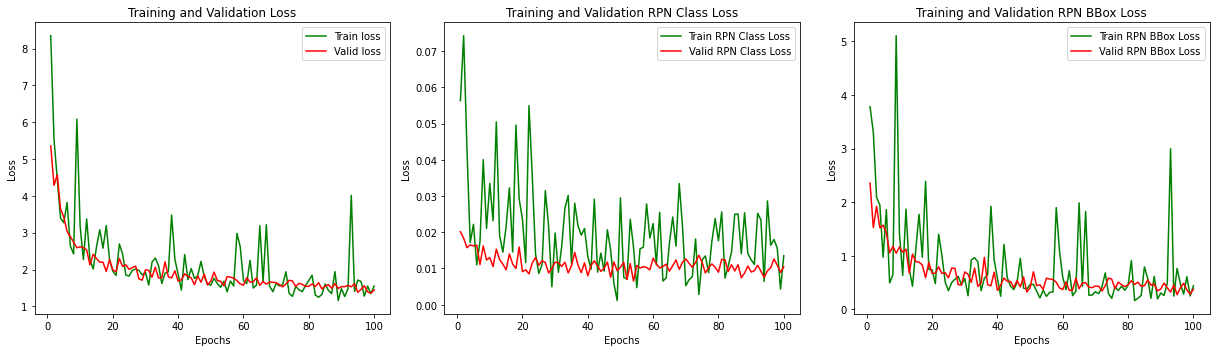

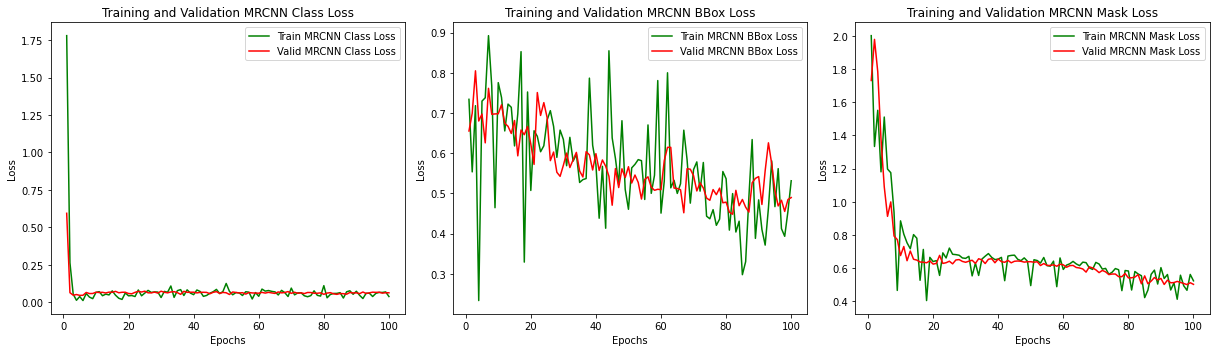

In [21]:
# Plotting the first set of graphs
plt.figure(figsize=(17, 5))

# Plotting total loss
plt.subplot(131)
plt.plot(epochs, history_df['loss'], label='Train loss', color='green')
plt.plot(epochs, history_df['val_loss'], label='Valid loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting RPN class loss
plt.subplot(132)
plt.plot(epochs, history_df['rpn_class_loss'], label='Train RPN Class Loss', color='green')
plt.plot(epochs, history_df['val_rpn_class_loss'], label='Valid RPN Class Loss', color='red')
plt.title('Training and Validation RPN Class Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting RPN bbox loss
plt.subplot(133)
plt.plot(epochs, history_df['rpn_bbox_loss'], label='Train RPN BBox Loss', color='green')
plt.plot(epochs, history_df['val_rpn_bbox_loss'], label='Valid RPN BBox Loss', color='red')
plt.title('Training and Validation RPN BBox Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plotting the second set of graphs
plt.figure(figsize=(17, 5))

# Plotting MRCNN class loss
plt.subplot(131)
plt.plot(epochs, history_df['mrcnn_class_loss'], label='Train MRCNN Class Loss', color='green')
plt.plot(epochs, history_df['val_mrcnn_class_loss'], label='Valid MRCNN Class Loss', color='red')
plt.title('Training and Validation MRCNN Class Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting MRCNN bbox loss
plt.subplot(132)
plt.plot(epochs, history_df['mrcnn_bbox_loss'], label='Train MRCNN BBox Loss', color='green')
plt.plot(epochs, history_df['val_mrcnn_bbox_loss'], label='Valid MRCNN BBox Loss', color='red')
plt.title('Training and Validation MRCNN BBox Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting MRCNN mask loss
plt.subplot(133)
plt.plot(epochs, history_df['mrcnn_mask_loss'], label='Train MRCNN Mask Loss', color='green')
plt.plot(epochs, history_df['val_mrcnn_mask_loss'], label='Valid MRCNN Mask Loss', color='red')
plt.title('Training and Validation MRCNN Mask Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
# import matplotlib.pyplot as plt
# import pandas as pd

# # Assuming `history` contains the training history
# history = model.keras_model.history.history
# new_history = model.keras_model.history.history

# # Combine the histories
# for k in new_history:
#     history[k] = history[k] + new_history[k]

# # Ensure each list in the history dictionary is of length 100
# for key in history.keys():
#     history[key] = history[key][:100]

# # Create a DataFrame from the history
# epochs = range(1, 101)  # Fixed 100 epochs
# history_df = pd.DataFrame(history, index=epochs)

# # Define the figure size and layout
# plt.figure(figsize=(18, 24))

# # Plotting total loss
# plt.subplot(6, 2, 1)
# plt.plot(epochs, history_df['loss'], label='Train loss')
# plt.plot(epochs, history_df['val_loss'], label='Valid loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Plotting RPN class loss
# plt.subplot(6, 2, 2)
# plt.plot(epochs, history_df['rpn_class_loss'], label='Train RPN Class Loss')
# plt.plot(epochs, history_df['val_rpn_class_loss'], label='Valid RPN Class Loss')
# plt.title('Training and Validation RPN Class Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Plotting RPN bbox loss
# plt.subplot(6, 2, 3)
# plt.plot(epochs, history_df['rpn_bbox_loss'], label='Train RPN BBox Loss')
# plt.plot(epochs, history_df['val_rpn_bbox_loss'], label='Valid RPN BBox Loss')
# plt.title('Training and Validation RPN BBox Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Plotting MRCNN class loss
# plt.subplot(6, 2, 4)
# plt.plot(epochs, history_df['mrcnn_class_loss'], label='Train MRCNN Class Loss')
# plt.plot(epochs, history_df['val_mrcnn_class_loss'], label='Valid MRCNN Class Loss')
# plt.title('Training and Validation MRCNN Class Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Plotting MRCNN bbox loss
# plt.subplot(6, 2, 5)
# plt.plot(epochs, history_df['mrcnn_bbox_loss'], label='Train MRCNN BBox Loss')
# plt.plot(epochs, history_df['val_mrcnn_bbox_loss'], label='Valid MRCNN BBox Loss')
# plt.title('Training and Validation MRCNN BBox Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Plotting MRCNN mask loss
# plt.subplot(6, 2, 6)
# plt.plot(epochs, history_df['mrcnn_mask_loss'], label='Train MRCNN Mask Loss')
# plt.plot(epochs, history_df['val_mrcnn_mask_loss'], label='Valid MRCNN Mask Loss')
# plt.title('Training and Validation MRCNN Mask Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.show()


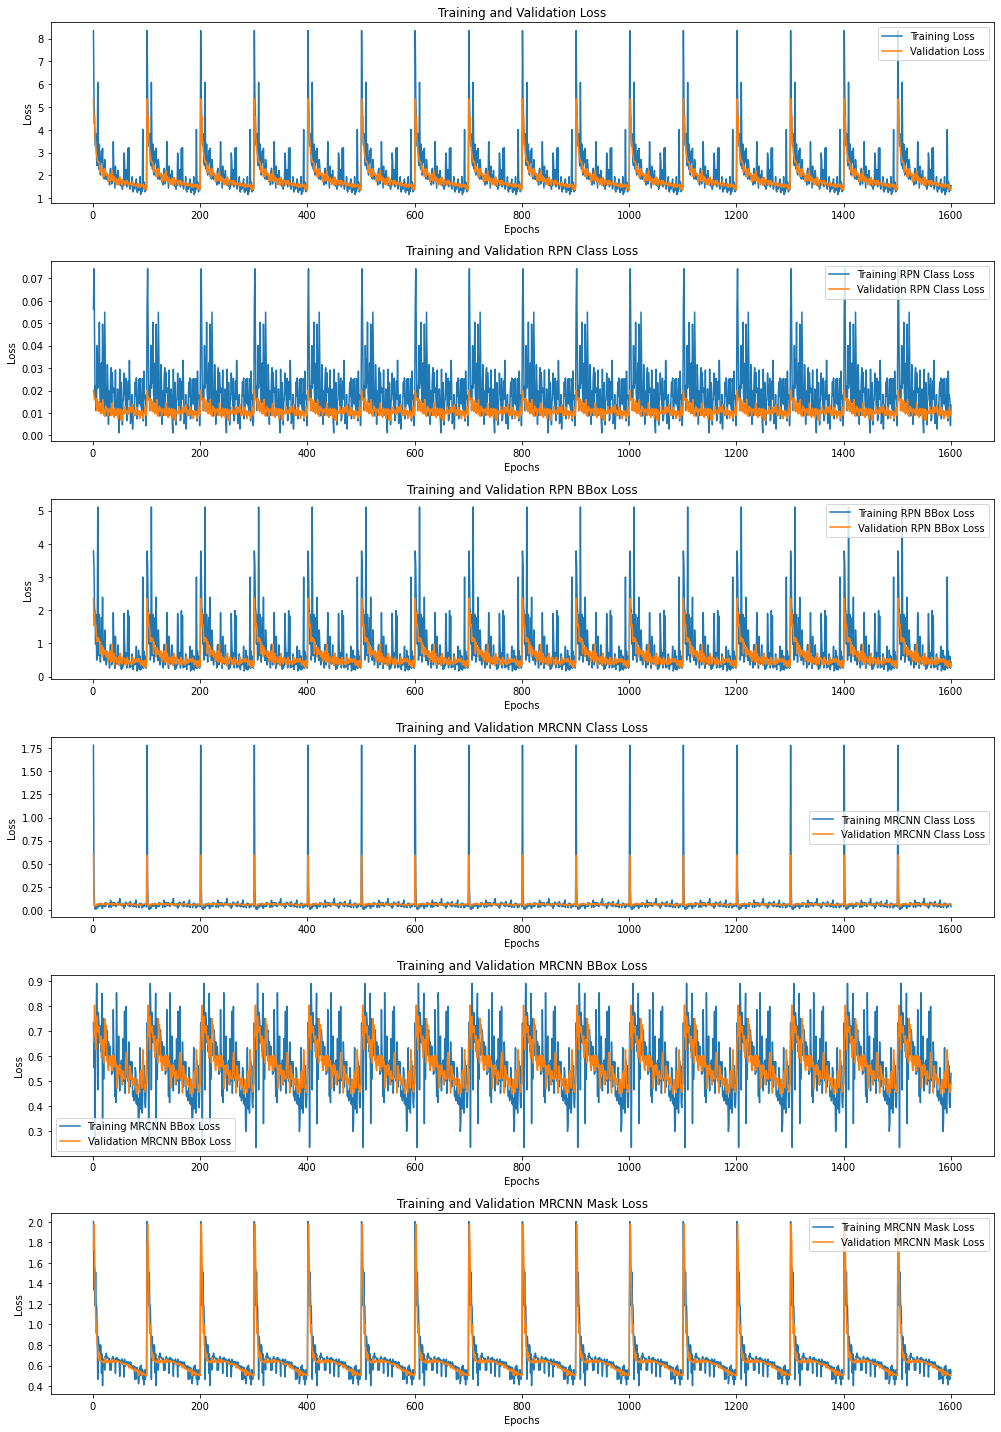

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `history` contains the training history
history = model.keras_model.history.history
new_history = model.keras_model.history.history

# Combine the histories
for k in new_history:
    history[k] = history[k] + new_history[k]

# Create a DataFrame from the history
epochs = range(1, len(next(iter(history.values()))) + 1)
history_df = pd.DataFrame(history, index=epochs)

# Plotting each pair of training and validation losses separately
plt.figure(figsize=(14, 20))

# Plotting total loss
plt.subplot(6, 1, 1)
plt.plot(epochs, history_df['loss'], label='Training Loss')
plt.plot(epochs, history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting RPN class loss
plt.subplot(6, 1, 2)
plt.plot(epochs, history_df['rpn_class_loss'], label='Training RPN Class Loss')
plt.plot(epochs, history_df['val_rpn_class_loss'], label='Validation RPN Class Loss')
plt.title('Training and Validation RPN Class Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting RPN bbox loss
plt.subplot(6, 1, 3)
plt.plot(epochs, history_df['rpn_bbox_loss'], label='Training RPN BBox Loss')
plt.plot(epochs, history_df['val_rpn_bbox_loss'], label='Validation RPN BBox Loss')
plt.title('Training and Validation RPN BBox Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting MRCNN class loss
plt.subplot(6, 1, 4)
plt.plot(epochs, history_df['mrcnn_class_loss'], label='Training MRCNN Class Loss')
plt.plot(epochs, history_df['val_mrcnn_class_loss'], label='Validation MRCNN Class Loss')
plt.title('Training and Validation MRCNN Class Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting MRCNN bbox loss
plt.subplot(6, 1, 5)
plt.plot(epochs, history_df['mrcnn_bbox_loss'], label='Training MRCNN BBox Loss')
plt.plot(epochs, history_df['val_mrcnn_bbox_loss'], label='Validation MRCNN BBox Loss')
plt.title('Training and Validation MRCNN BBox Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting MRCNN mask loss
plt.subplot(6, 1, 6)
plt.plot(epochs, history_df['mrcnn_mask_loss'], label='Training MRCNN Mask Loss')
plt.plot(epochs, history_df['val_mrcnn_mask_loss'], label='Validation MRCNN Mask Loss')
plt.title('Training and Validation MRCNN Mask Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
